In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [3]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [4]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Logged In Users Pre and Post  User Menu Deployment Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**28 October 2021**  
**24 January 2022**  
**3 February 2022**  
**11 February 2022**  
**14 February 2022**

[TICKET](https://phabricator.wikimedia.org/T289574)

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Trend of User Link Clicks](#Trend-of-User-Link-Clicks)
5. [Comparison of Pre and Post Deployment](#Comparison-of-Pre-and-Post-Deployment)
6. [Any impacts on editing?](#Any-impacts-on-editing?)
7. [Pattern by edit buckets](#Pattern0-by-edit-buckets)

# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team) is introducing a new way to display the user tools found at the top of the page. The original user tools appear as links at the top of the page. The new solution reorganized the tools under a single menu that will allow users easy access to their user tools and make the navigation more intuitive by visually highlighting the structure of user links and their purpose. You can find more information on this change and other feature deployments on the [User menu project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/User_menu).

User menu is deployed on logged-in users with new skin version on all early adopter wikis in August 10,  2021.  This report details the analysis and results for the deployment of user menu on logged-in users.

Polit wikis are:  
        - French Wikitionary (frwiktionary)   
        - Hebrew Wikipedia (hewiki)    
        - Portuguese Wikiversity (ptwikiversity)   
        - French Wikipedia (frwiki)     
        - Basque Wikipedia (euwiki)  
        - Persian Wikipedia (fawiki)  
        - Portuguese Wikipedia (ptwiki)  
        - Korean Wikipedia (kowiki)  
        - Turkish Wikipedia (trwiki)  
        - Serbian Wikipedia (srwiki)  
        - Bengali Wikipedia (bnwiki)  
        - German Wikivoyage (dewikivoyage)  
        - Venetian Wikipedia (vecwiki)  
        - Wikimedia Incubator (incubatorwiki)  

__New feature -- user tools under user menu__
<img src="Figures/new.png" width="600" height="400" align="center"/>

__Old feature -- user tools without user menu__

<img src="Figures/old.png" width="600" height="360" align="center"/>

# Purpose

The goal of the pre-post analysis is to identify any changes in user behavior that might have resulted from the deployment of the user menu feature. Our hypothesis is that while we decrease visual clutter on interface, the clicks on user tools under user menu will slightly lower than the original design. 

# Methodology

We reviewed the total number of clicks on each available user tools by each pilot wikis. We mainly focused on the logged-in users because this feature is designed for logged-in users. 

We selected a period of 4 weeks before the deployment as the pre deployment period, i.e. 2021-07-13 ~  2021-08-09 .  Post period analysis reviewed the numbers within the 4 weeks since the deployment, i.e. 2021-08-10  ~  2021-09-06.

The clicks on some user tools on some wikis are too few to show a consistent trend. When we analyze the pattern by editing buckets, we look at the total number of clicks from all wikis on each user tool.



# Trend of User Menu Clicks

In [1]:
query_user_link_clicks <- 
"
SELECT TO_DATE(dt) AS event_date, 
    wiki, 
    event.name, 
    event.skinversion,
    event.isAnon, 
    COUNT(1) AS clicks 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='click' 
AND event.name IN ('ui.dropdown-p-personal', 'pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 'pt-mycontris', 'pt-logout') 
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) , wiki, event.name,  event.skinversion, event.isAnon
"

In [5]:
df_user_link_clicks <-  wmfdata::query_hive(query_user_link_clicks)

Don't forget to authenticate with Kerberos using kinit



In [6]:
df_user_link_clicks$event_date <- as.Date(df_user_link_clicks$event_date)

In [17]:
df_user_link_clicks[,'skinversion']<-factor(df_user_link_clicks[,'skinversion'])

In [18]:
head(df_user_link_clicks)

event_date wiki         name           skinversion isanon clicks
1 2021-07-01 euwiki       pt-logout      2           false    4   
2 2021-07-01 frwiktionary pt-preferences 2           false    1   
3 2021-07-01 hewiki       pt-watchlist   1           false  137   
4 2021-07-01 hewiki       pt-watchlist   2           false   74   
5 2021-07-02 euwiki       pt-logout      2           false    4   
6 2021-07-02 frwiktionary pt-preferences 2           false    1   
  wiki_name         
1 Basque Wikipedia  
2 French Wikitionary
3 Hebrew Wikipedia  
4 Hebrew Wikipedia  
5 Basque Wikipedia  
6 French Wikitionary

In [19]:
df_user_link_clicks <- df_user_link_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)

In [20]:
df_user_munu <- df_user_link_clicks %>%
    filter((isanon=='false') & (name=='ui.dropdown-p-personal')) 



In [21]:
df_user_munu

event_date wiki   name                   skinversion isanon clicks
1    2021-08-10 frwiki ui.dropdown-p-personal 2           false   25   
2    2021-08-11 fawiki ui.dropdown-p-personal 2           false  158   
3    2021-08-11 frwiki ui.dropdown-p-personal 2           false  852   
4    2021-08-12 fawiki ui.dropdown-p-personal 2           false  136   
5    2021-08-12 frwiki ui.dropdown-p-personal 2           false  796   
6    2021-08-13 fawiki ui.dropdown-p-personal 2           false   89   
7    2021-08-13 frwiki ui.dropdown-p-personal 2           false  690   
8    2021-08-14 fawiki ui.dropdown-p-personal 2           false  121   
9    2021-08-14 frwiki ui.dropdown-p-personal 2           false  623   
10   2021-08-15 fawiki ui.dropdown-p-personal 2           false  147   
11   2021-08-15 frwiki ui.dropdown-p-personal 2           false  618   
12   2021-08-16 fawiki ui.dropdown-p-personal 2           false  136   
13   2021-08-16 frwiki ui.dropdown-p-personal 2           false  715   
14   2021-08-17 fawiki ui.dropdown-p-personal 2           false  150   
15   2021-08-17 frwiki ui.dropdown-p-personal 2           false  765   
16   2021-08-18 fawiki ui.dropdown-p-personal 2           false   98   
17   2021-08-18 frwiki ui.dropdown-p-personal 2           false  740   
18   2021-08-19 fawiki ui.dropdown-p-personal 2           false  108   
19   2021-08-19 frwiki ui.dropdown-p-personal 2           false  797   
20   2021-08-20 fawiki ui.dropdown-p-personal 2           false  121   
21   2021-08-20 frwiki ui.dropdown-p-personal 2           false  686   
22   2021-08-21 fawiki ui.dropdown-p-personal 2           false  162   
23   2021-08-21 frwiki ui.dropdown-p-personal 2           false  635   
24   2021-08-22 fawiki ui.dropdown-p-personal 2           false  126   
25   2021-08-22 frwiki ui.dropdown-p-personal 2           false  657   
26   2021-08-23 fawiki ui.dropdown-p-personal 2           false  119   
27   2021-08-23 frwiki ui.dropdown-p-personal 2           false  766   
28   2021-08-24 fawiki ui.dropdown-p-personal 2           false  113   
29   2021-08-24 frwiki ui.dropdown-p-personal 2           false  834   
30   2021-08-25 fawiki ui.dropdown-p-personal 2           false  136   
⋮    ⋮          ⋮      ⋮                      ⋮           ⋮      ⋮     
1780 2021-12-02 frwiki ui.dropdown-p-personal 2           false  3935  
1781 2021-12-03 frwiki ui.dropdown-p-personal 2           false  3737  
1782 2021-12-04 frwiki ui.dropdown-p-personal 2           false  3193  
1783 2021-12-05 frwiki ui.dropdown-p-personal 2           false  3574  
1784 2021-12-06 frwiki ui.dropdown-p-personal 2           false  4034  
1785 2021-12-07 frwiki ui.dropdown-p-personal 2           false  3927  
1786 2021-12-08 frwiki ui.dropdown-p-personal 2           false  4043  
1787 2021-12-09 frwiki ui.dropdown-p-personal 2           false  3912  
1788 2021-12-10 frwiki ui.dropdown-p-personal 2           false  3787  
1789 2021-12-11 frwiki ui.dropdown-p-personal 2           false  3378  
1790 2021-12-12 frwiki ui.dropdown-p-personal 2           false  3494  
1791 2021-12-13 frwiki ui.dropdown-p-personal 2           false  3955  
1792 2021-12-14 frwiki ui.dropdown-p-personal 2           false  3822  
1793 2021-12-15 frwiki ui.dropdown-p-personal 2           false  3604  
1794 2021-12-16 frwiki ui.dropdown-p-personal 2           false  3800  
1795 2021-12-17 frwiki ui.dropdown-p-personal 2           false  3478  
1796 2021-12-18 frwiki ui.dropdown-p-personal 2           false  2800  
1797 2021-12-19 frwiki ui.dropdown-p-personal 2           false  2960  
1798 2021-12-20 frwiki ui.dropdown-p-personal 2           false  3654  
1799 2021-12-21 frwiki ui.dropdown-p-personal 2           false  3552  
1800 2021-12-22 frwiki ui.dropdown-p-personal 2           false  3817  
1801 2021-12-23 frwiki ui.dropdown-p-personal 2           false  3401  
1802 2021-12-24 frwiki ui.dropdown-p-personal 2           false  2569  
1803 2021-12-25 frwiki ui.dropdown-p-personal

In [32]:
any(is.na(df_user_link_clicks))

[1] FALSE

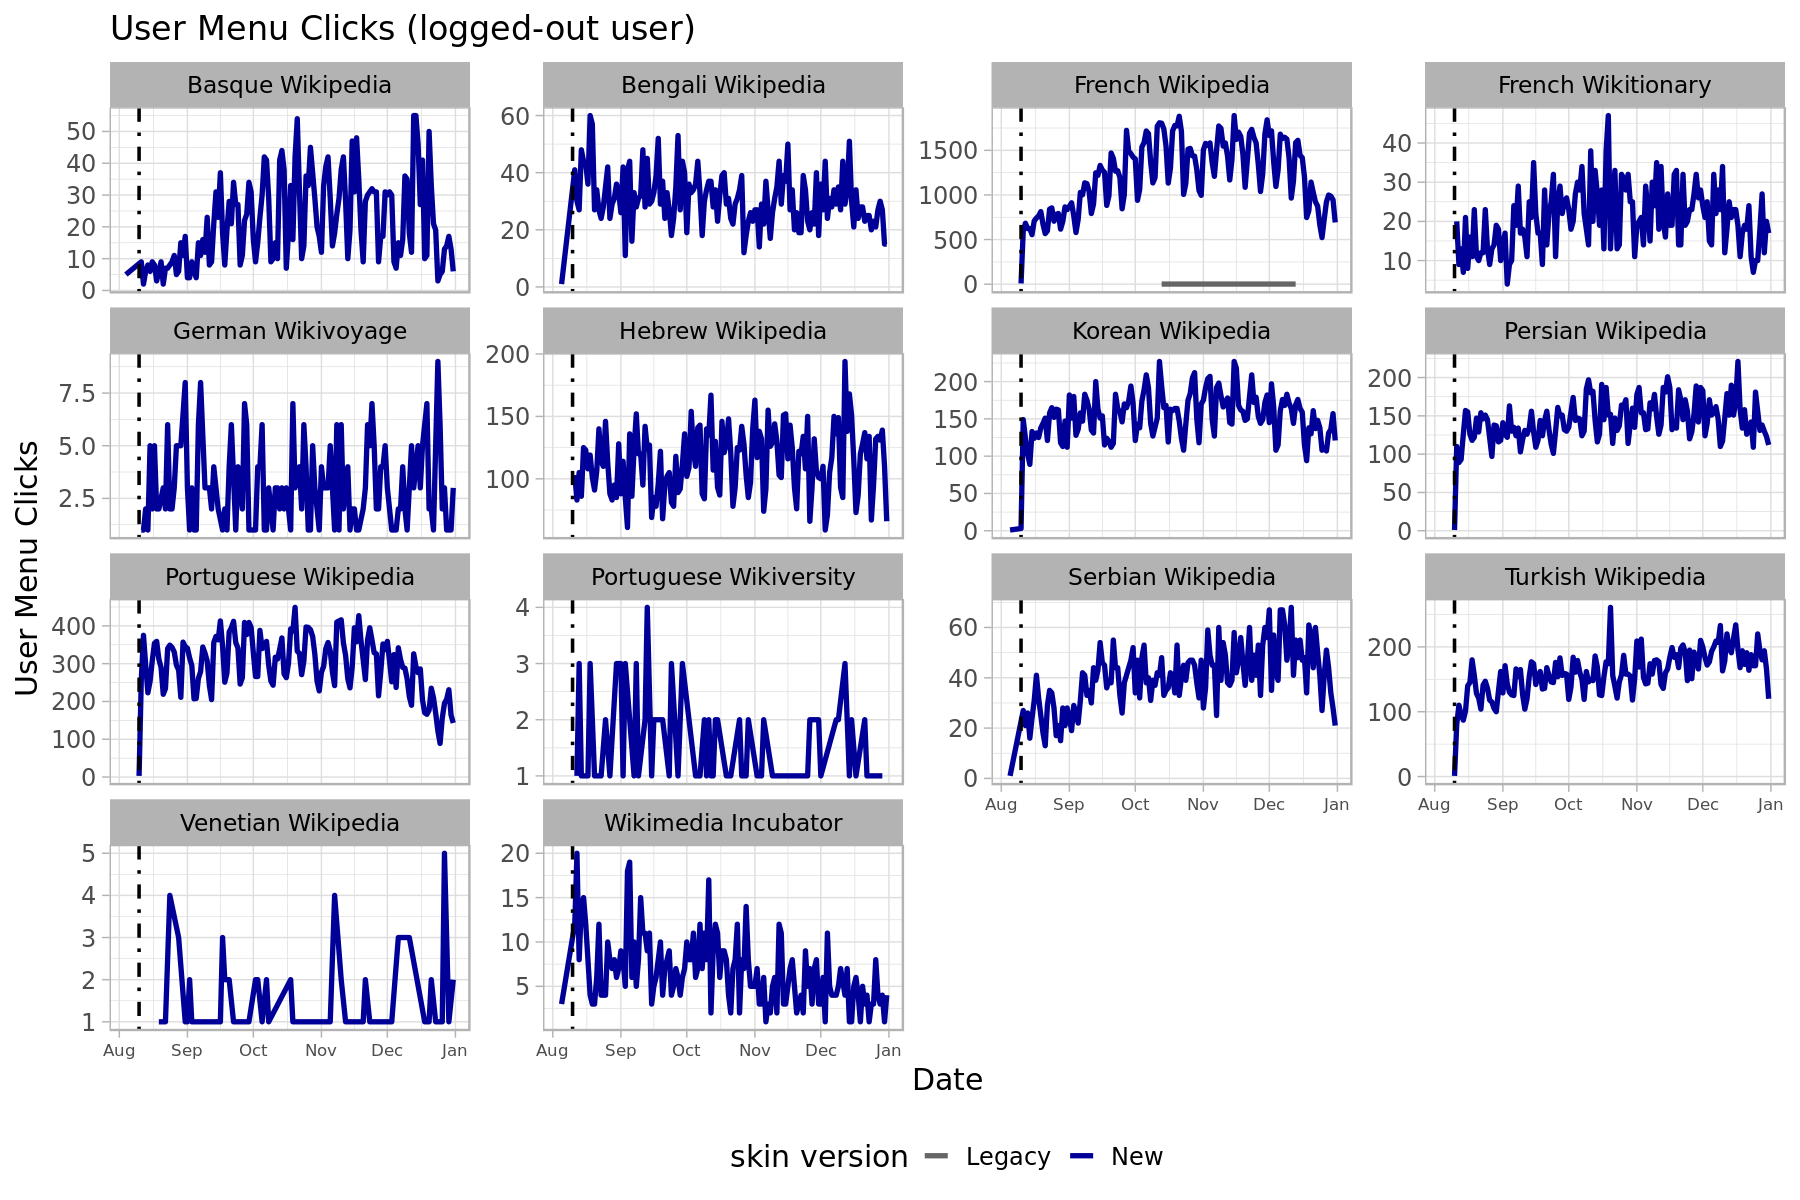

In [62]:
menu_anon_g <- ggplot(data=filter( df_user_link_clicks,  (name=='ui.dropdown-p-personal')&(isanon=='true')), 
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Menu Clicks (logged-out user) ',
     x = 'Date',
     y = 'User Menu Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
menu_anon_g

__Summary__


User dropdown menu is in use since 2021-08-10.

# Trend of User Link Clicks

## By wiki and user tool

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



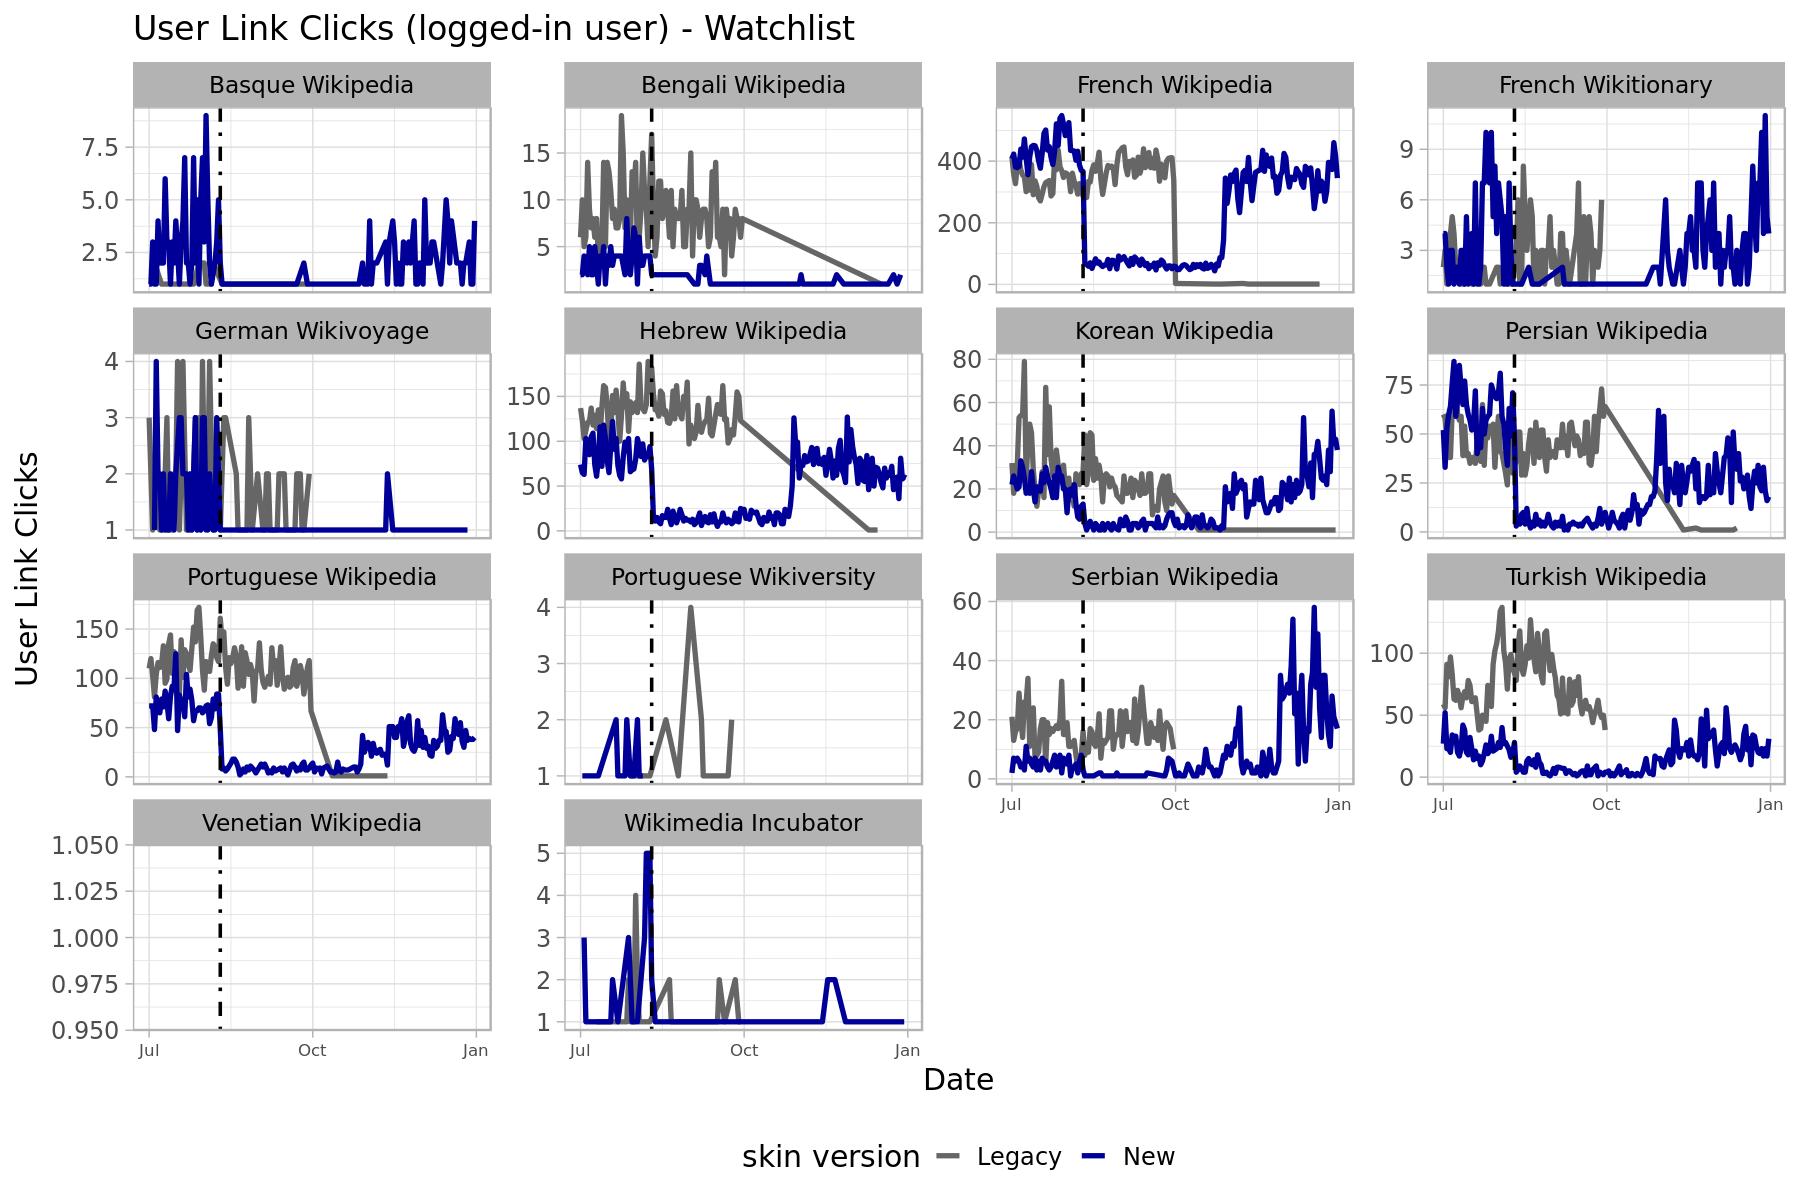

In [61]:
watchlist_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-watchlist')&(isanon=='false')), 
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4, scale = 'free_y' )+
labs(title = 'User Link Clicks (logged-in user) - Watchlist ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
watchlist_g 

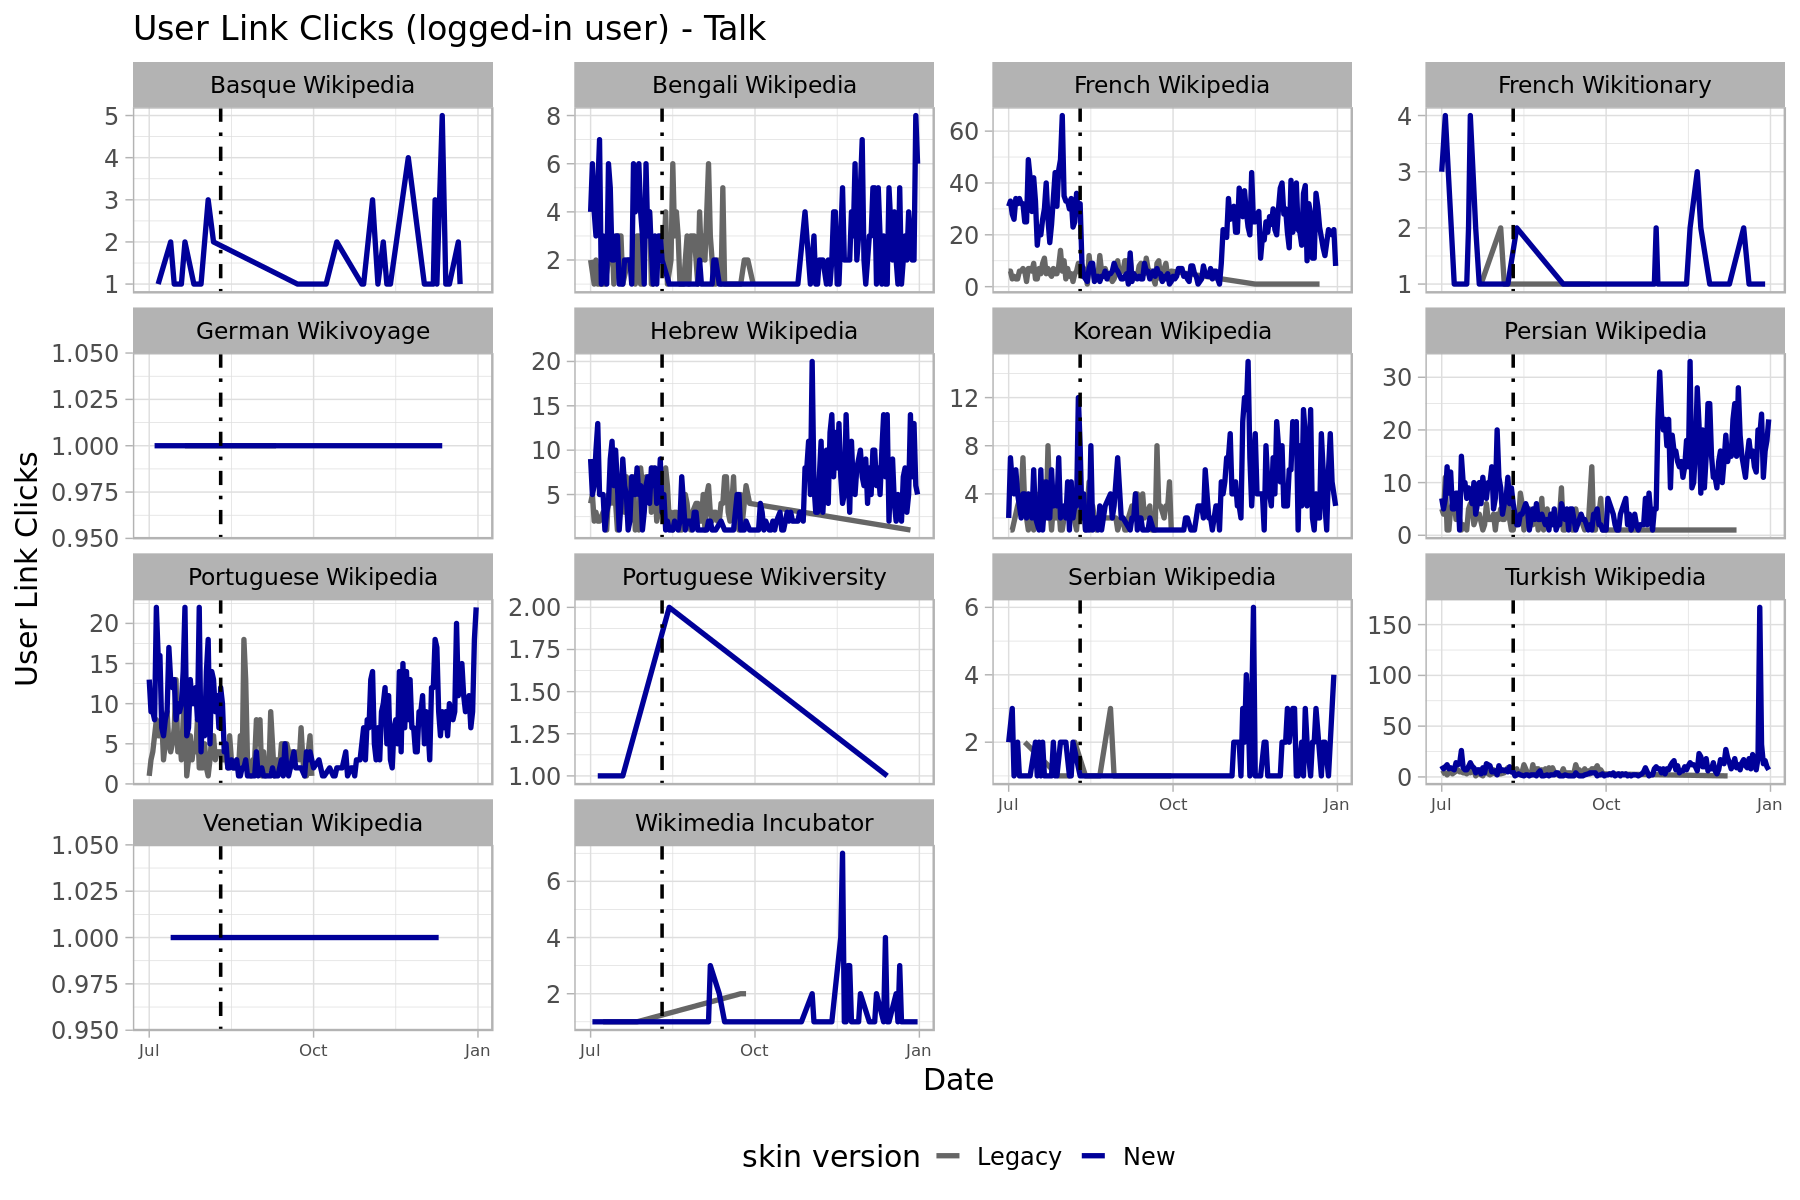

In [63]:
talk_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-mytalk')&(isanon=='false')), 
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +                 
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Talk ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
talk_g 

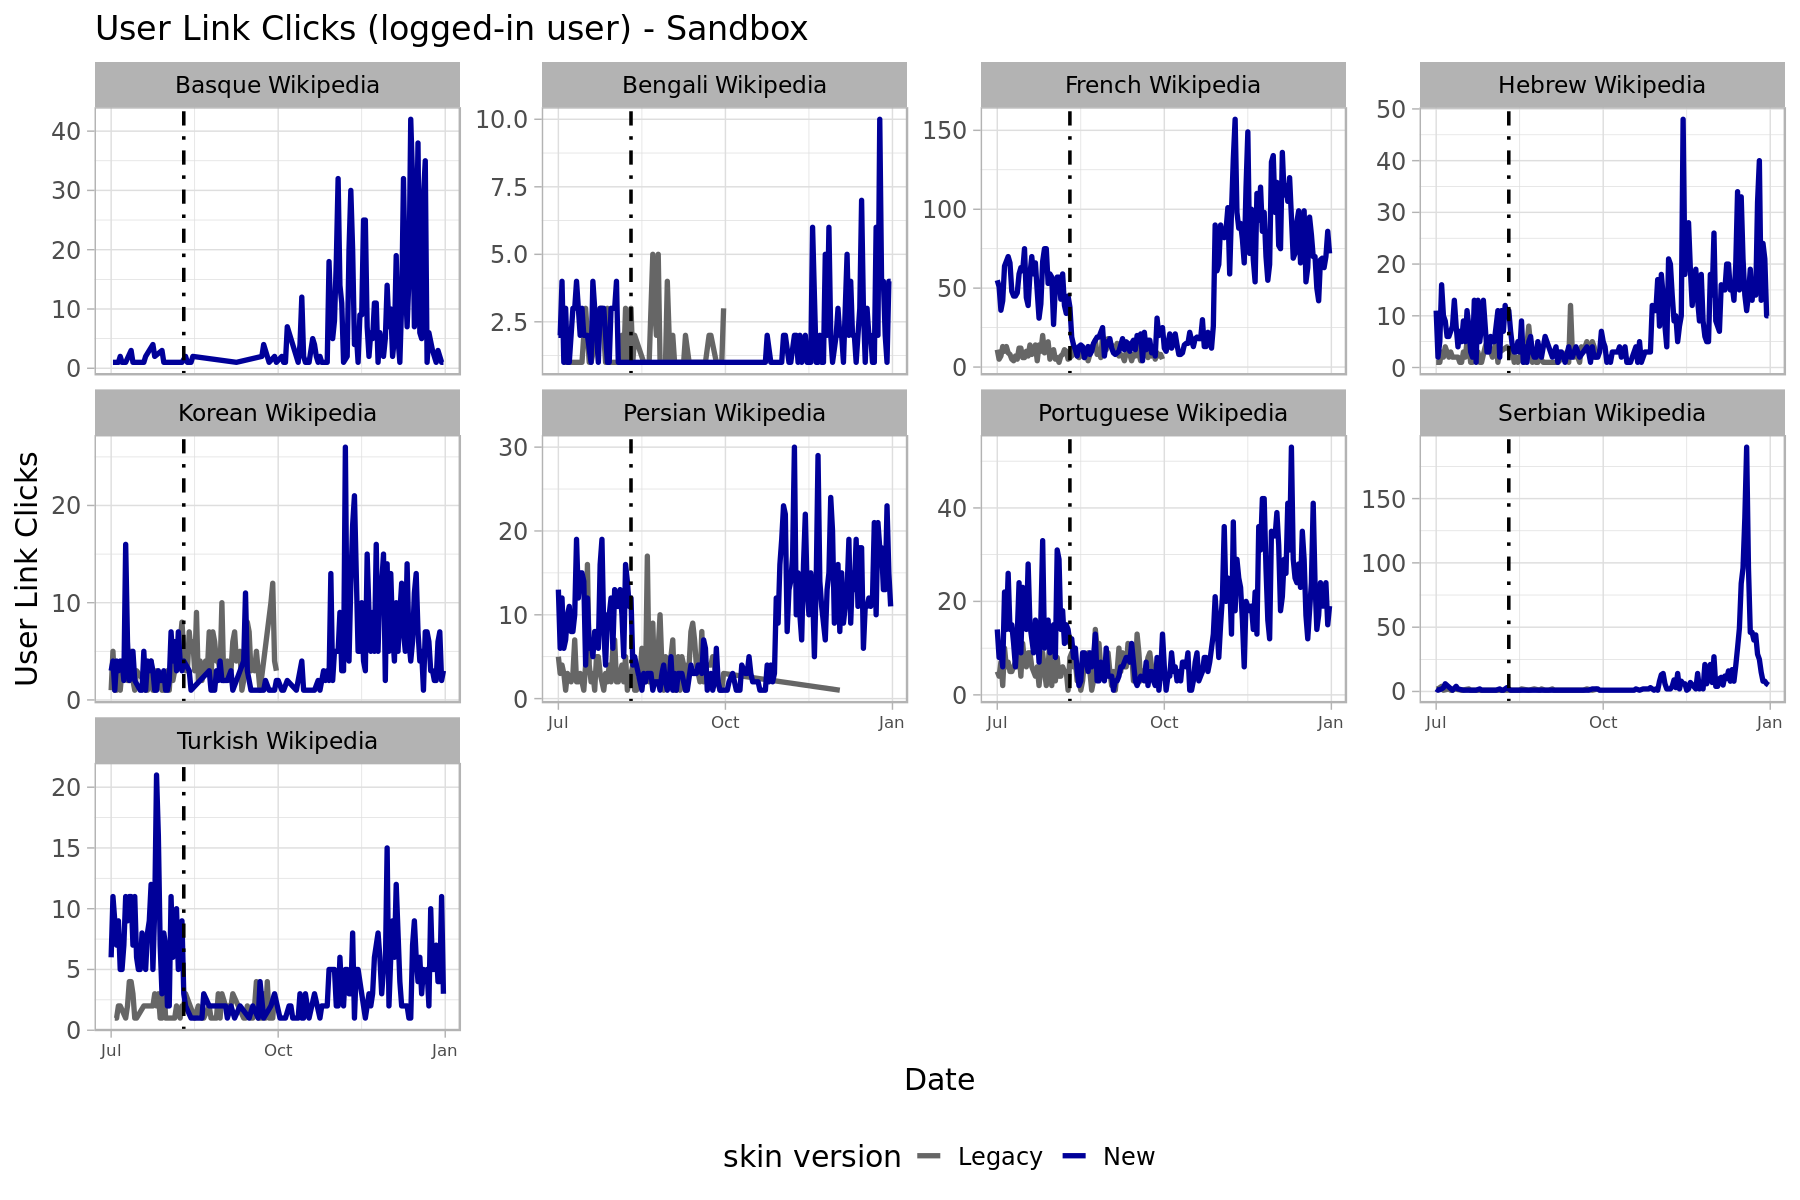

In [64]:
sandbox_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-sandbox')&(isanon=='false')),
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,ncol=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Sandbox ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
sandbox_g 

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



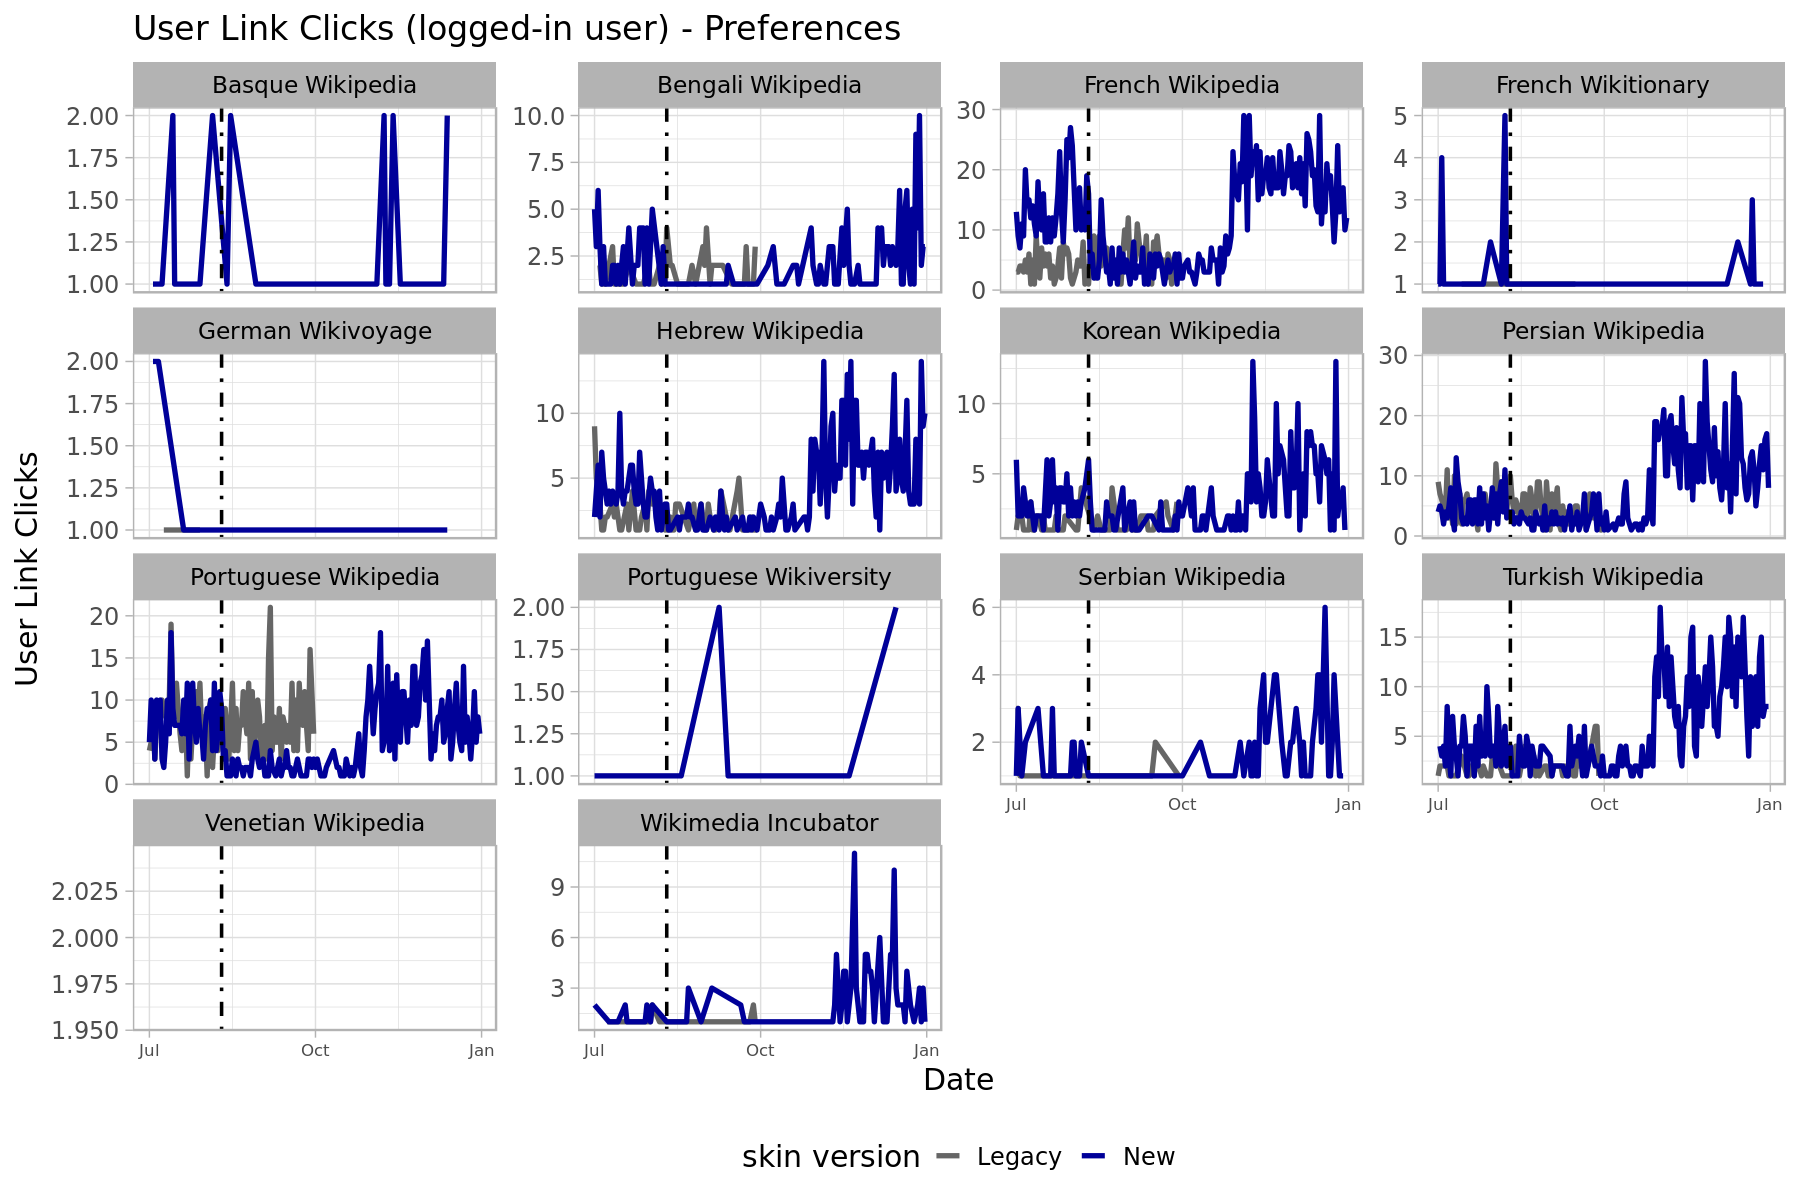

In [65]:
preferences_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-preferences')&(isanon=='false')),
                                 mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Preferences ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
preferences_g 

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



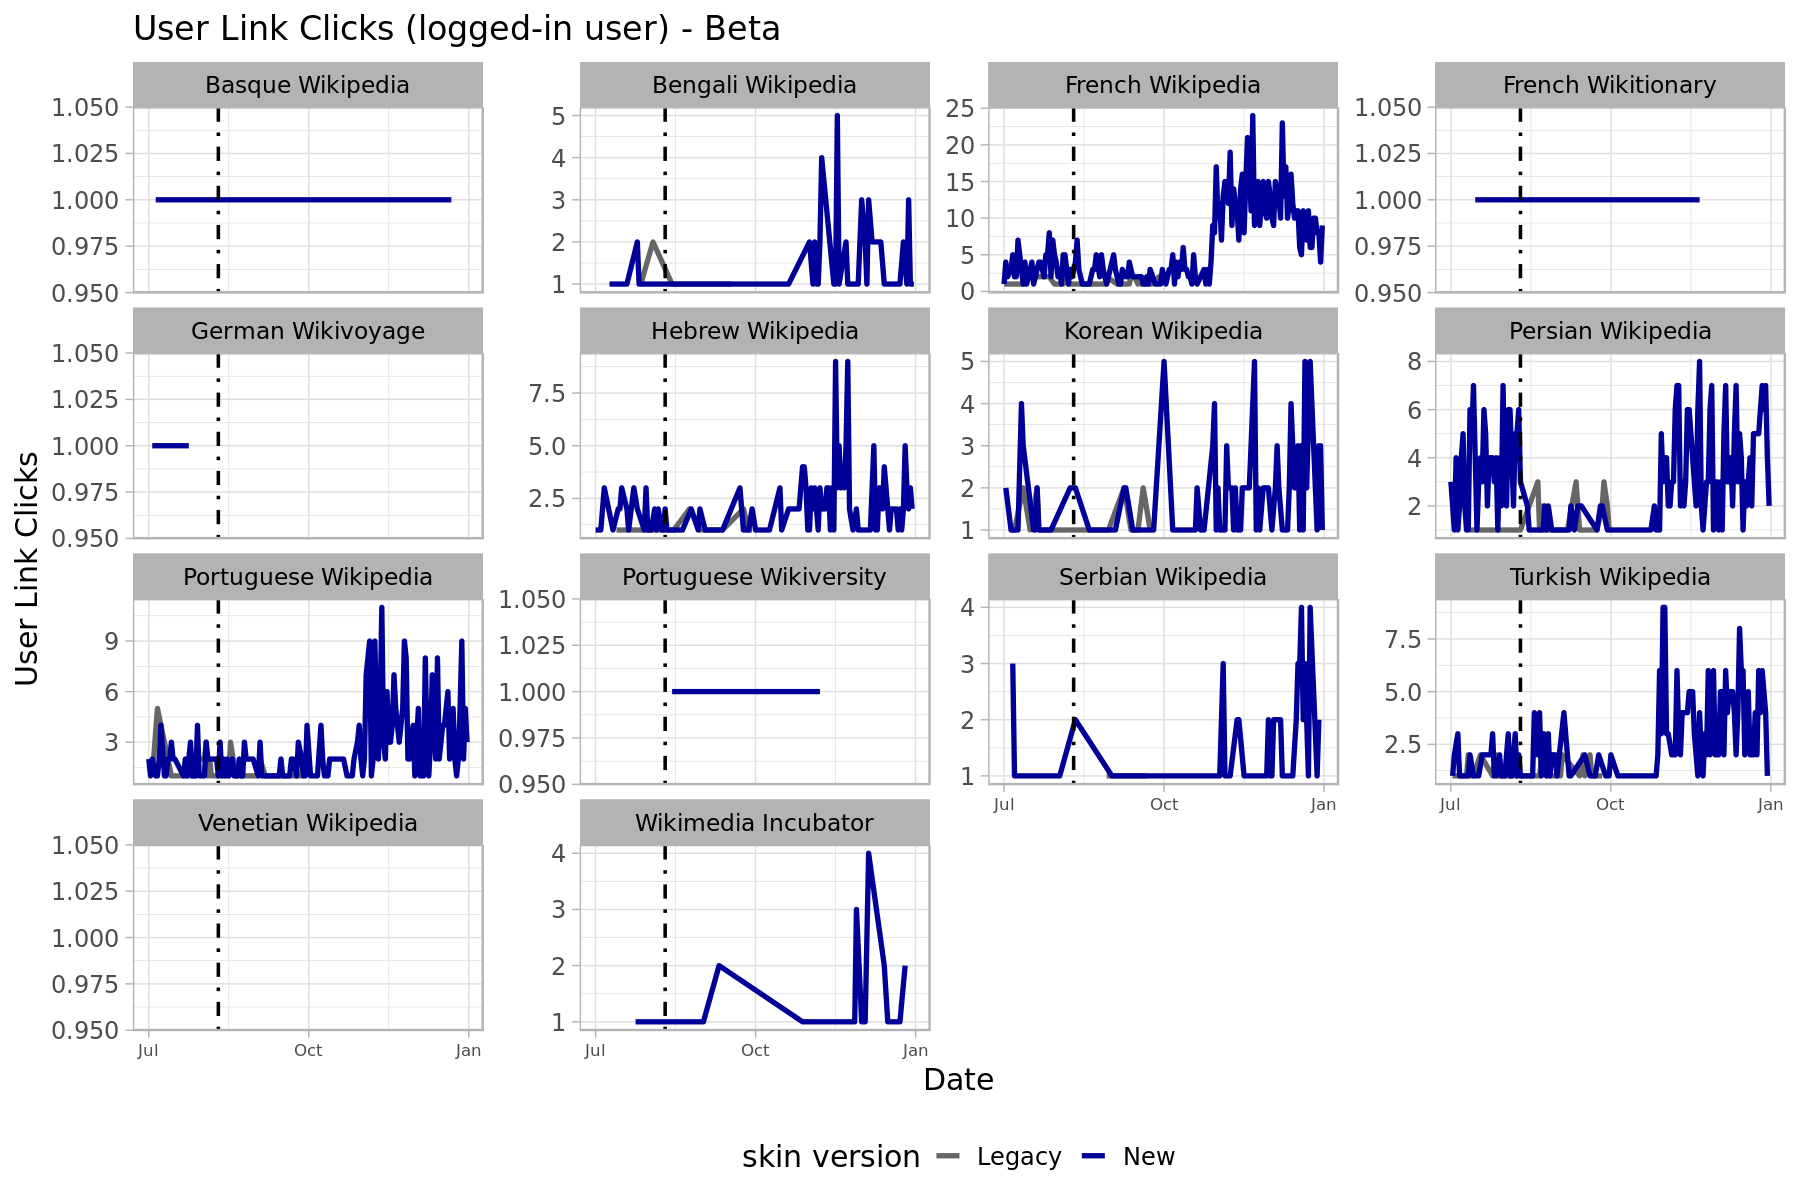

In [67]:
beta_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-betafeatures')&(isanon=='false')),
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,ncol=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Beta ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
beta_g 

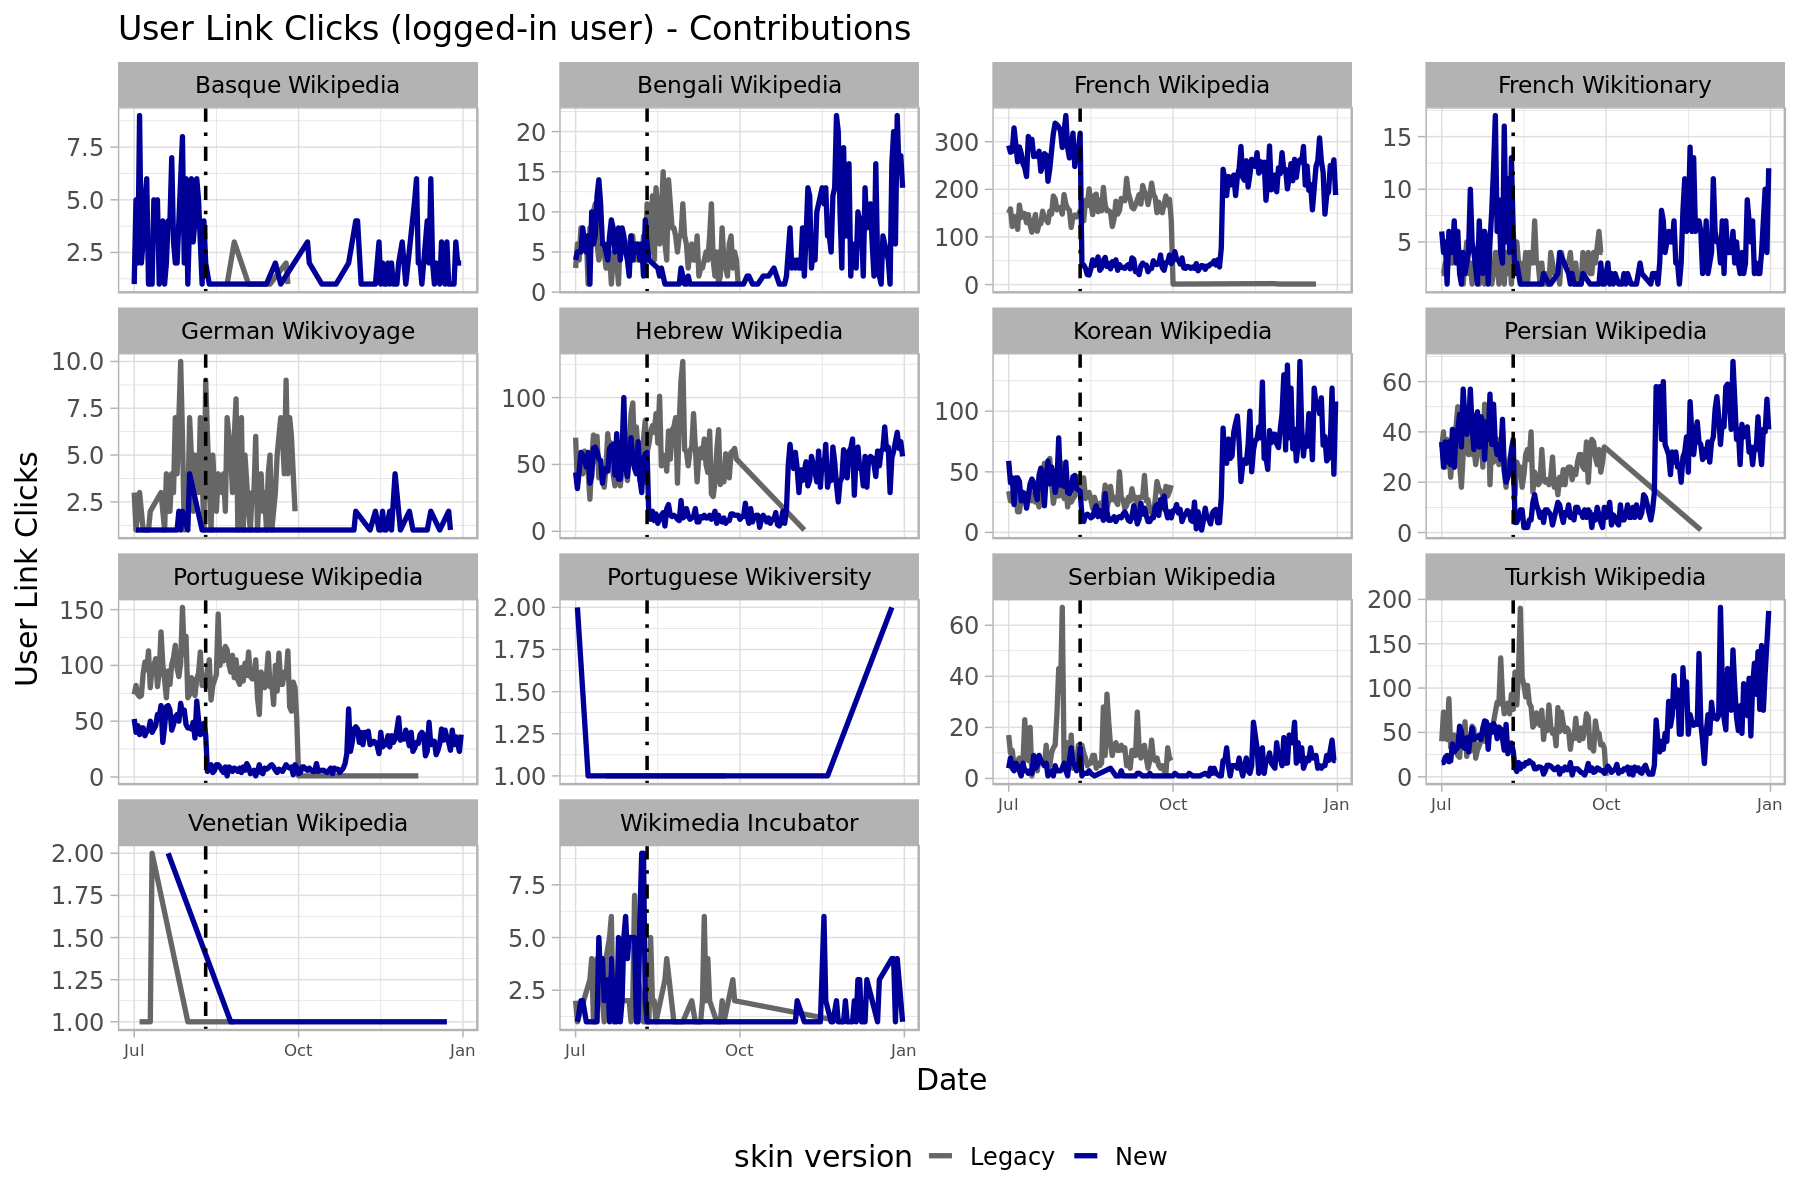

In [68]:
contri_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-mycontris')&(isanon=='false')),
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Contributions ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
contri_g 

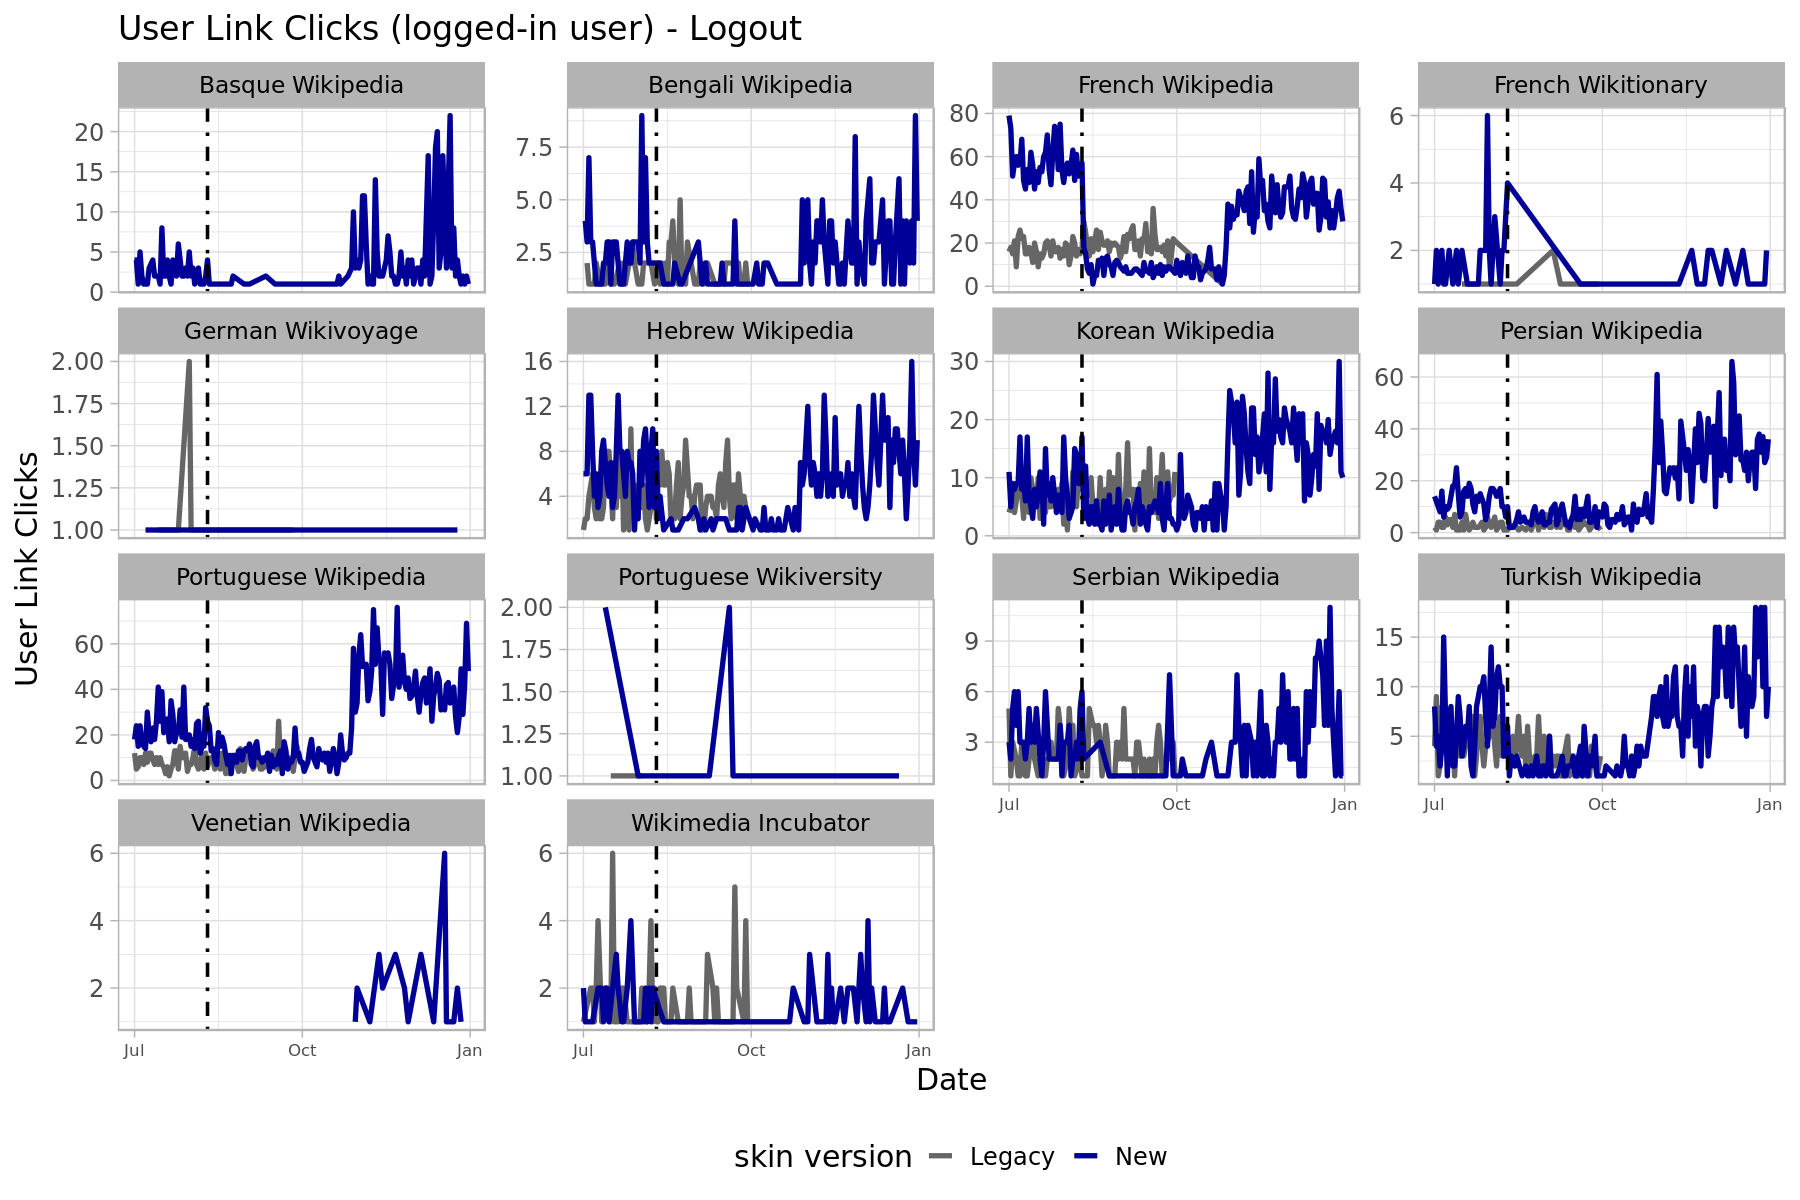

In [69]:
logout_g <- ggplot(data=filter( df_user_link_clicks,  (name=='pt-logout')&(isanon=='false')),
                                mapping=aes(x=event_date, y=clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks (logged-in user) - Logout ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
logout_g 

## By wiki

In [70]:
df_wiki <- df_user_link_clicks %>%
    filter((isanon=='false') & (name!='ui.dropdown-p-personal')) %>%
    group_by(wiki_name, event_date, skinversion) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop')


In [71]:
df_wiki

wiki_name           event_date skinversion user_link_clicks
1    Basque Wikipedia    2021-07-01 2            6              
2    Basque Wikipedia    2021-07-02 2           11              
3    Basque Wikipedia    2021-07-03 1            1              
4    Basque Wikipedia    2021-07-03 2            8              
5    Basque Wikipedia    2021-07-04 1            2              
6    Basque Wikipedia    2021-07-04 2           15              
7    Basque Wikipedia    2021-07-05 2            8              
8    Basque Wikipedia    2021-07-06 2           11              
9    Basque Wikipedia    2021-07-07 2            9              
10   Basque Wikipedia    2021-07-08 1            1              
11   Basque Wikipedia    2021-07-08 2            9              
12   Basque Wikipedia    2021-07-09 2            7              
13   Basque Wikipedia    2021-07-10 1            1              
14   Basque Wikipedia    2021-07-10 2            7              
15   Basque Wikipedia    2021-07-11 2            8              
16   Basque Wikipedia    2021-07-12 2           13              
17   Basque Wikipedia    2021-07-13 2           10              
18   Basque Wikipedia    2021-07-14 2           12              
19   Basque Wikipedia    2021-07-15 1            1              
20   Basque Wikipedia    2021-07-15 2            7              
21   Basque Wikipedia    2021-07-16 2           14              
22   Basque Wikipedia    2021-07-17 2            6              
23   Basque Wikipedia    2021-07-18 2            5              
24   Basque Wikipedia    2021-07-19 1            1              
25   Basque Wikipedia    2021-07-19 2           11              
26   Basque Wikipedia    2021-07-20 2           12              
27   Basque Wikipedia    2021-07-21 2           15              
28   Basque Wikipedia    2021-07-22 1            1              
29   Basque Wikipedia    2021-07-22 2           13              
30   Basque Wikipedia    2021-07-23 2            9              
⋮    ⋮                   ⋮          ⋮           ⋮               
3154 Wikimedia Incubator 2021-12-01 2            8              
3155 Wikimedia Incubator 2021-12-02 2            3              
3156 Wikimedia Incubator 2021-12-03 2            4              
3157 Wikimedia Incubator 2021-12-04 2            8              
3158 Wikimedia Incubator 2021-12-05 2            6              
3159 Wikimedia Incubator 2021-12-06 2           12              
3160 Wikimedia Incubator 2021-12-07 2            4              
3161 Wikimedia Incubator 2021-12-08 2            5              
3162 Wikimedia Incubator 2021-12-09 2            2              
3163 Wikimedia Incubator 2021-12-10 2            3              
3164 Wikimedia Incubator 2021-12-11 2            7              
3165 Wikimedia Incubator 2021-12-12 2            7              
3166 Wikimedia Incubator 2021-12-13 2           11              
3167 Wikimedia Incubator 2021-12-14 2           15              
3168 Wikimedia Incubator 2021-12-15 2            4              
3169 Wikimedia Incubator 2021-12-16 2            4              
3170 Wikimedia Incubator 2021-12-17 2            1              
3171 Wikimedia Incubator 2021-12-18 2            6              
3172 Wikimedia Incubator 2021-12-19 2            5              
3173 Wikimedia Incubator 2021-12-20 2            3              
3174 Wikimedia Incubator 2021-12-21 2            7              
3175 Wikimedia Incubator 2021-12-22 2            1              
3176 Wikimedia Incubator 2021-12-23 2            6              
3177 Wikimedia Incubator 2021-12-25 2            5              
3178 Wikimedia Incubator 2021-12-26 2            7              
3179 Wikimedia Incubator 2021-12-27 2            4              
3180 Wikimedia Incubator 2021-12-28 2            7              
3181 Wikimedia Incubator 2021-12-29 2            3              
3182 Wikimedia Incubator 2021-12-30 2            5              
3183 Wikimedia Incubator 2021-12-31 2   

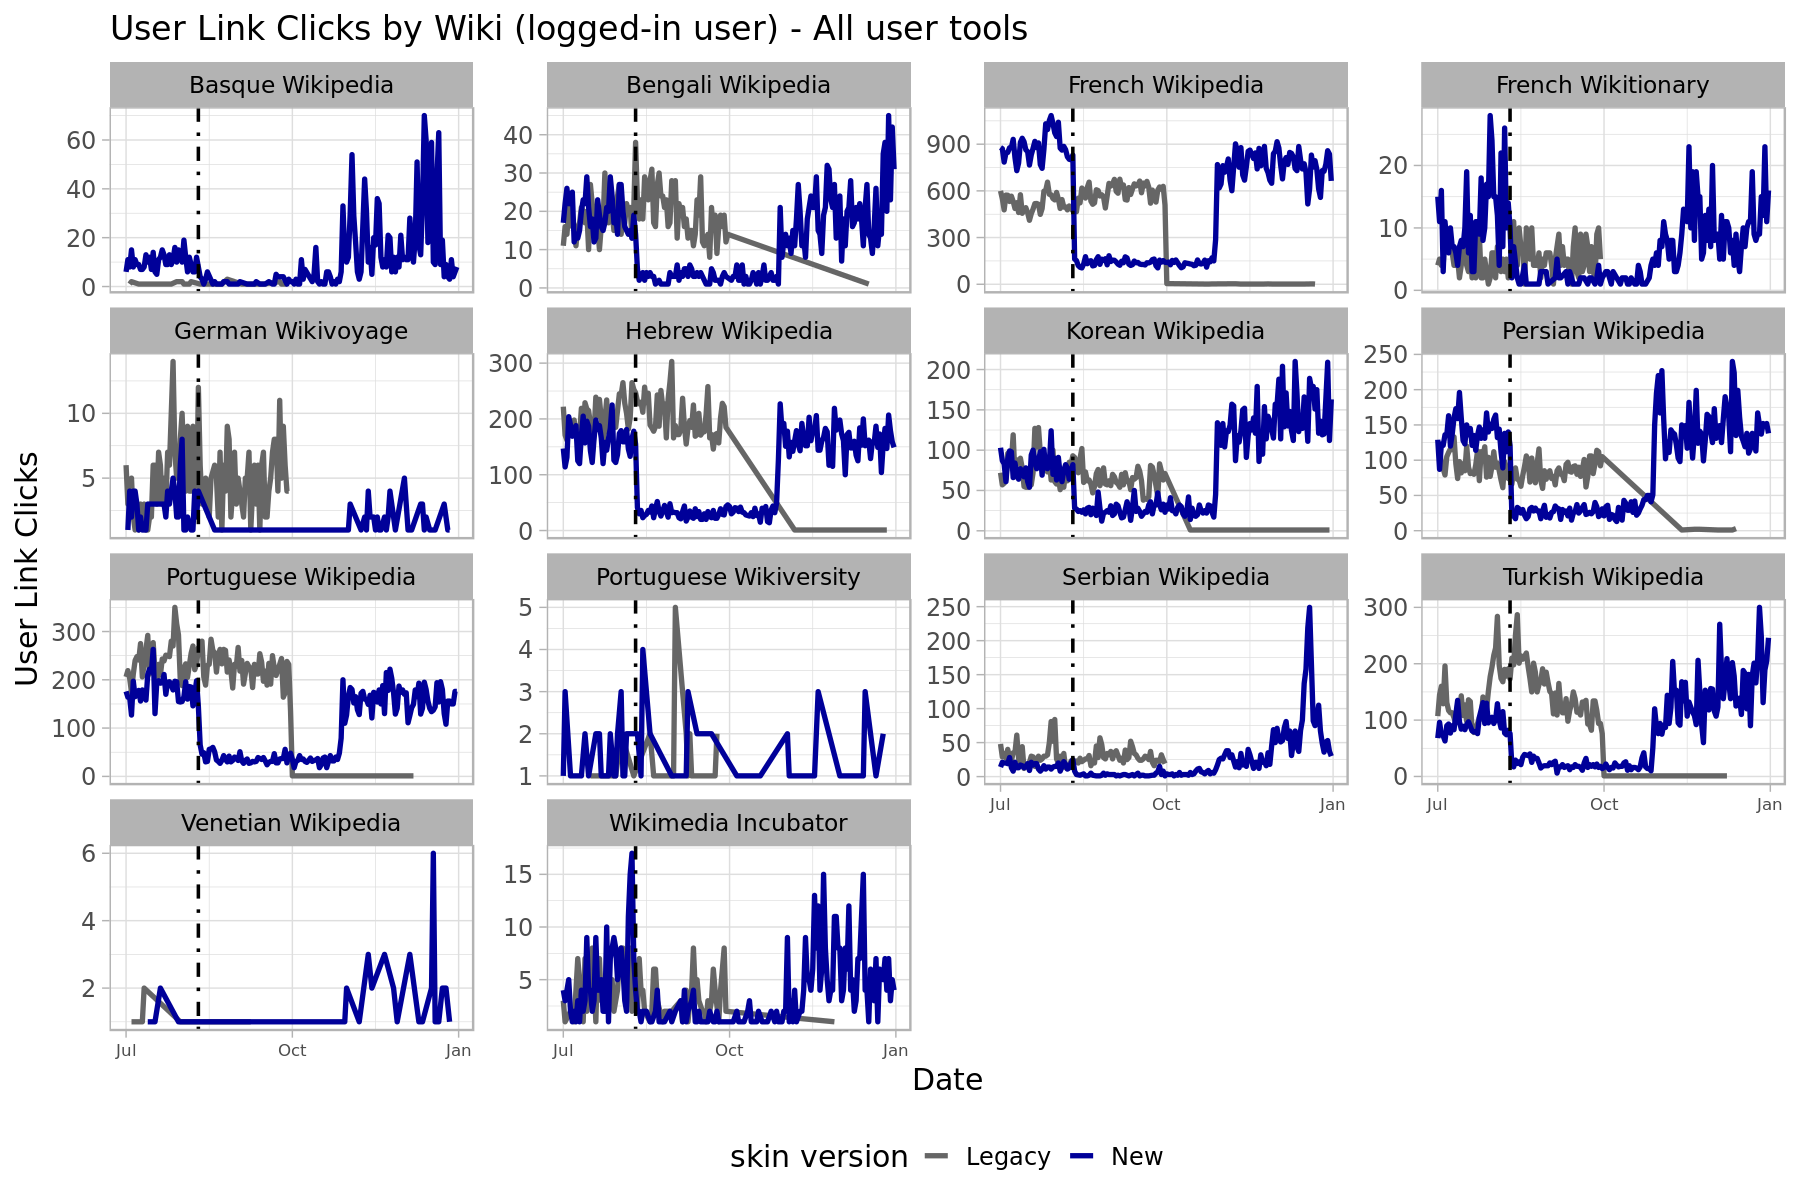

In [73]:
wiki_g <- ggplot(data=df_wiki,
                         mapping=aes(x=event_date, y=user_link_clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks by Wiki (logged-in user) - All user tools ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
wiki_g 

## By user tool

In [74]:
df_tool <- df_user_link_clicks %>%
    filter((isanon=='false') & (name!='ui.dropdown-p-personal')) %>%
    group_by(name, event_date,skinversion) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop')


In [75]:
filter(df_tool,(event_date <'2021-11-10') & (event_date >'2021-10-15'))

name            event_date skinversion user_link_clicks
1   pt-betafeatures 2021-10-16 2            5              
2   pt-betafeatures 2021-10-17 2            3              
3   pt-betafeatures 2021-10-18 2            5              
4   pt-betafeatures 2021-10-19 2            4              
5   pt-betafeatures 2021-10-20 2            6              
6   pt-betafeatures 2021-10-21 2            2              
7   pt-betafeatures 2021-10-22 2            5              
8   pt-betafeatures 2021-10-23 2            2              
9   pt-betafeatures 2021-10-24 2            5              
10  pt-betafeatures 2021-10-25 2            1              
11  pt-betafeatures 2021-10-26 2           10              
12  pt-betafeatures 2021-10-27 2            5              
13  pt-betafeatures 2021-10-28 2           13              
14  pt-betafeatures 2021-10-29 2           27              
15  pt-betafeatures 2021-10-30 2           28              
16  pt-betafeatures 2021-10-31 2           33              
17  pt-betafeatures 2021-11-01 2           30              
18  pt-betafeatures 2021-11-02 2           27              
19  pt-betafeatures 2021-11-03 2           23              
20  pt-betafeatures 2021-11-04 2           23              
21  pt-betafeatures 2021-11-05 2           32              
22  pt-betafeatures 2021-11-06 2           23              
23  pt-betafeatures 2021-11-07 2           31              
24  pt-betafeatures 2021-11-08 2           48              
25  pt-betafeatures 2021-11-09 2           25              
26  pt-logout       2021-10-16 2           21              
27  pt-logout       2021-10-17 2           31              
28  pt-logout       2021-10-18 2           41              
29  pt-logout       2021-10-19 2           40              
30  pt-logout       2021-10-20 2           29              
⋮   ⋮               ⋮          ⋮           ⋮               
152 pt-sandbox      2021-11-09 2           232             
153 pt-watchlist    2021-10-16 2           106             
154 pt-watchlist    2021-10-17 2            94             
155 pt-watchlist    2021-10-18 2           114             
156 pt-watchlist    2021-10-19 2            91             
157 pt-watchlist    2021-10-20 2           101             
158 pt-watchlist    2021-10-21 2           113             
159 pt-watchlist    2021-10-22 2            99             
160 pt-watchlist    2021-10-23 2            83             
161 pt-watchlist    2021-10-24 1             1             
162 pt-watchlist    2021-10-24 2           125             
163 pt-watchlist    2021-10-25 2           110             
164 pt-watchlist    2021-10-26 1             1             
165 pt-watchlist    2021-10-26 2           133             
166 pt-watchlist    2021-10-27 1             1             
167 pt-watchlist    2021-10-27 2           149             
168 pt-watchlist    2021-10-28 2           254             
169 pt-watchlist    2021-10-29 2           596             
170 pt-watchlist    2021-10-30 2           489             
171 pt-watchlist    2021-10-31 2           511             
172 pt-watchlist    2021-11-01 2           525             
173 pt-watchlist    2021-11-02 2           540             
174 pt-watchlist    2021-11-03 2           539             
175 pt-watchlist    2021-11-04 2           564             
176 pt-watchlist    2021-11-05 2           476             
177 pt-watchlist    2021-11-06 2           418             
178 pt-watchlist    2021-11-07 2           477             
179 pt-watchlist    2021-11-08 1             3             
180 pt-watchlist    2021-11-08 2           573             
181 pt-watchlist    2021-11-09 2           567

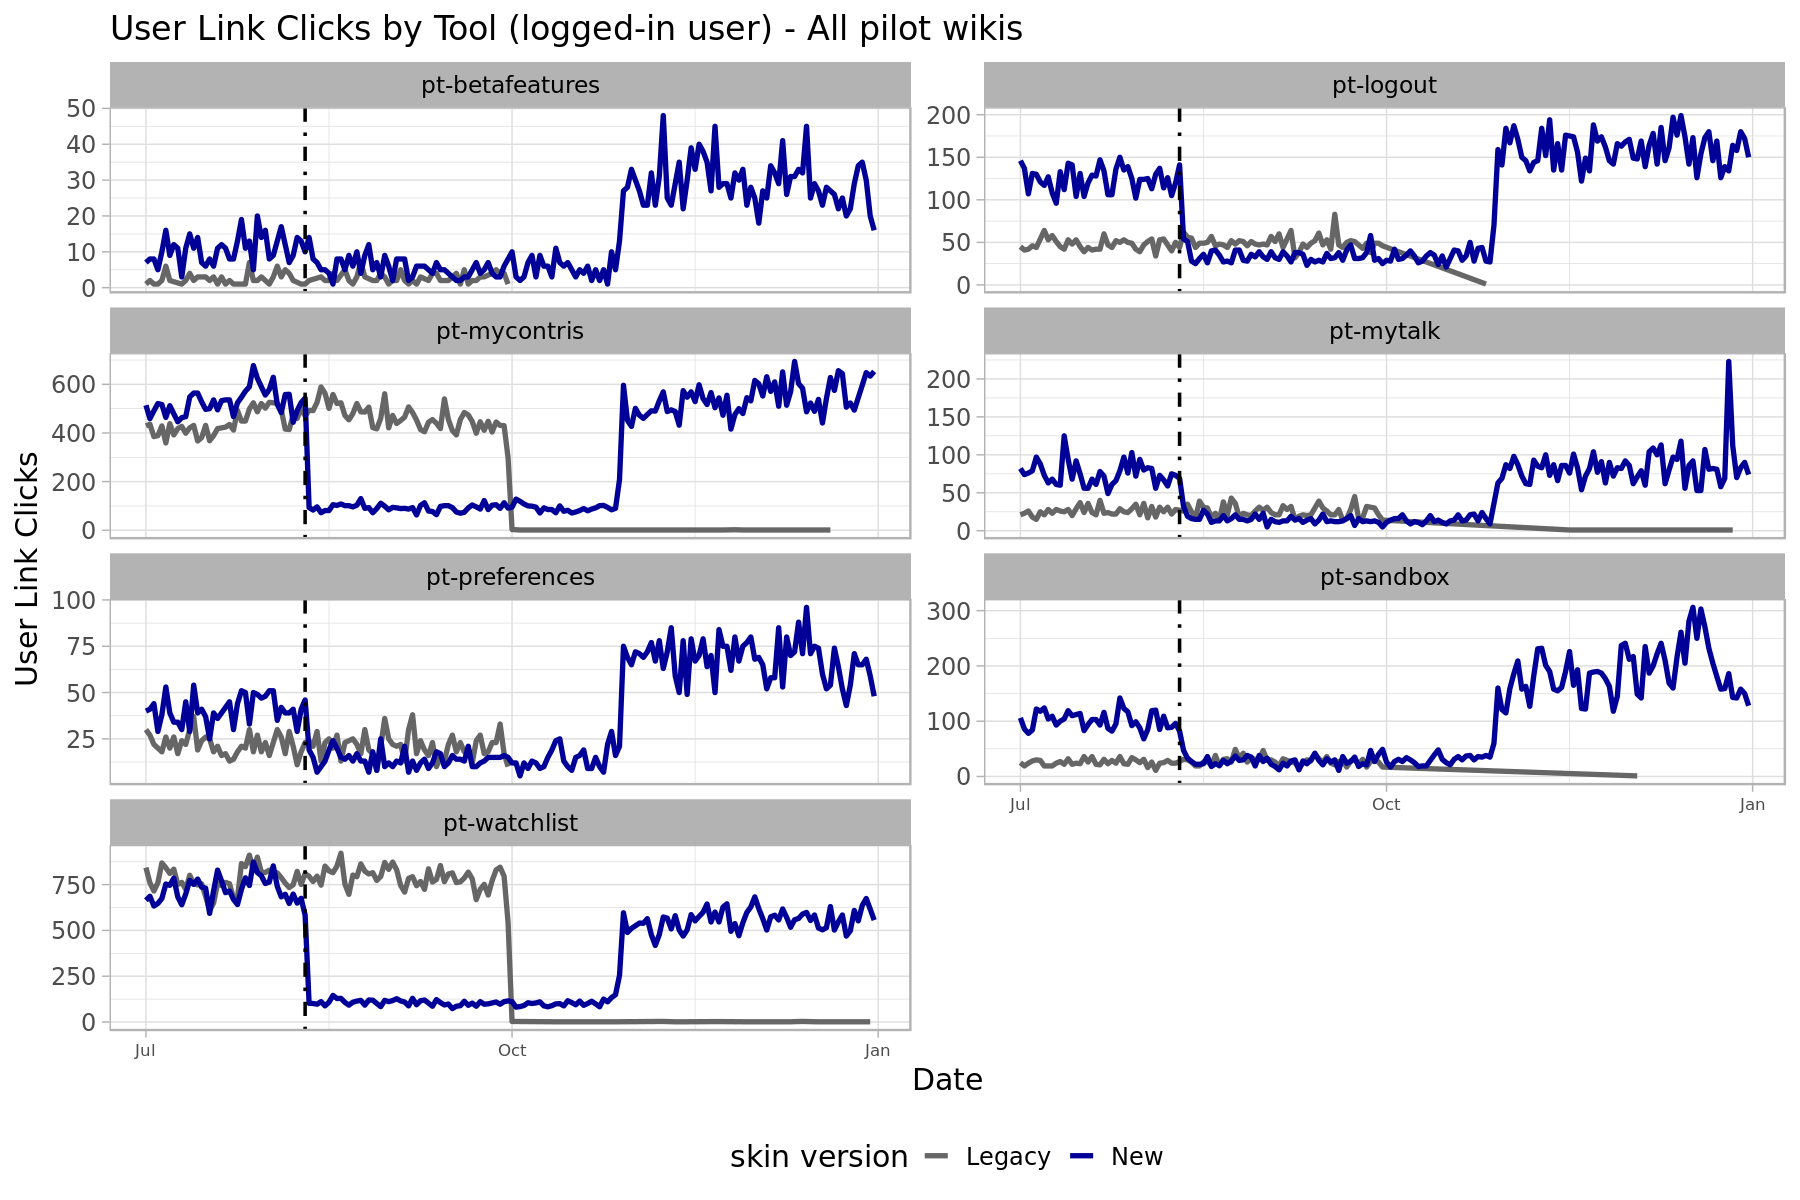

In [76]:
tool_g <- ggplot(data=df_tool,
                        mapping=aes(x=event_date, y=user_link_clicks, color=skinversion)) +
geom_line( size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
scale_color_manual(values= c("#666666", "#000099"), name = "skin version", labels = c("Legacy", "New"))  +
facet_wrap(~name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks by Tool (logged-in user) - All pilot wikis ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
tool_g 

__Summary__:

- The user link clicks from new skin users dropped since the user menu was deployed on 2021-08-10. It is expected. 
- The jump in Oct 28, 2021 is due to the change of sampling rate. https://phabricator.wikimedia.org/T292588


# Comparison of Pre and Post Deployment

In [80]:
# add column classifying pre and post deployment dates
df_user_link_clicks_prepost <- df_user_link_clicks %>%
    mutate(deployment = case_when(
        event_date >= '2021-07-13' & event_date <= '2021-08-09'  ~ 'pre',
        event_date >= '2021-08-10' & event_date <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
    filter((deployment!='NA')&(isanon=='false')& (name!='ui.dropdown-p-personal')&(skinversion==2)) %>%
    group_by(wiki_name, deployment, name,isanon, skinversion) %>%
    summarize(sum_clicks = sum(clicks),  .groups = 'drop')

In [81]:
head(df_user_link_clicks_prepost)

wiki_name        deployment name           isanon skinversion sum_clicks
1 Basque Wikipedia post       pt-logout      false  2           13        
2 Basque Wikipedia post       pt-mycontris   false  2            8        
3 Basque Wikipedia post       pt-preferences false  2            4        
4 Basque Wikipedia post       pt-sandbox     false  2            6        
5 Basque Wikipedia post       pt-watchlist   false  2           12        
6 Basque Wikipedia pre        pt-logout      false  2           66

In [82]:
df_user_link_clicks_prepost$deployment <- factor(df_user_link_clicks_prepost$deployment,levels = c("pre", "post"))

## Watchlist

In [83]:
watchlist_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-watchlist') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Watchlist",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
           # axis.title.x=element_blank(),
           # axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

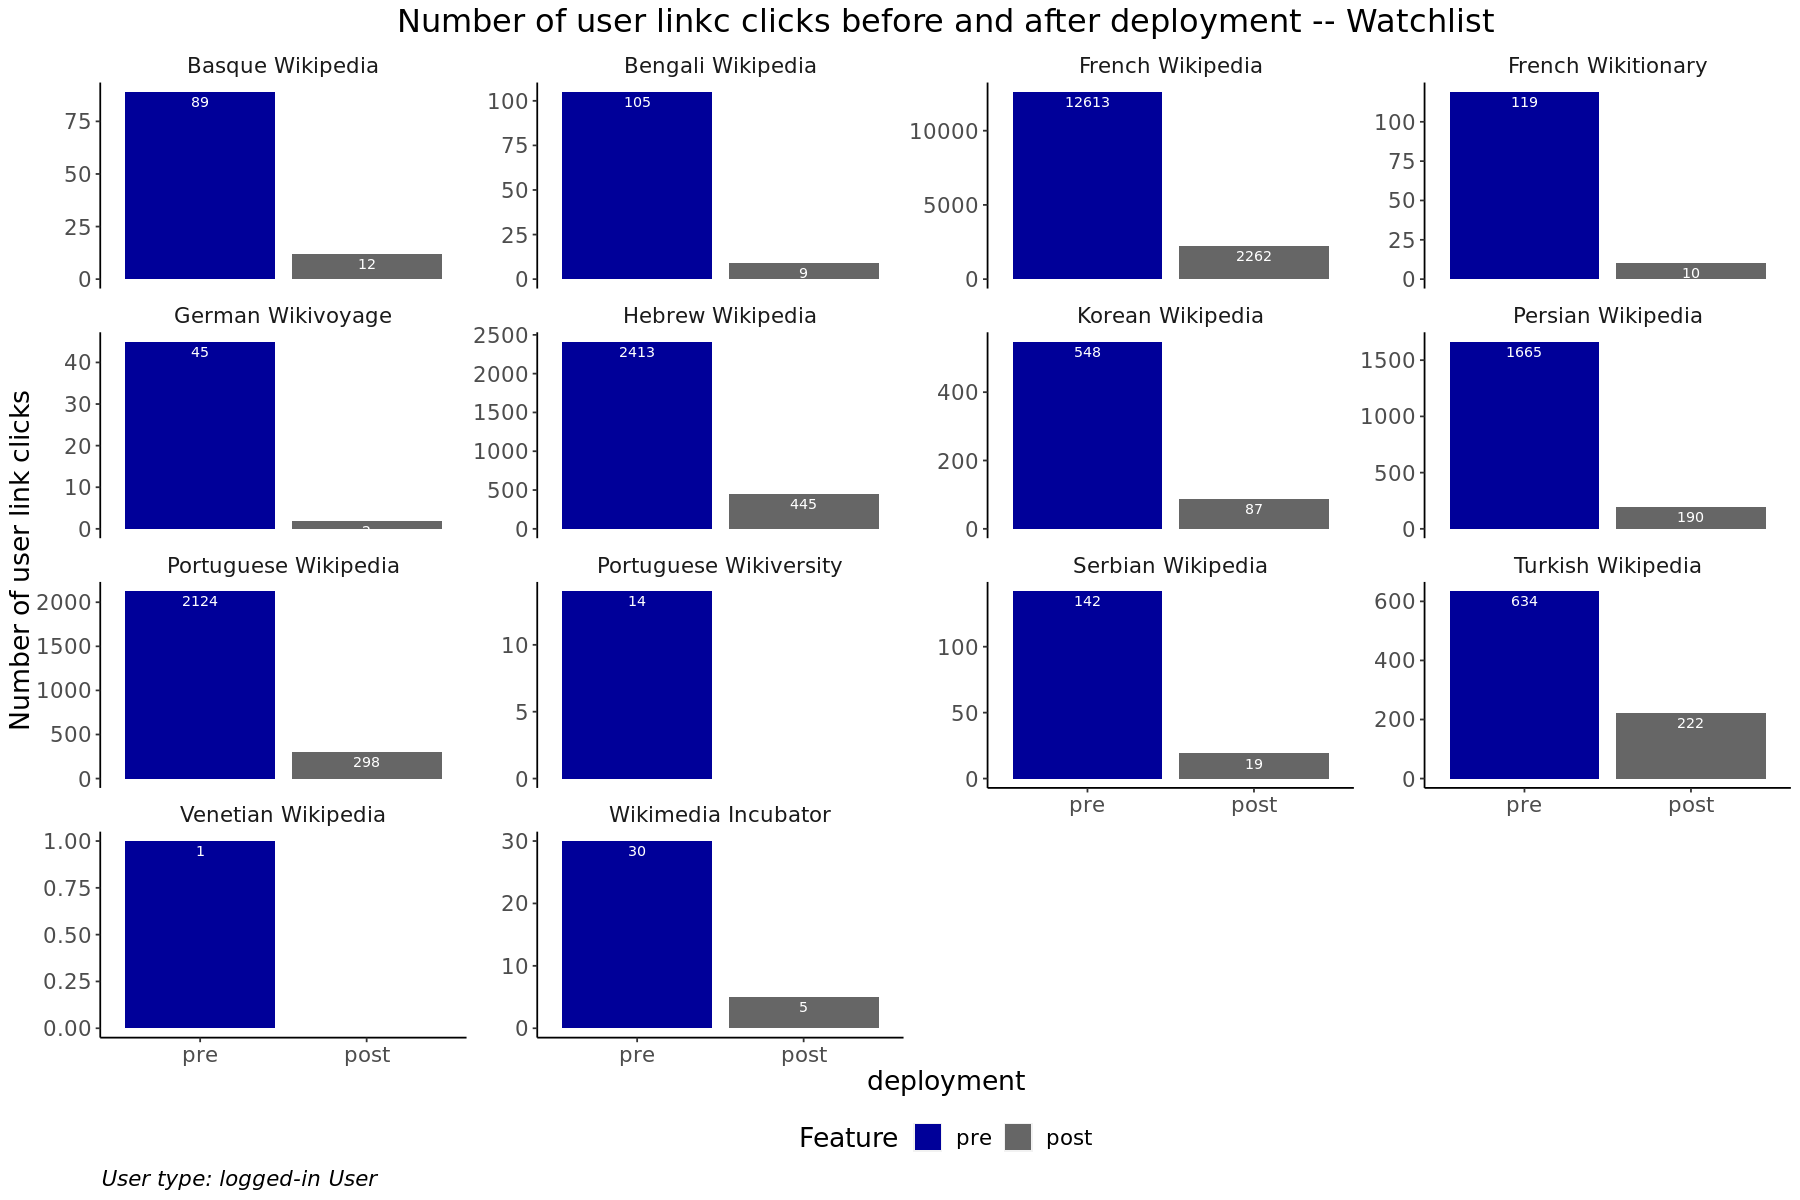

In [84]:
watchlist_clicks_barchart

__Determin the percentage of changes__

In [85]:
# determine percent change

df_watchlist_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-watchlist') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

In [86]:
df_watchlist_clicks_prepost_w

wiki_name              post pre   pct_change
1  Basque Wikipedia         12    89 -86.52    
2  Bengali Wikipedia         9   105 -91.43    
3  French Wikipedia       2262 12613 -82.07    
4  French Wikitionary       10   119 -91.60    
5  German Wikivoyage         2    45 -95.56    
6  Hebrew Wikipedia        445  2413 -81.56    
7  Korean Wikipedia         87   548 -84.12    
8  Persian Wikipedia       190  1665 -88.59    
9  Portuguese Wikipedia    298  2124 -85.97    
10 Portuguese Wikiversity   NA    14     NA    
11 Serbian Wikipedia        19   142 -86.62    
12 Turkish Wikipedia       222   634 -64.98    
13 Venetian Wikipedia       NA     1     NA    
14 Wikimedia Incubator       5    30 -83.33

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


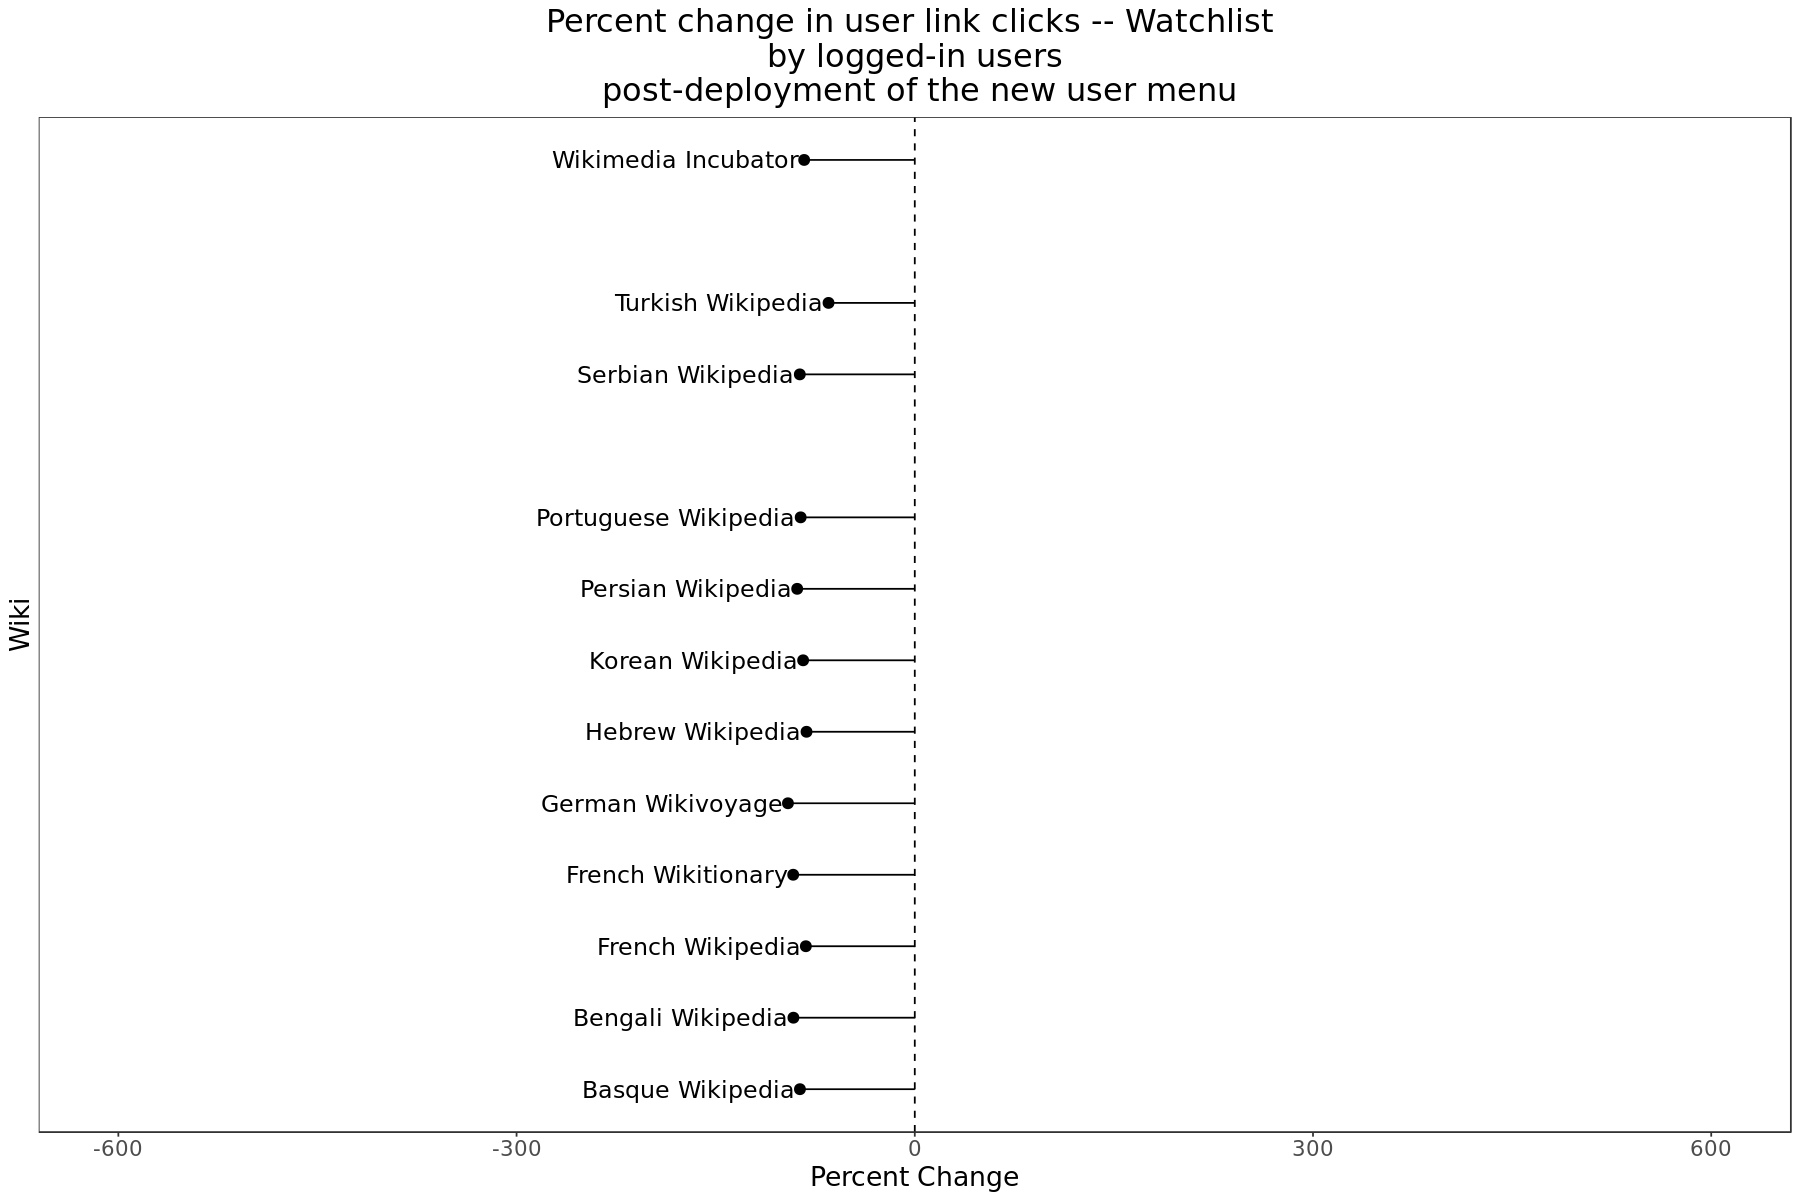

In [87]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_watchlist_g <- df_watchlist_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Watchlist \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_watchlist_g 



__Average percent change__


Average of the percent changes observed on each early adopter wiki

In [88]:
mean((filter(df_watchlist_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -85.19583

## Talk


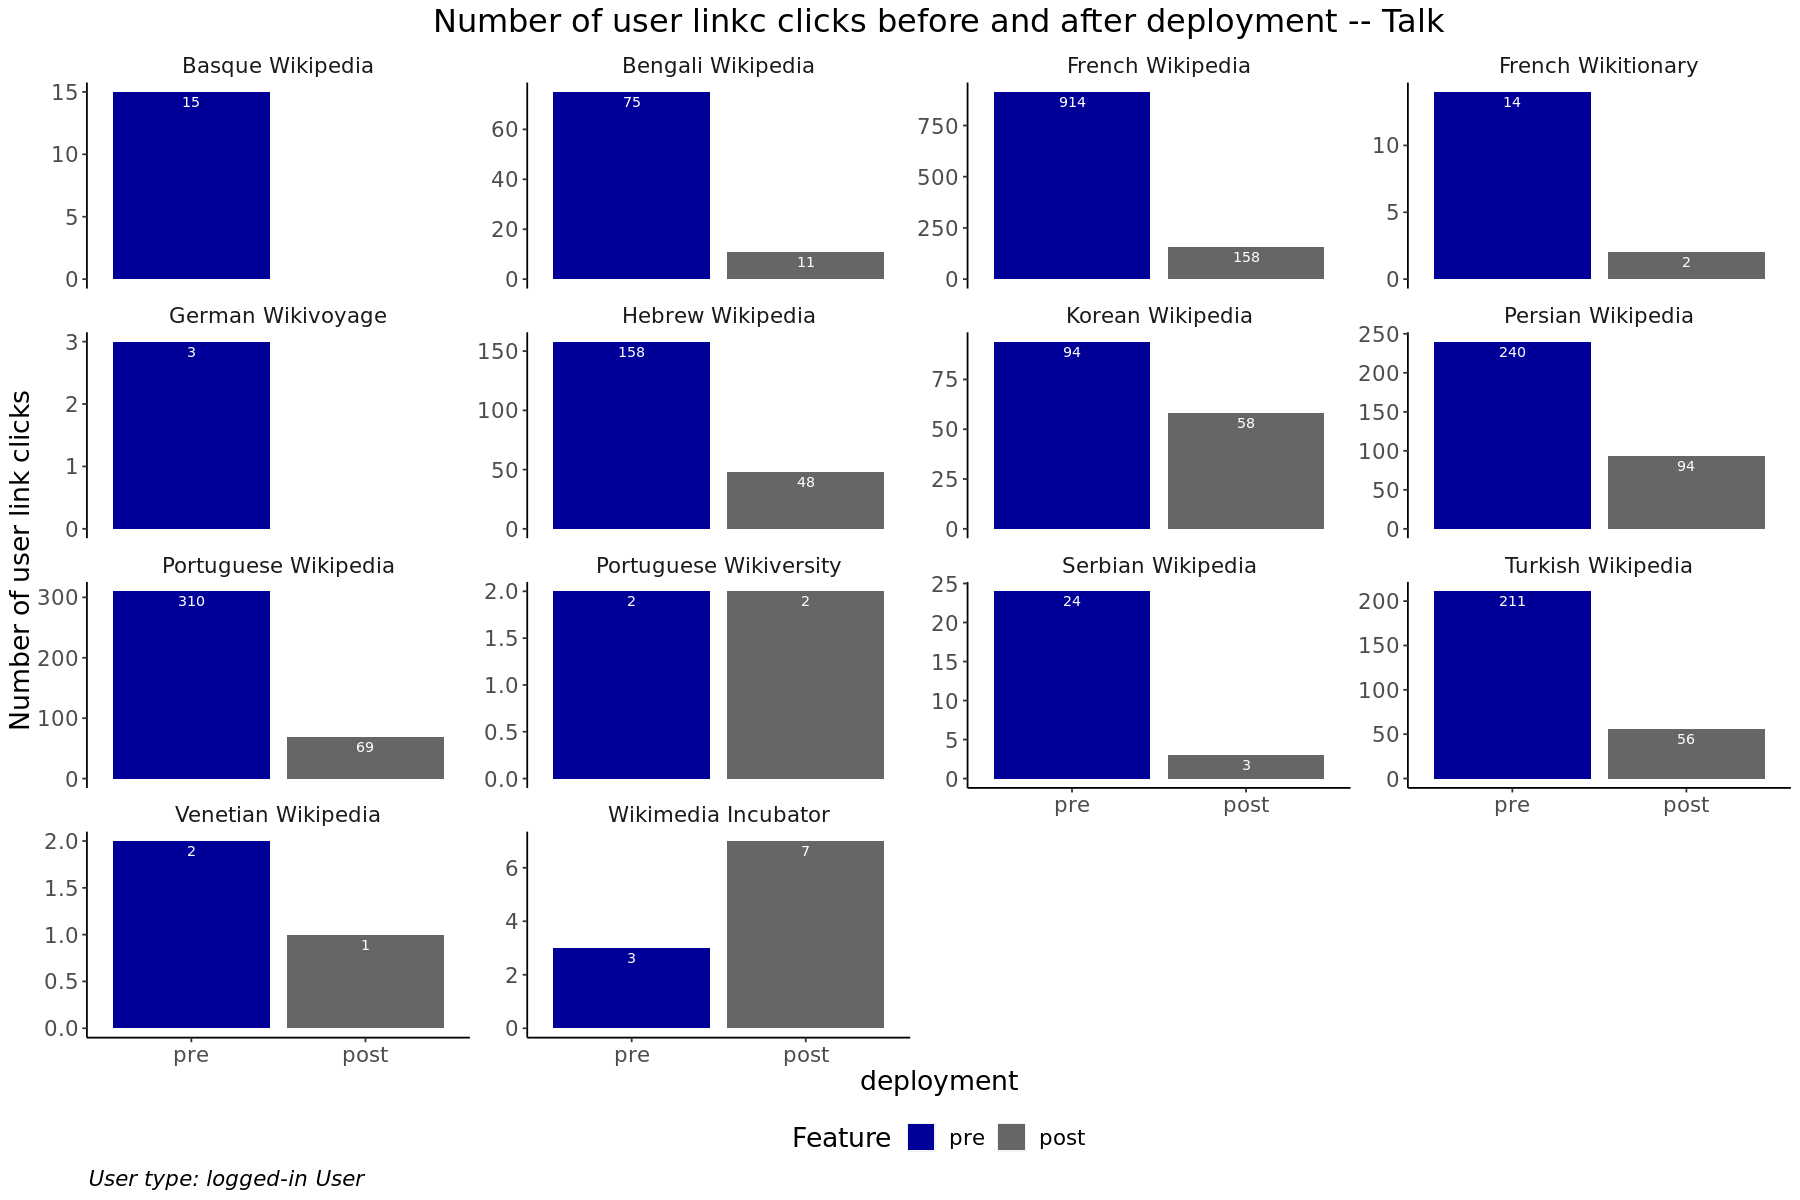

In [36]:
talk_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-mytalk') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Talk",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

talk_clicks_barchart

__Determin the percentage of changes__

In [37]:
# determine percent change

df_talk_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-mytalk') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_talk_clicks_prepost_w

wiki_name              pre post pct_change
1  Basque Wikipedia        15  NA      NA    
2  Bengali Wikipedia       75  11  -85.33    
3  French Wikipedia       914 158  -82.71    
4  French Wikitionary      14   2  -85.71    
5  German Wikivoyage        3  NA      NA    
6  Hebrew Wikipedia       158  48  -69.62    
7  Korean Wikipedia        94  58  -38.30    
8  Persian Wikipedia      240  94  -60.83    
9  Portuguese Wikipedia   310  69  -77.74    
10 Portuguese Wikiversity   2   2    0.00    
11 Serbian Wikipedia       24   3  -87.50    
12 Turkish Wikipedia      211  56  -73.46    
13 Venetian Wikipedia       2   1  -50.00    
14 Wikimedia Incubator      3   7  133.33

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


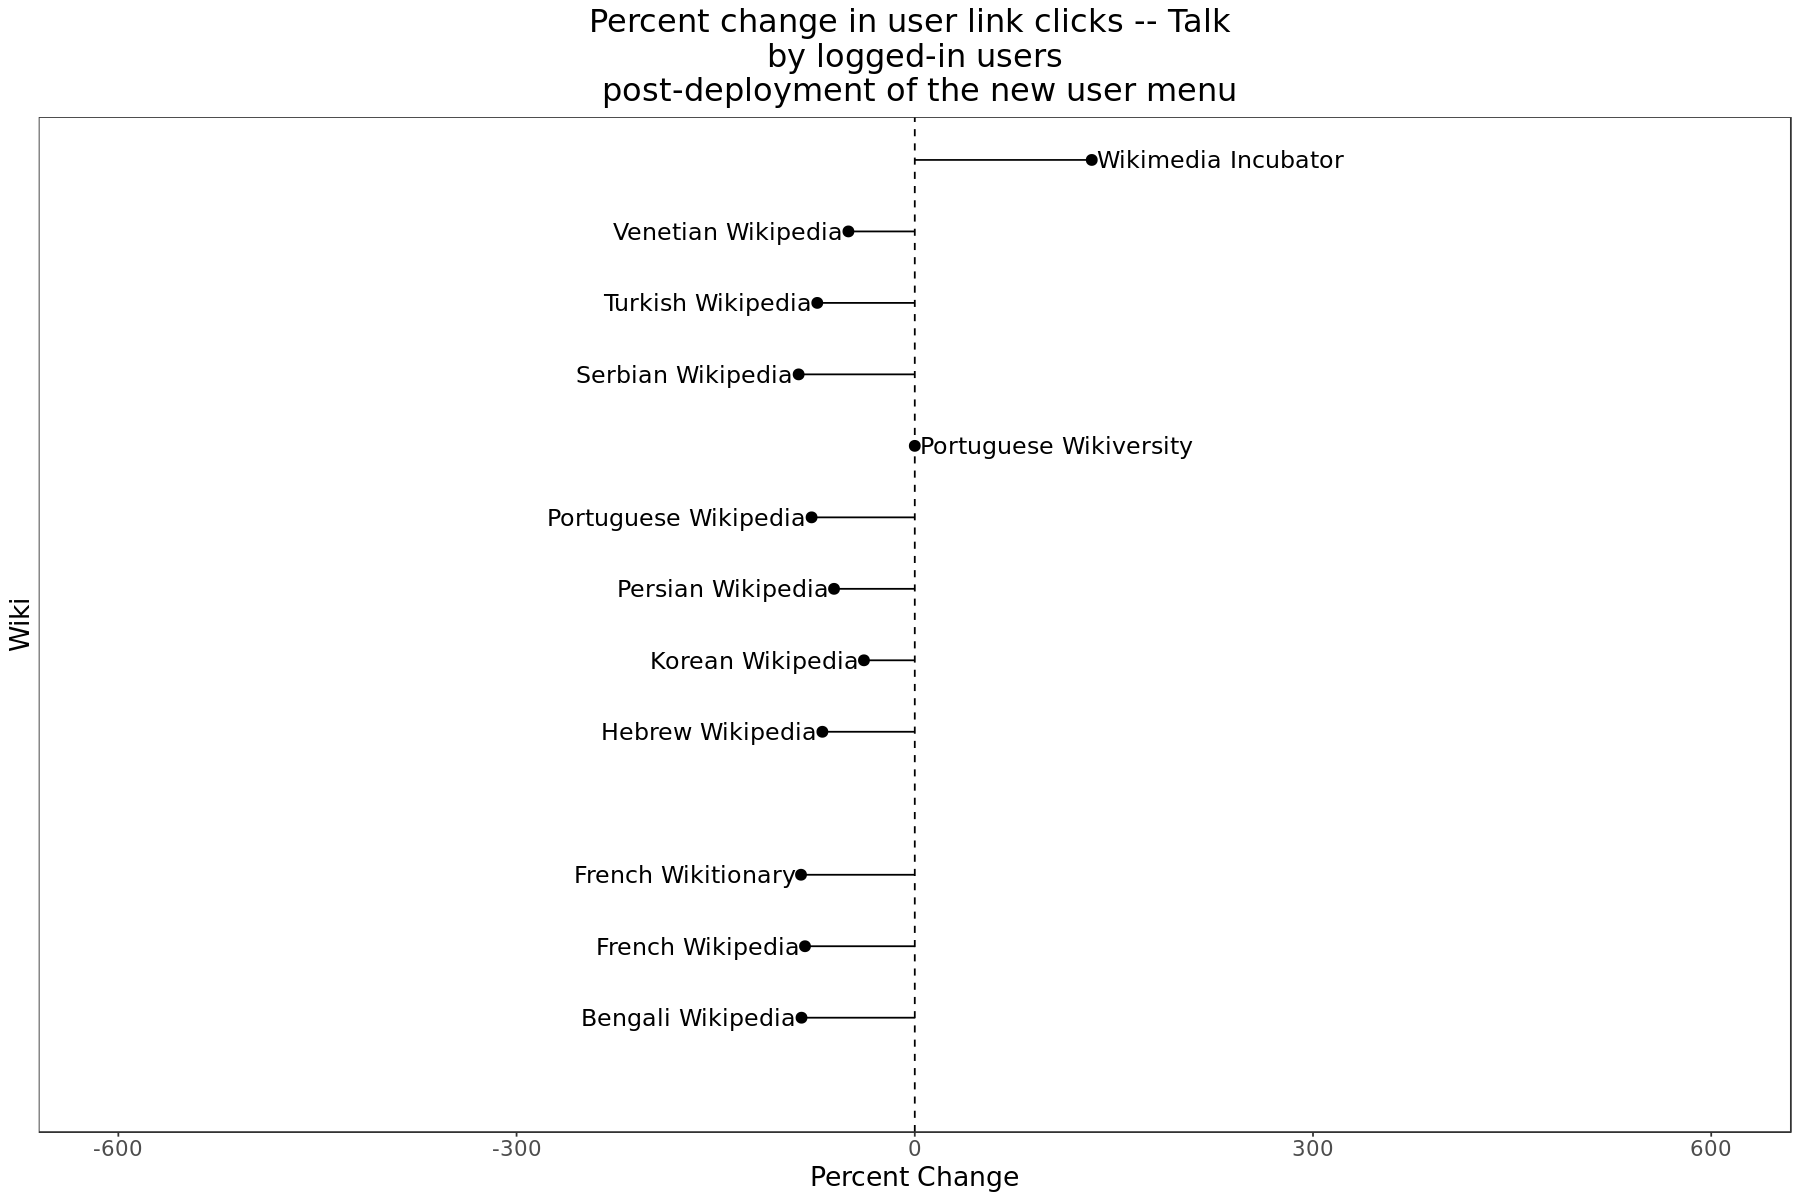

In [38]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_talk_g <- df_talk_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Talk \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_talk_g 


__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [39]:
mean((filter(df_talk_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -48.15583

## Sandbox


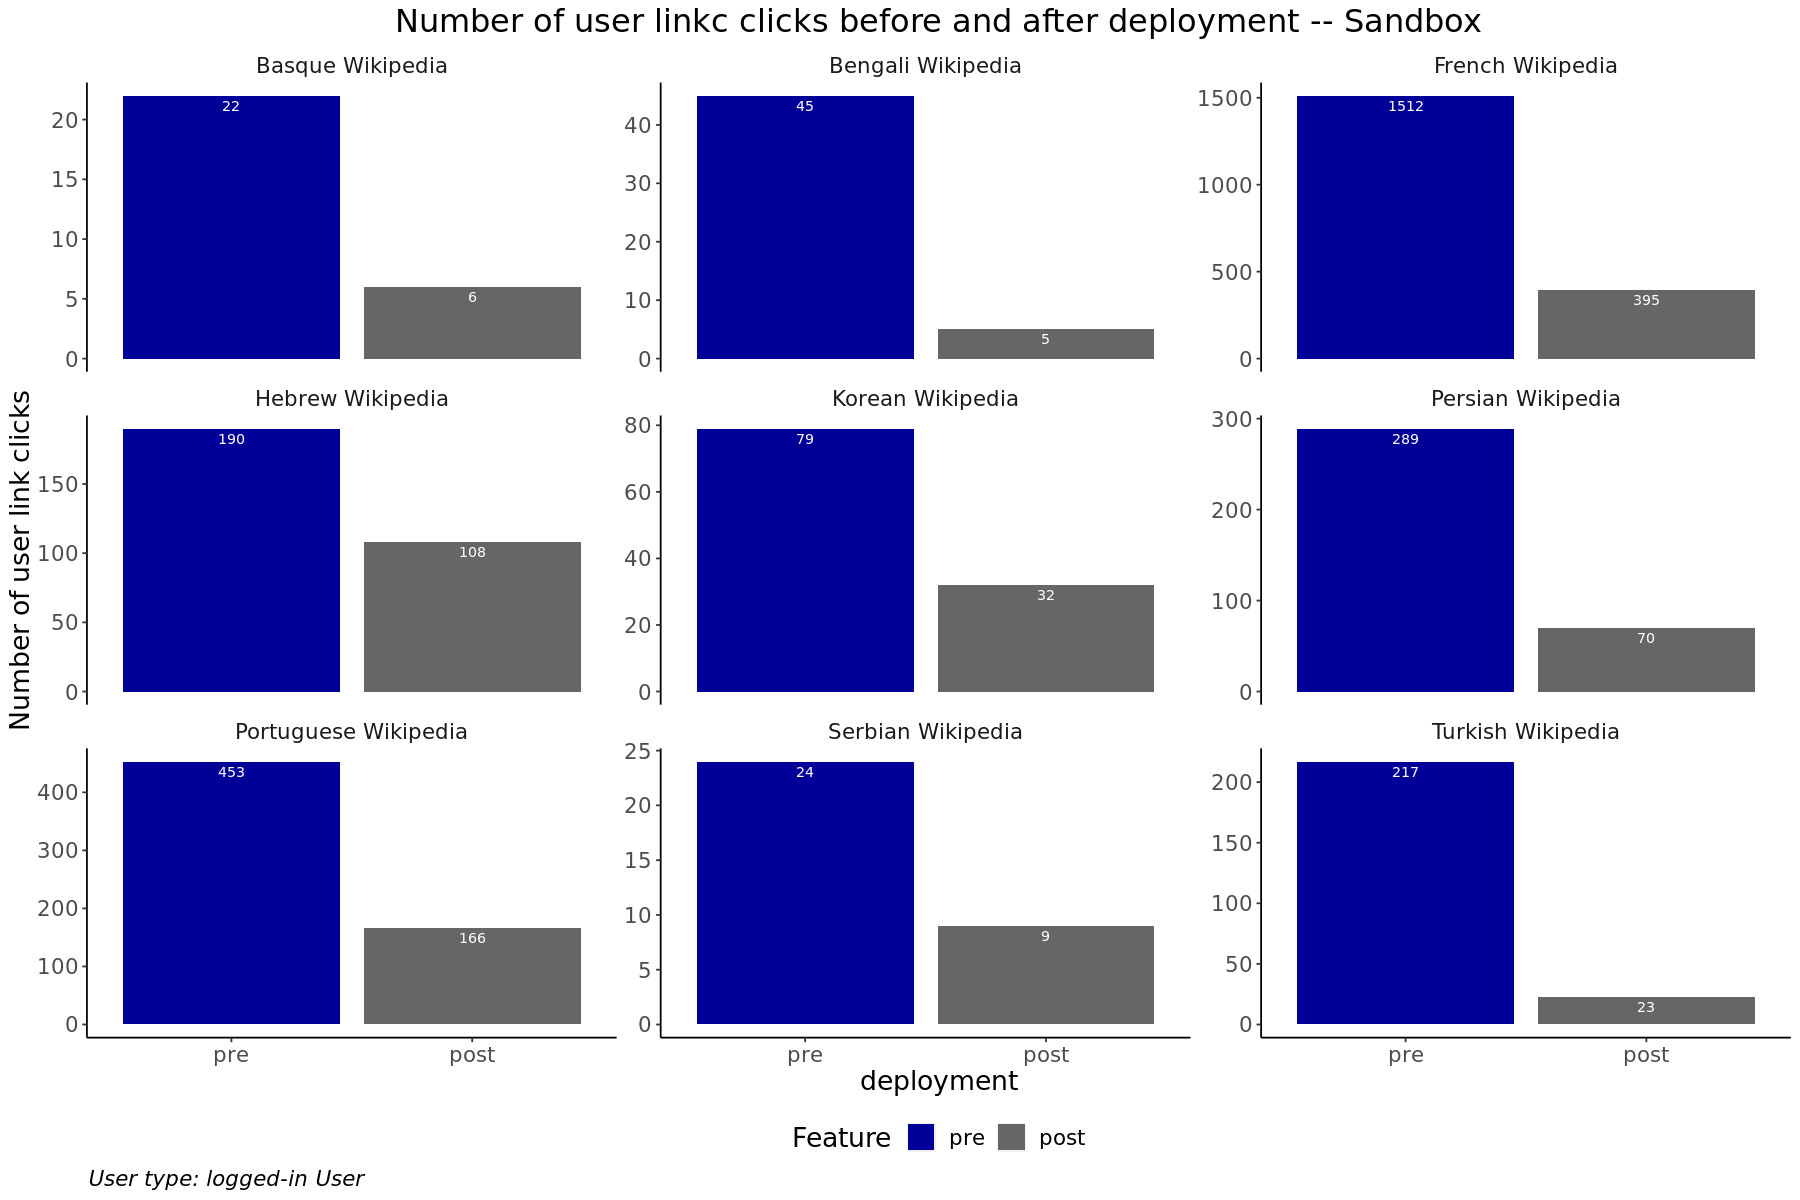

In [40]:
sandbox_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-sandbox') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Sandbox",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

sandbox_clicks_barchart



__Determin the percentage of changes__


In [41]:

# determine percent change

df_sandbox_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-sandbox') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_sandbox_clicks_prepost_w


wiki_name            post pre  pct_change
1 Basque Wikipedia       6    22 -72.73    
2 Bengali Wikipedia      5    45 -88.89    
3 French Wikipedia     395  1512 -73.88    
4 Hebrew Wikipedia     108   190 -43.16    
5 Korean Wikipedia      32    79 -59.49    
6 Persian Wikipedia     70   289 -75.78    
7 Portuguese Wikipedia 166   453 -63.36    
8 Serbian Wikipedia      9    24 -62.50    
9 Turkish Wikipedia     23   217 -89.40

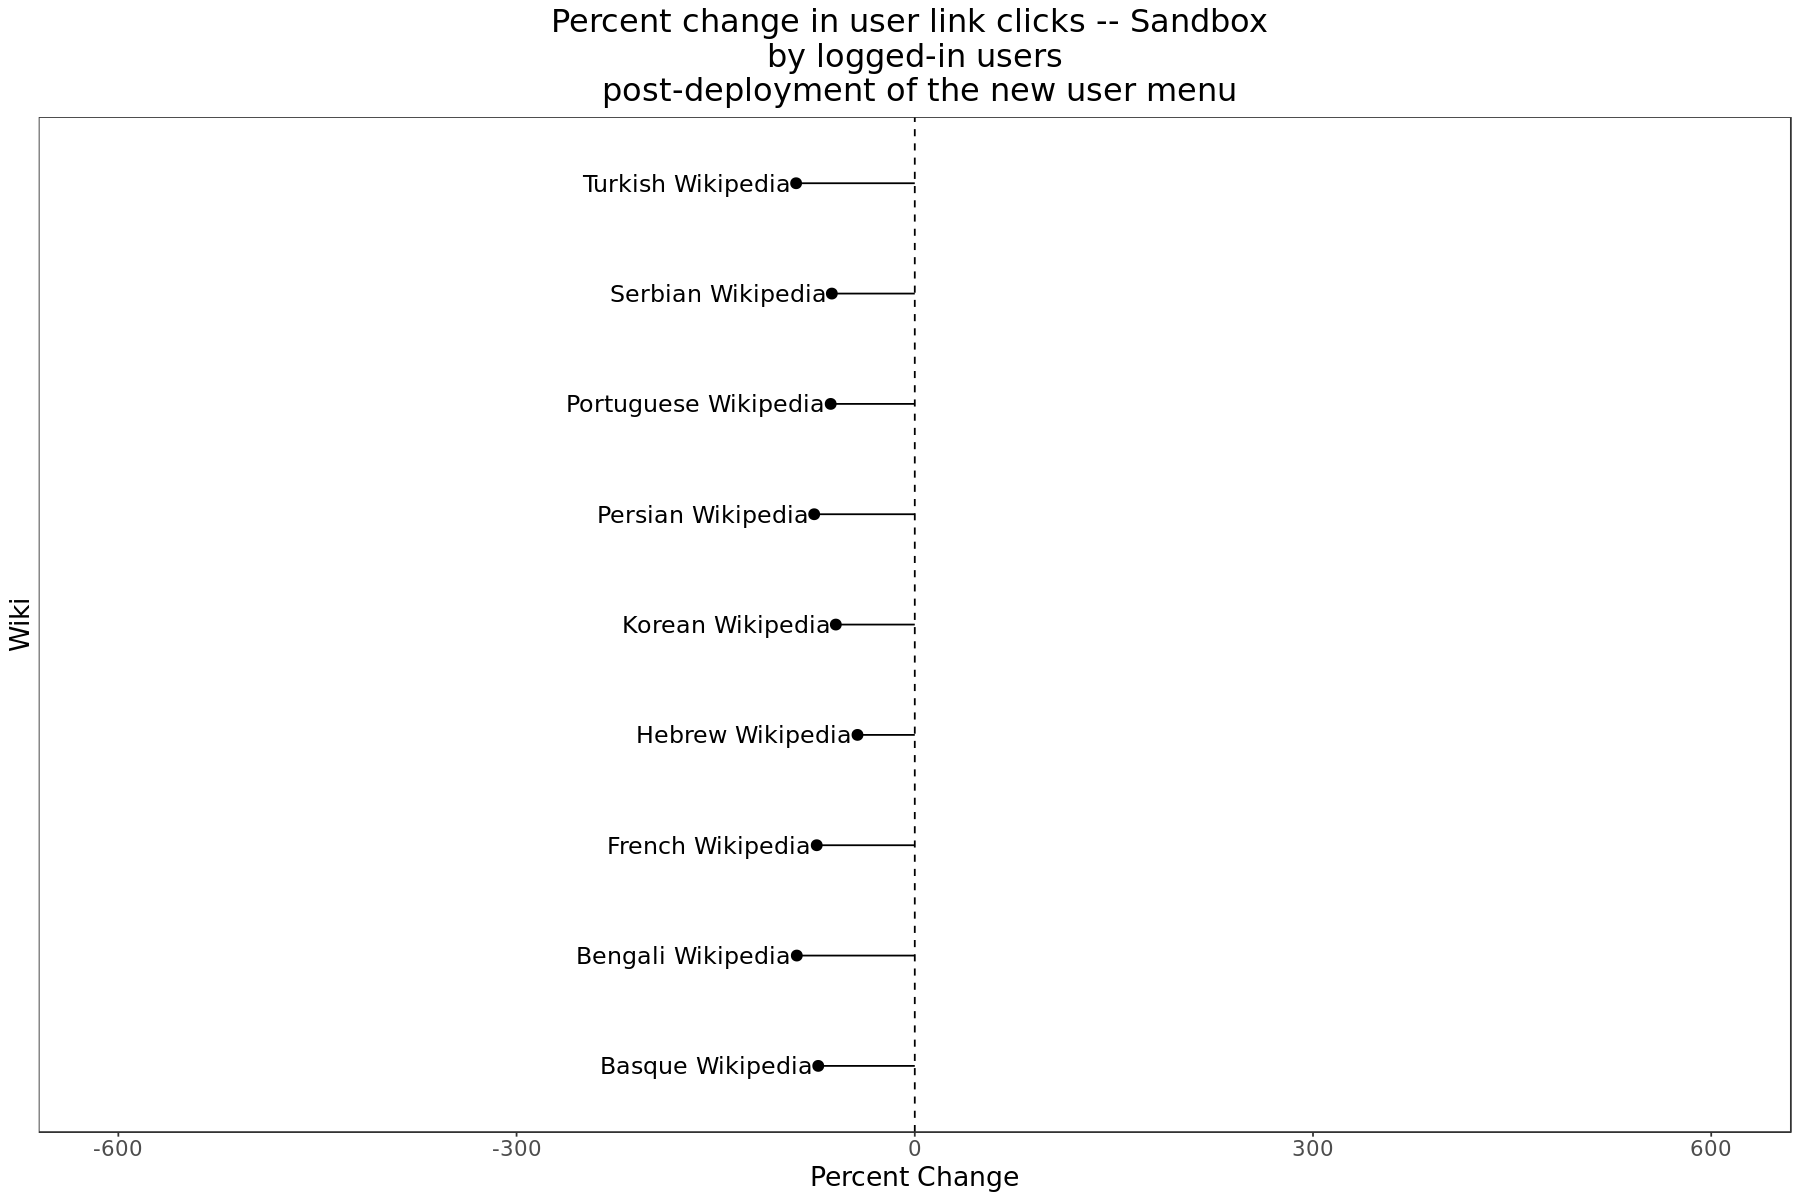

In [42]:

# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_sandbox_g <- df_sandbox_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Sandbox \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_sandbox_g 




__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [43]:


mean((filter(df_sandbox_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -69.91

## Preferences


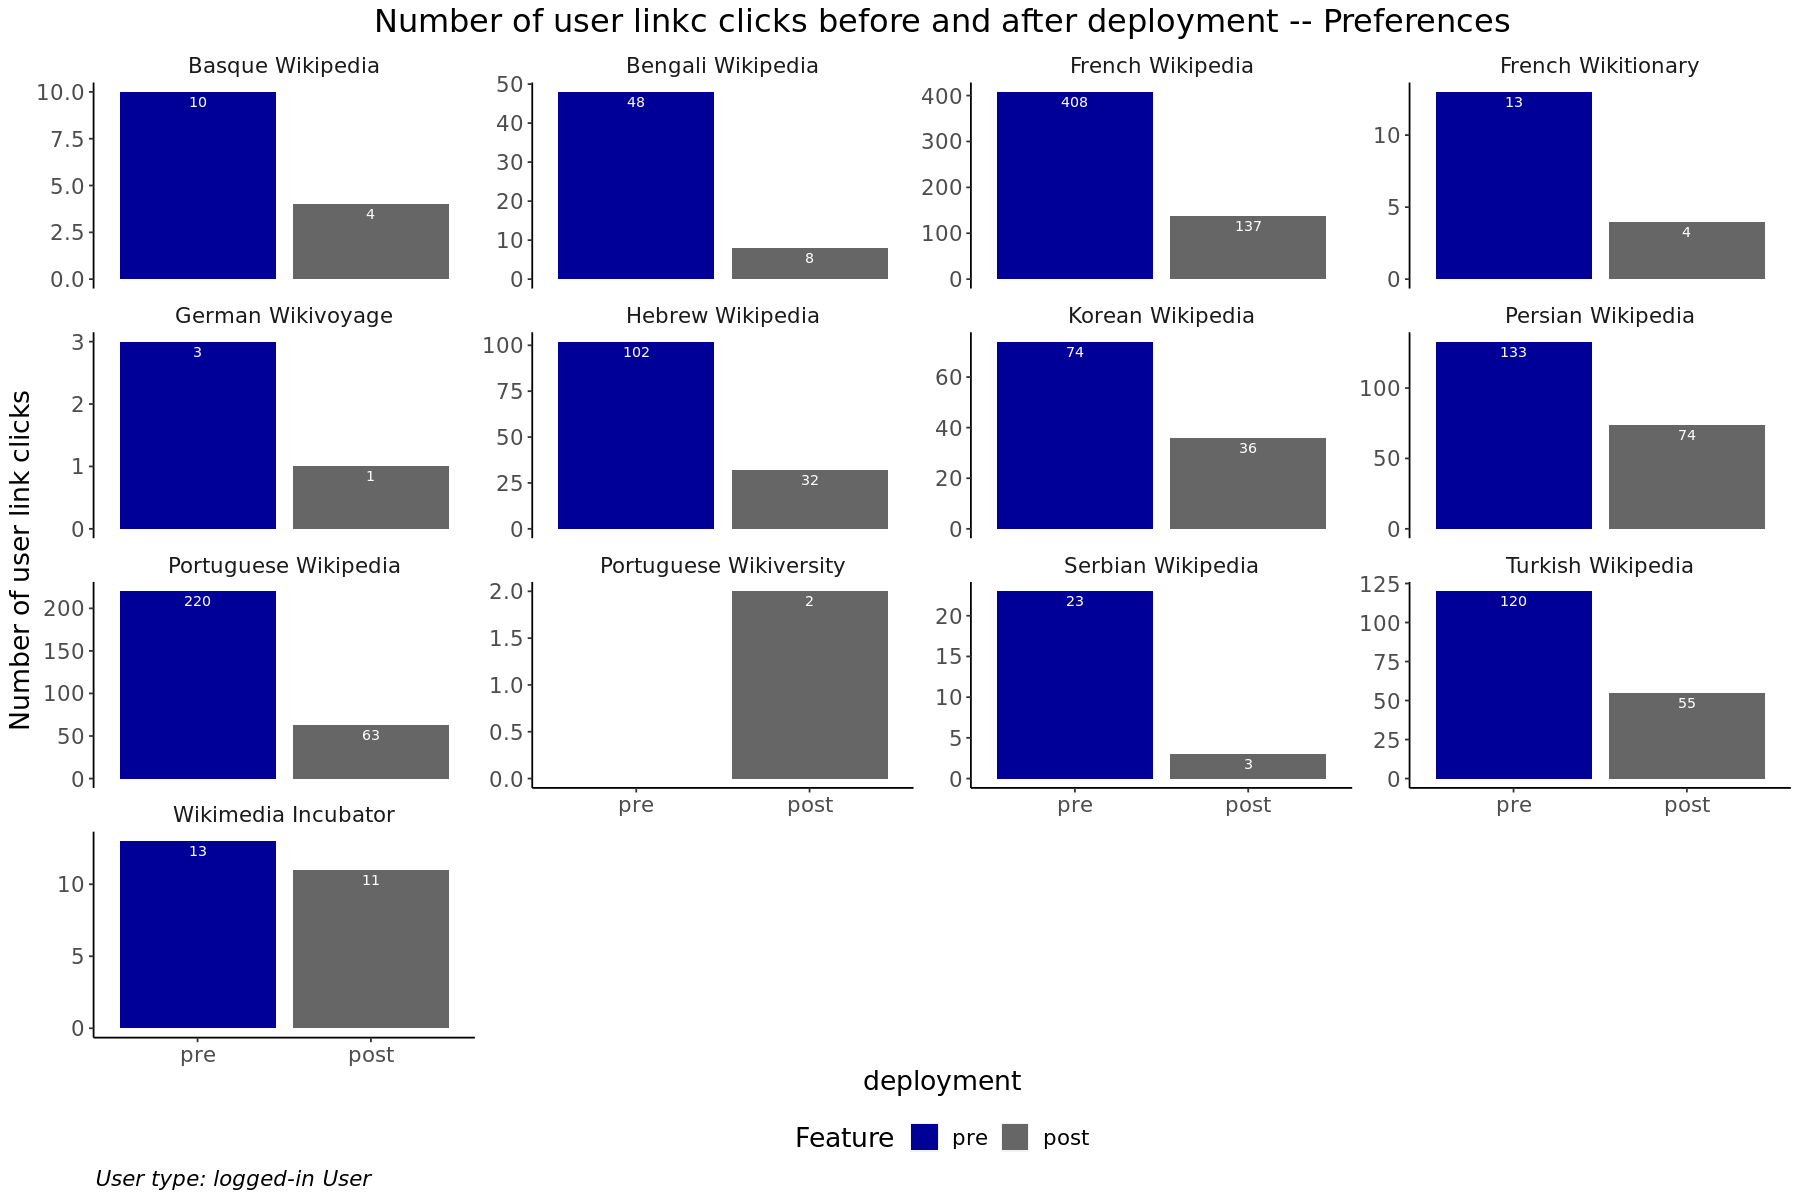

In [44]:
pref_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-preferences') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Preferences",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
pref_clicks_barchart

__Determin the percentage of changes__

In [45]:

# determine percent change

df_pref_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-preferences') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_pref_clicks_prepost_w

wiki_name              post pre pct_change
1  Basque Wikipedia         4   10 -60.00    
2  Bengali Wikipedia        8   48 -83.33    
3  French Wikipedia       137  408 -66.42    
4  French Wikitionary       4   13 -69.23    
5  German Wikivoyage        1    3 -66.67    
6  Hebrew Wikipedia        32  102 -68.63    
7  Korean Wikipedia        36   74 -51.35    
8  Persian Wikipedia       74  133 -44.36    
9  Portuguese Wikipedia    63  220 -71.36    
10 Portuguese Wikiversity   2   NA     NA    
11 Serbian Wikipedia        3   23 -86.96    
12 Turkish Wikipedia       55  120 -54.17    
13 Wikimedia Incubator     11   13 -15.38

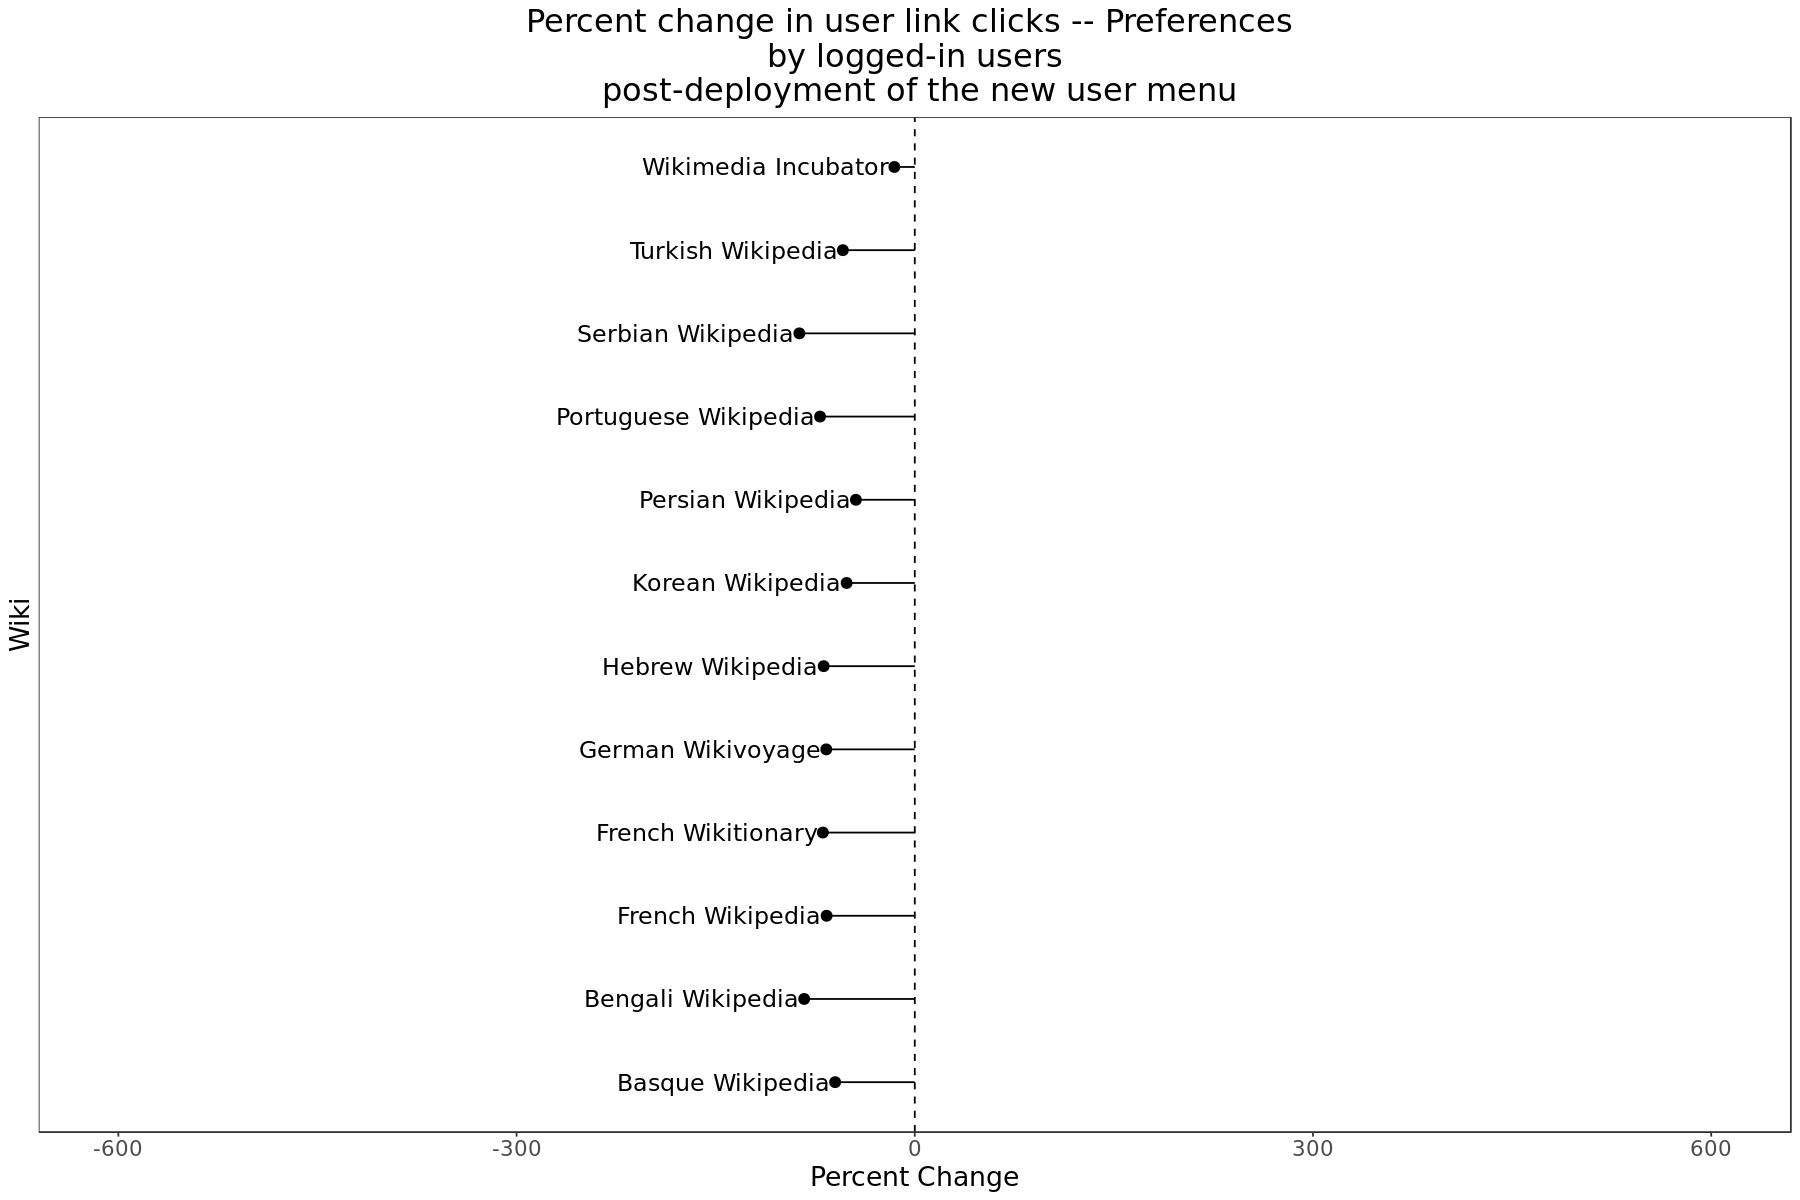

In [46]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_pref_g <- df_pref_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Preferences \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_pref_g 






__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [47]:
mean((filter(df_pref_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -61.48833

## Beta


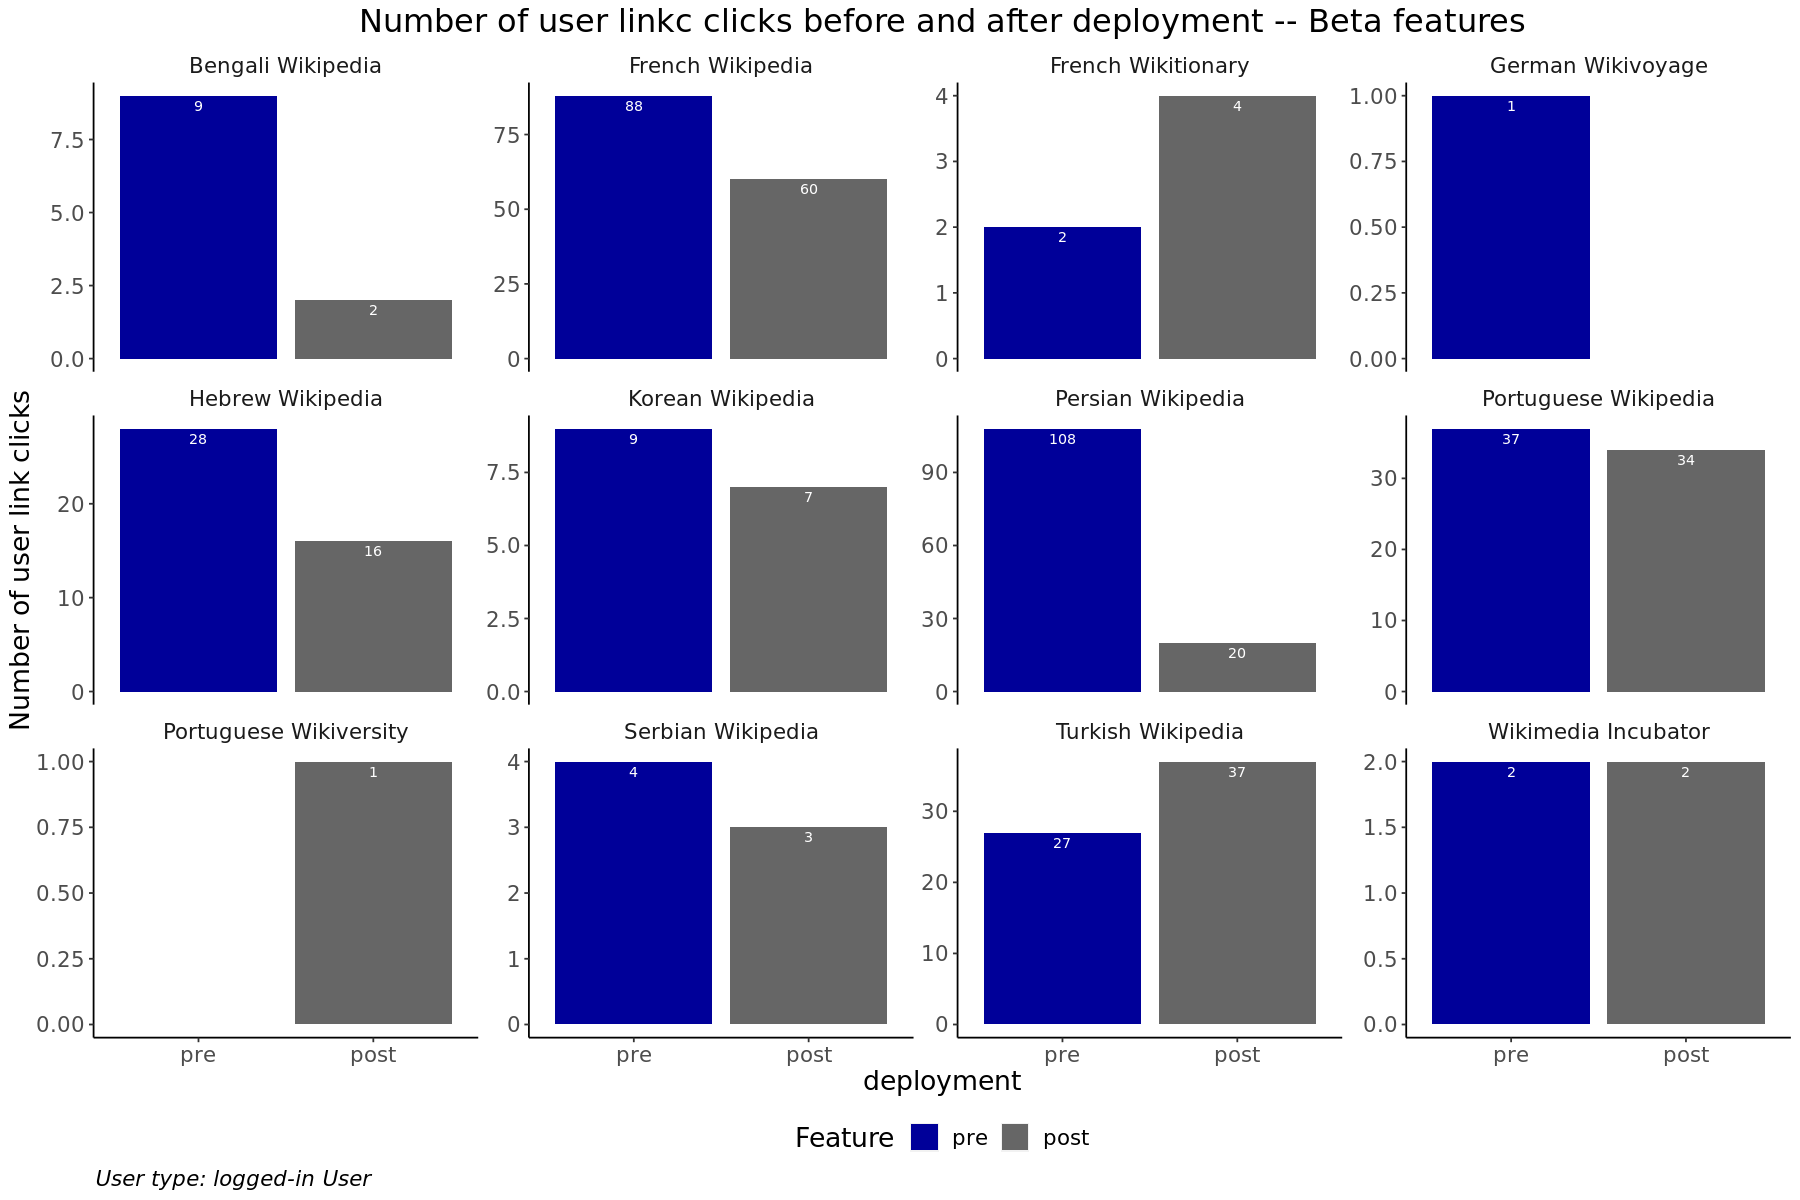

In [48]:
beta_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-betafeatures') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Beta features",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

beta_clicks_barchart



__Determin the percentage of changes__

In [49]:


# determine percent change

df_beta_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-betafeatures') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_beta_clicks_prepost_w






wiki_name              post pre pct_change
1  Bengali Wikipedia       2     9 -77.78    
2  French Wikipedia       60    88 -31.82    
3  French Wikitionary      4     2 100.00    
4  German Wikivoyage      NA     1     NA    
5  Hebrew Wikipedia       16    28 -42.86    
6  Korean Wikipedia        7     9 -22.22    
7  Persian Wikipedia      20   108 -81.48    
8  Portuguese Wikipedia   34    37  -8.11    
9  Portuguese Wikiversity  1    NA     NA    
10 Serbian Wikipedia       3     4 -25.00    
11 Turkish Wikipedia      37    27  37.04    
12 Wikimedia Incubator     2     2   0.00

Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


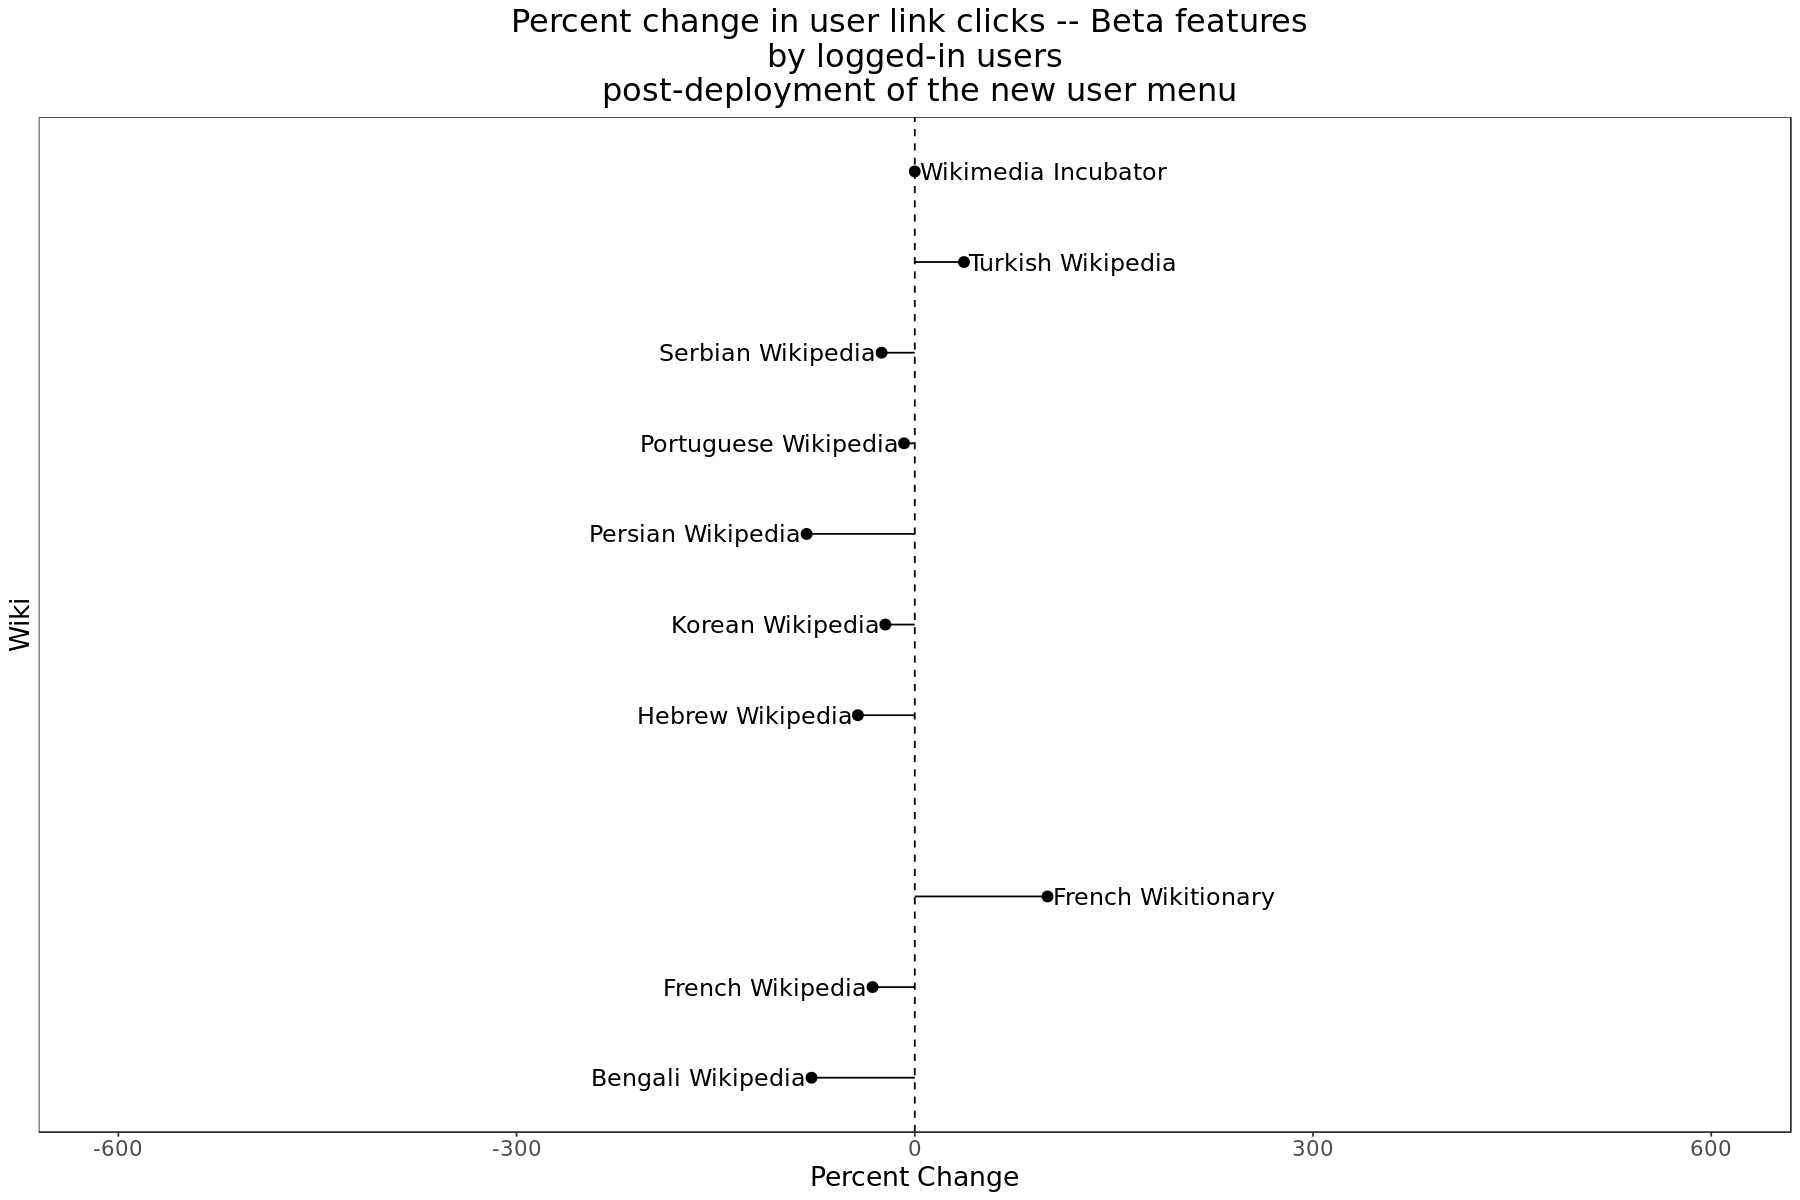

In [50]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_beta_g <- df_beta_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Beta features \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_beta_g 

__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [51]:


mean((filter(df_beta_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -15.223

## Contributions


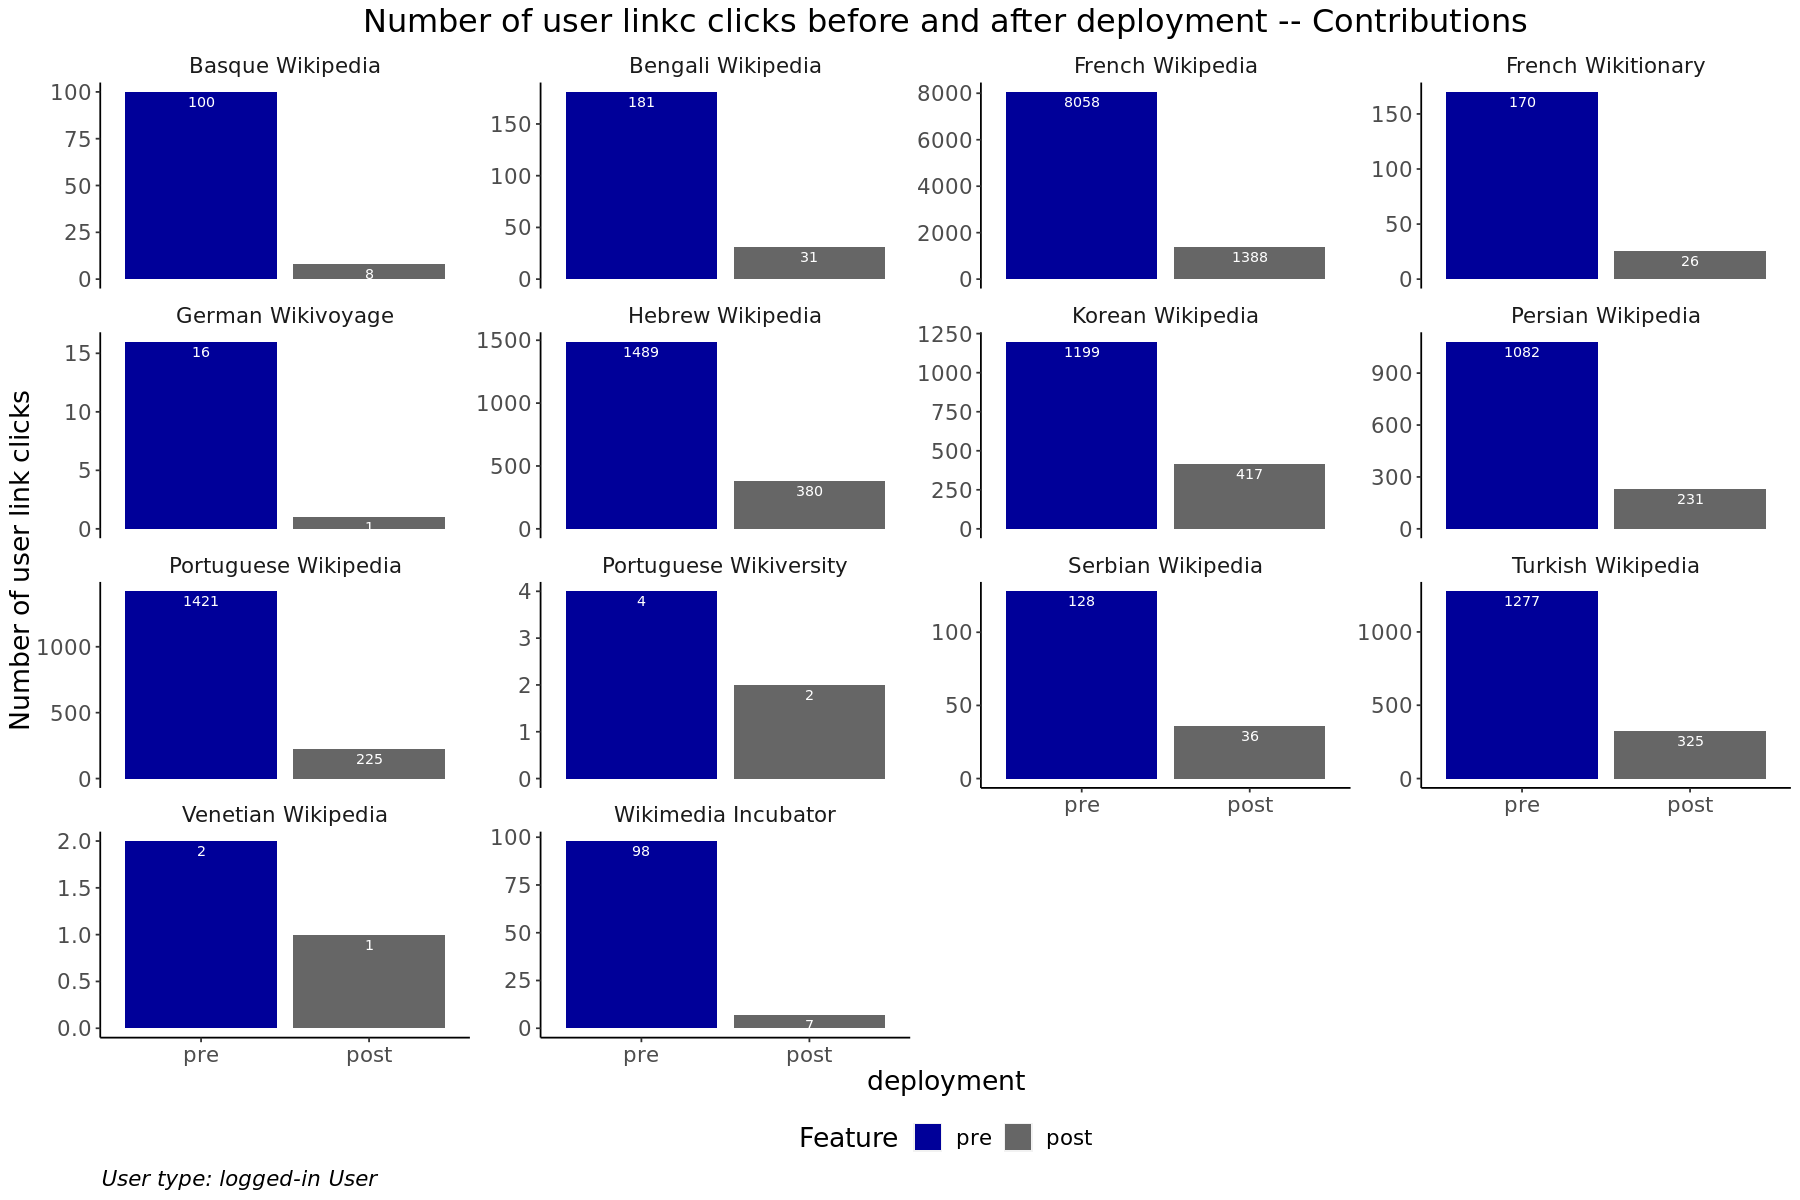

In [52]:
contris_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-mycontris') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Contributions",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

contris_clicks_barchart



__Determin the percentage of changes__

In [53]:
# determine percent change

df_contris_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-mycontris') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_contris_clicks_prepost_w

wiki_name              post pre  pct_change
1  Basque Wikipedia          8  100 -92.00    
2  Bengali Wikipedia        31  181 -82.87    
3  French Wikipedia       1388 8058 -82.77    
4  French Wikitionary       26  170 -84.71    
5  German Wikivoyage         1   16 -93.75    
6  Hebrew Wikipedia        380 1489 -74.48    
7  Korean Wikipedia        417 1199 -65.22    
8  Persian Wikipedia       231 1082 -78.65    
9  Portuguese Wikipedia    225 1421 -84.17    
10 Portuguese Wikiversity    2    4 -50.00    
11 Serbian Wikipedia        36  128 -71.88    
12 Turkish Wikipedia       325 1277 -74.55    
13 Venetian Wikipedia        1    2 -50.00    
14 Wikimedia Incubator       7   98 -92.86

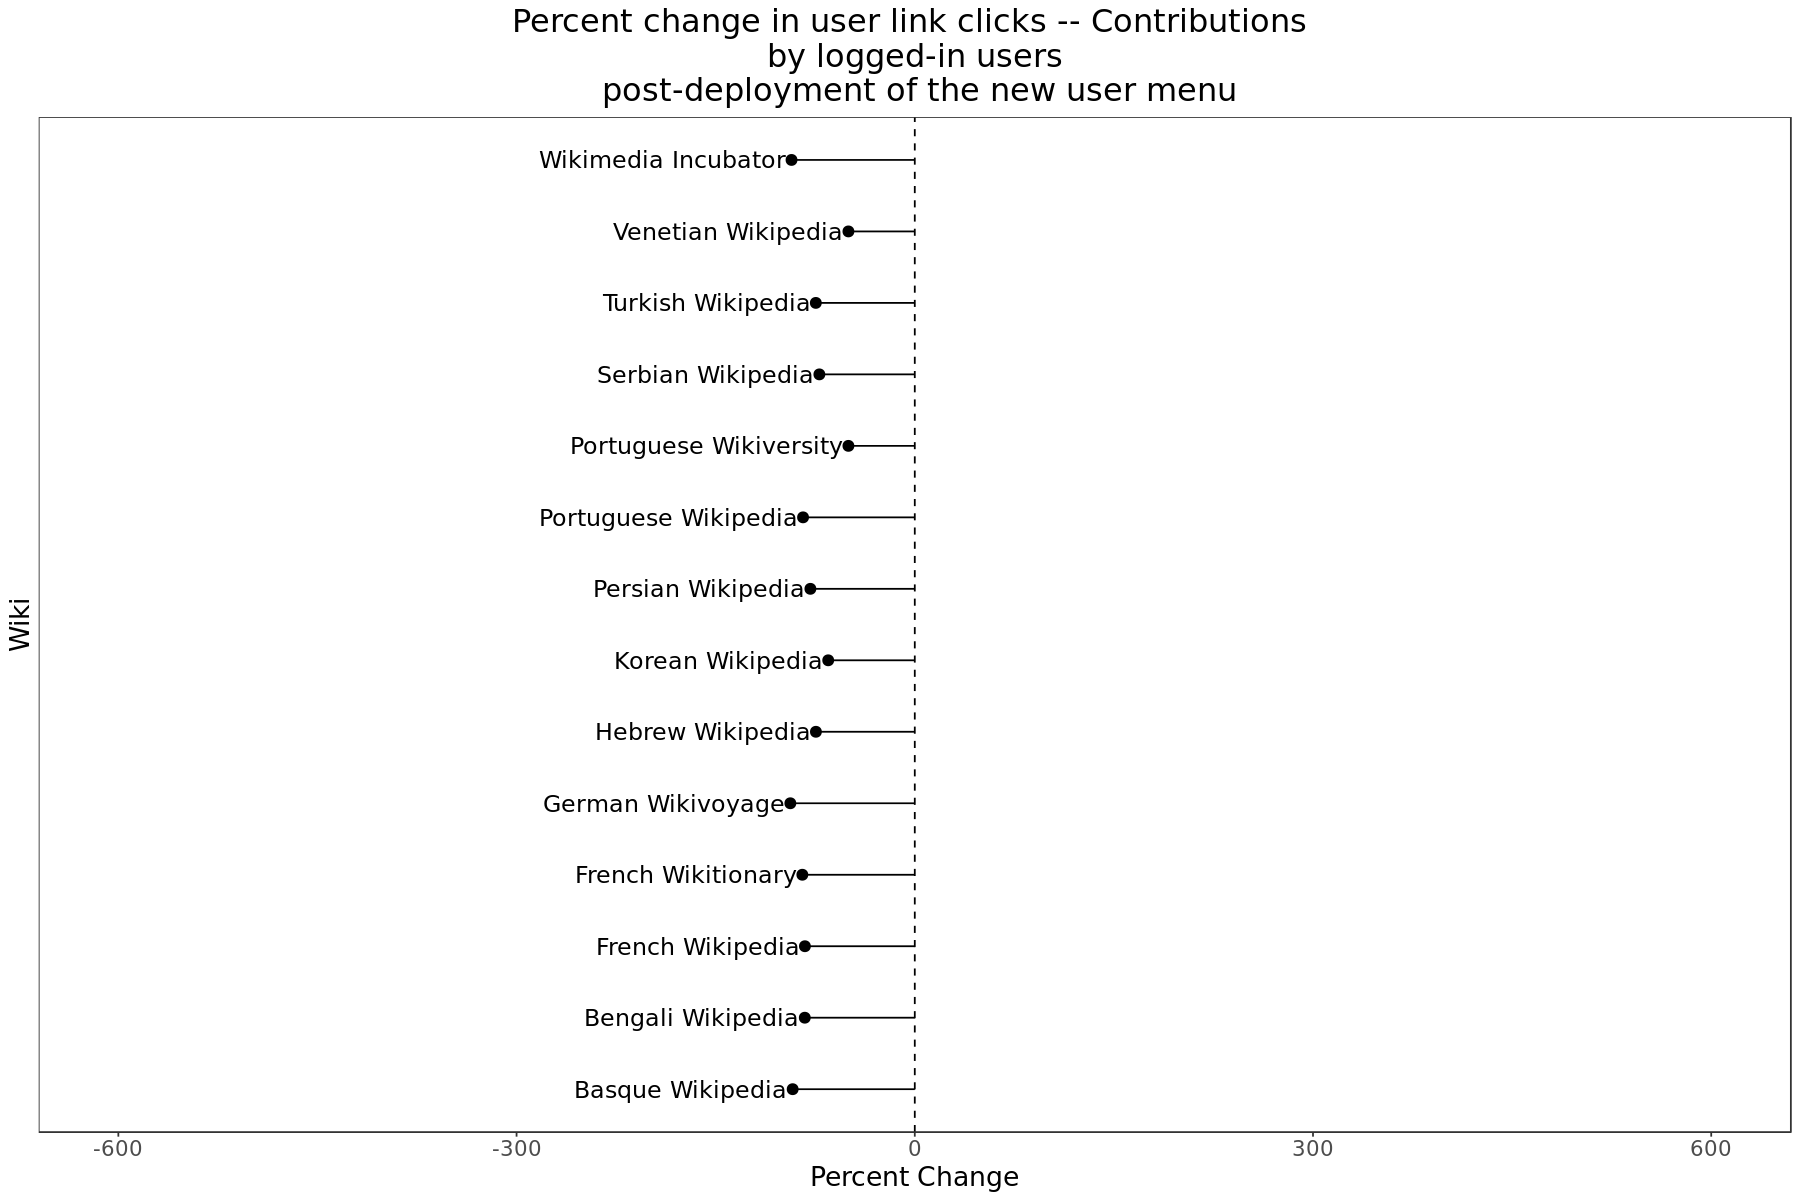

In [54]:

# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_contris_g <- df_contris_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Contributions \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_contris_g 







__Average percent change__

Average of the percent changes observed on each early adopter wiki


In [55]:

mean((filter(df_contris_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -76.99357

## Log out

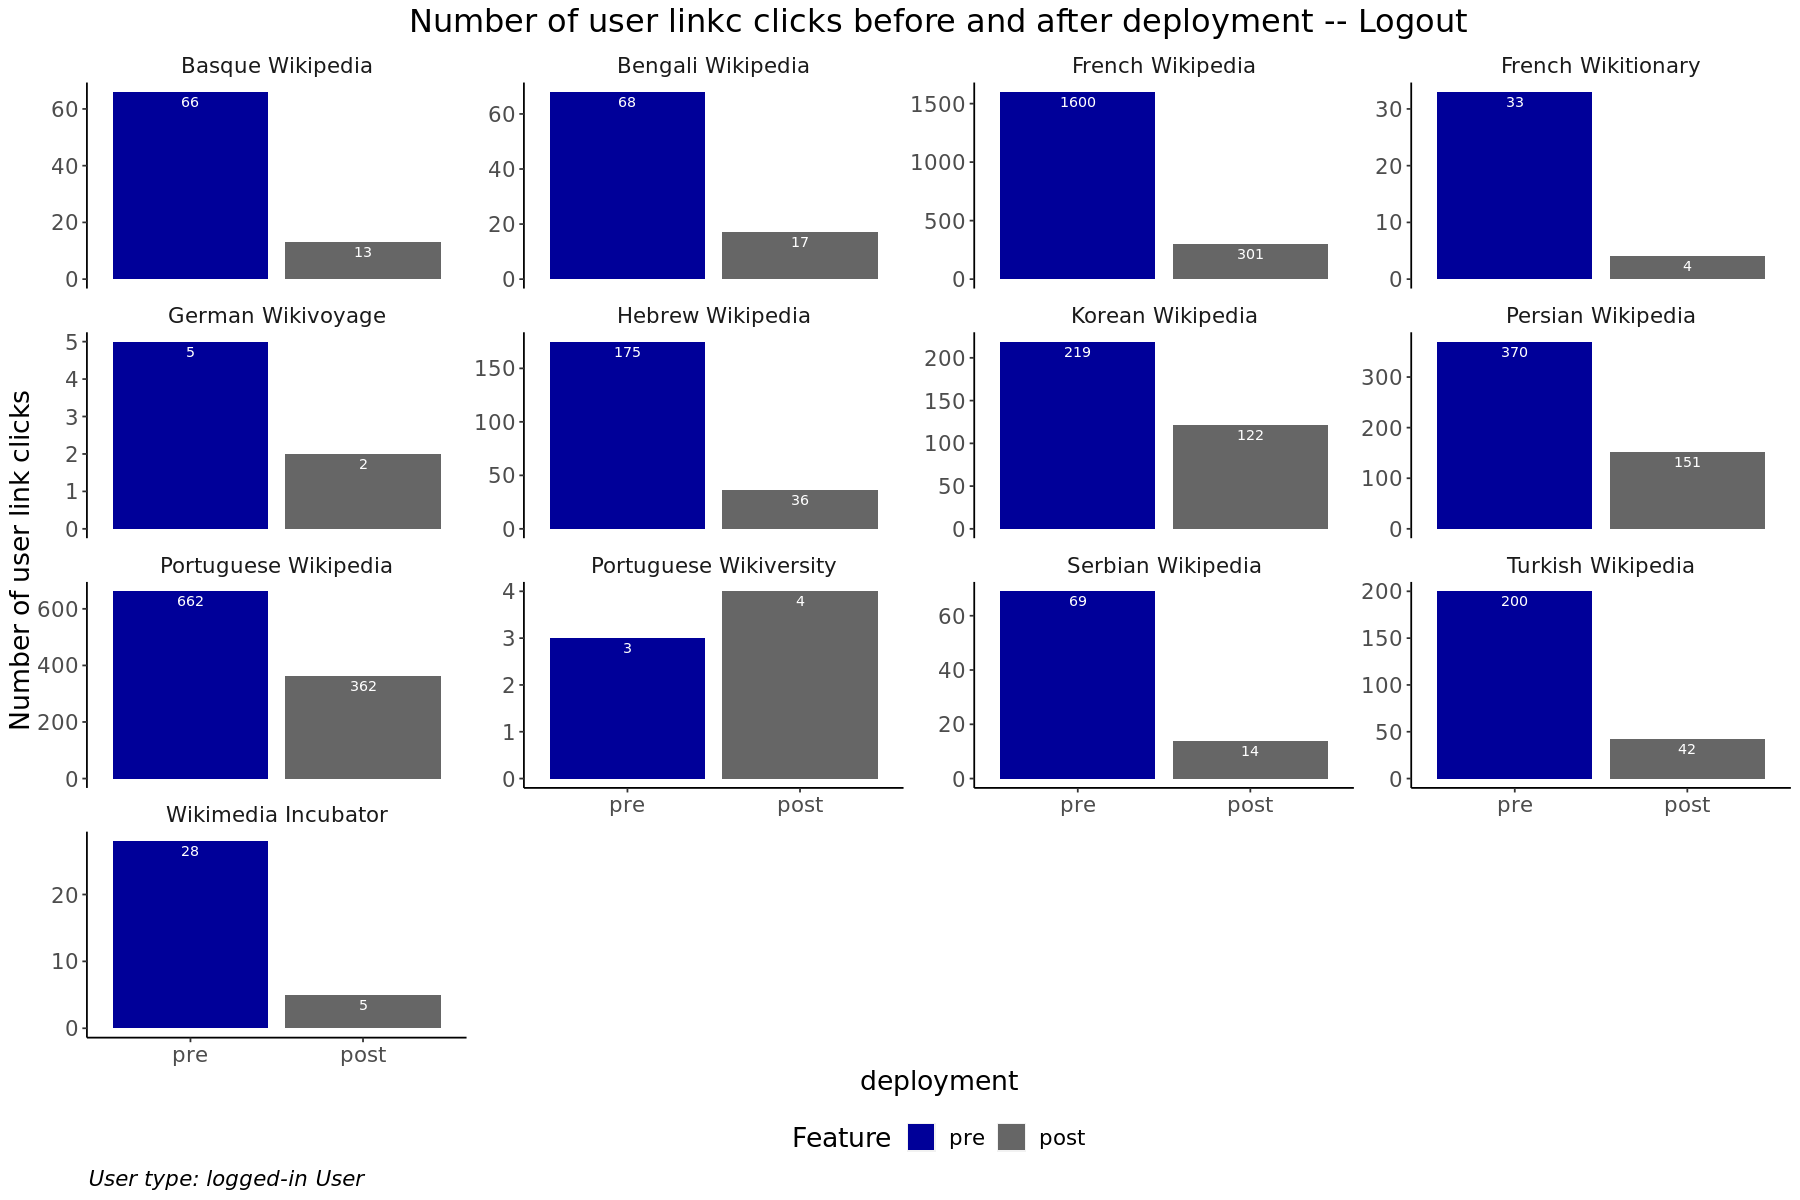

In [56]:
logout_clicks_barchart <- df_user_link_clicks_prepost %>%
        filter(name=='pt-logout') %>%
        ggplot(aes(x = deployment, y= sum_clicks, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_clicks)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of user link clicks",
             title = "Number of user linkc clicks before and after deployment -- Logout",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

logout_clicks_barchart

__Determin the percentage of changes__

In [57]:
# determine percent change

df_logout_clicks_prepost_w <- df_user_link_clicks_prepost %>%
  filter(name=='pt-logout') %>%
  select(wiki_name, deployment,sum_clicks) %>%
  pivot_wider(names_from = deployment, values_from = sum_clicks) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_logout_clicks_prepost_w

wiki_name              post pre  pct_change
1  Basque Wikipedia        13    66 -80.30    
2  Bengali Wikipedia       17    68 -75.00    
3  French Wikipedia       301  1600 -81.19    
4  French Wikitionary       4    33 -87.88    
5  German Wikivoyage        2     5 -60.00    
6  Hebrew Wikipedia        36   175 -79.43    
7  Korean Wikipedia       122   219 -44.29    
8  Persian Wikipedia      151   370 -59.19    
9  Portuguese Wikipedia   362   662 -45.32    
10 Portuguese Wikiversity   4     3  33.33    
11 Serbian Wikipedia       14    69 -79.71    
12 Turkish Wikipedia       42   200 -79.00    
13 Wikimedia Incubator      5    28 -82.14

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


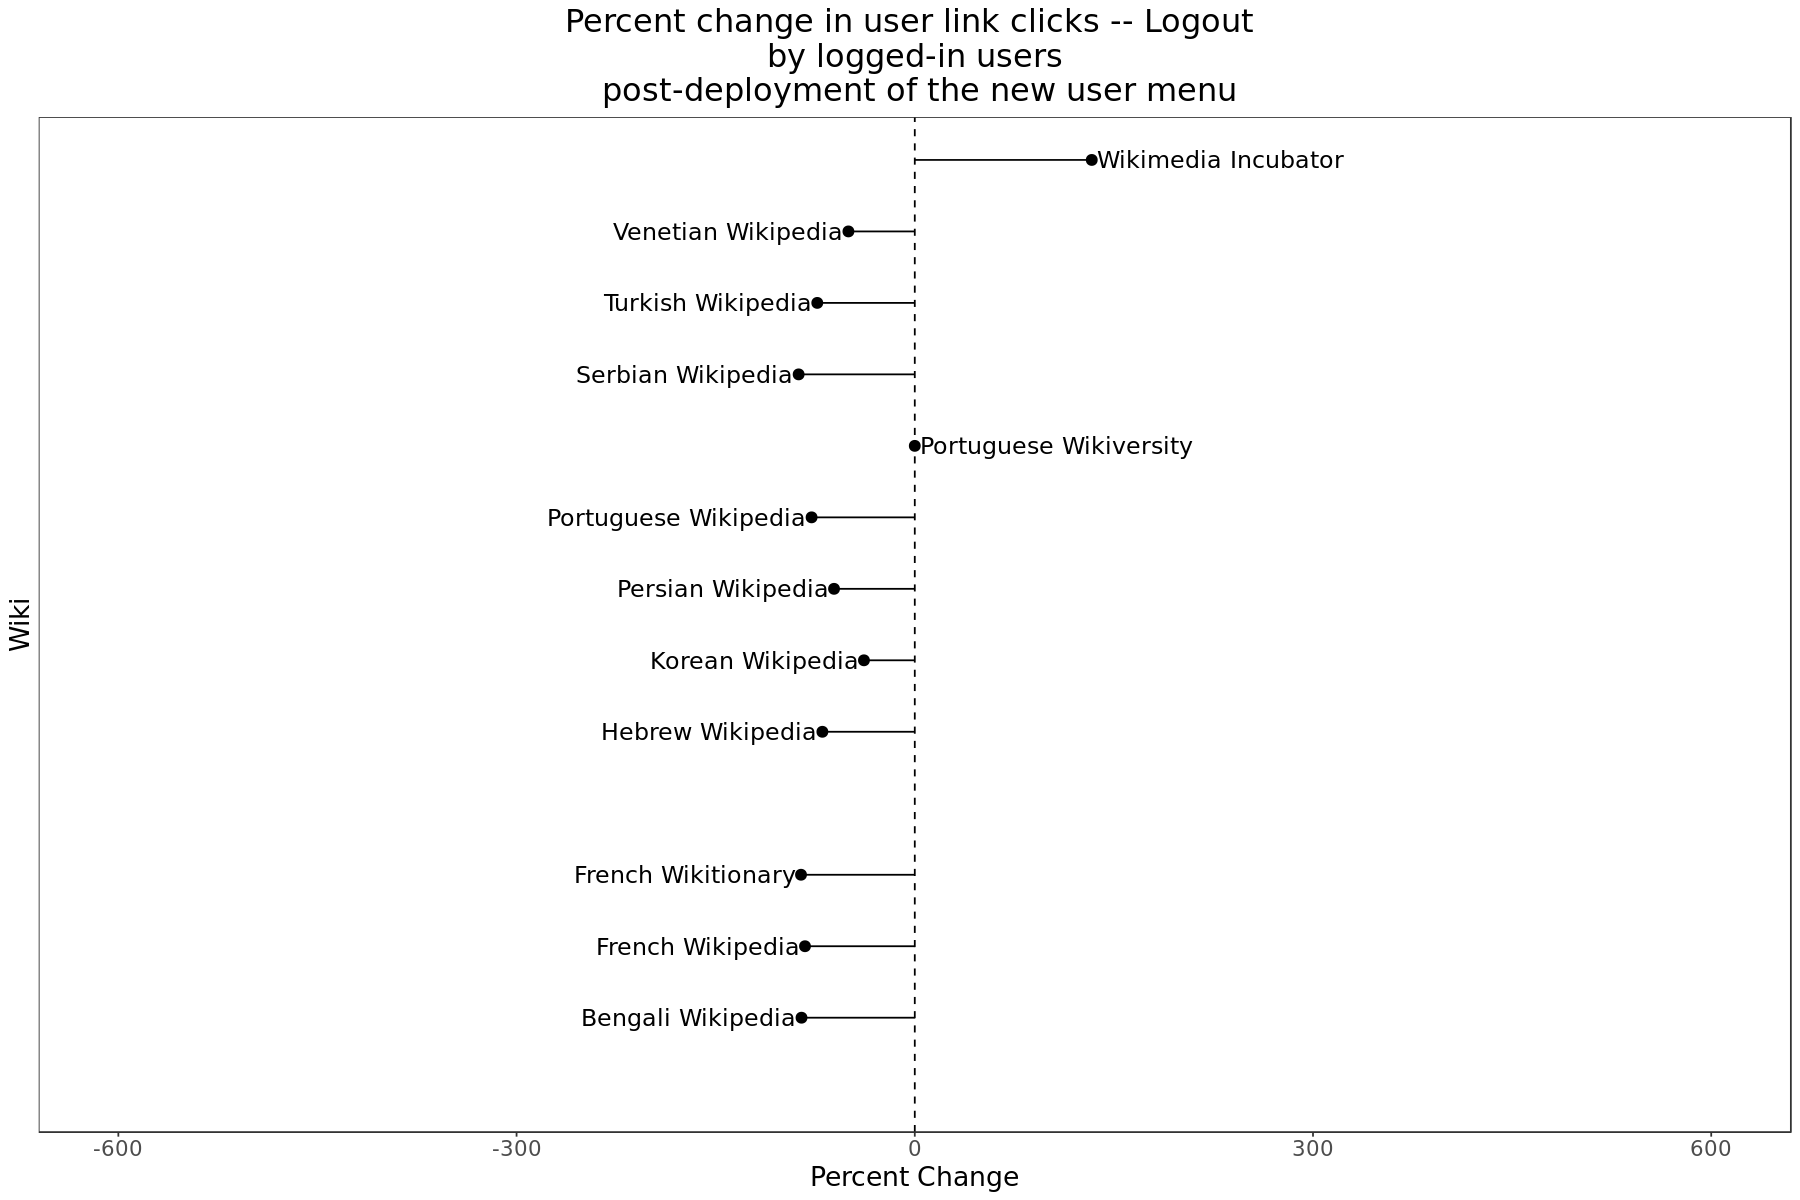

In [58]:






# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_logout_g <- df_talk_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks -- Logout \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_logout_g 




__Average percent change__

Average of the percent changes observed on each early adopter wiki



In [59]:
mean((filter(df_logout_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -63.08615

__Summary__

- After deployed new user menu, the numbers of clicks on user links  by users with new skin decreased on all types of links. The changes varied between -60% ~ -80%. 
- It's expected that the clicks will drop after the deployment. 
- Need to confirm with PM and engineer on whether a 60~80% decrease is within the expected range.

#  Any impacts on editing?

__Edit Attempt__

In [146]:
query_edit_attempt <- "
SELECT CONCAT(year , '-', LPAD(month, 2, '0'), '-', LPAD(day , 2, '0')) AS date_time,
          wiki,
          COUNT(1) AS n_events
FROM event_sanitized.editattemptstep
WHERE YEAR = 2021
     AND Month in (7,8,9)
    -- logged in user
     AND event.user_id != 0 AND event.user_class IS NULL
     AND event.action = 'init'
     AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY CONCAT(year , '-', LPAD(month, 2, '0'), '-', LPAD(day , 2, '0')) , wiki
ORDER BY date_time, wiki
LIMIT 100000
"

In [61]:
df_edit_attempt <-  wmfdata::query_hive(query_edit_attempt)

Don't forget to authenticate with Kerberos using kinit



In [62]:
df_edit_attempt

date_time  wiki          n_events
1    2021-07-01 bnwiki         333    
2    2021-07-01 dewikivoyage    11    
3    2021-07-01 euwiki          42    
4    2021-07-01 fawiki        1099    
5    2021-07-01 frwiki        2047    
6    2021-07-01 frwiktionary    80    
7    2021-07-01 hewiki         593    
8    2021-07-01 incubatorwiki   66    
9    2021-07-01 kowiki         394    
10   2021-07-01 ptwiki        2219    
11   2021-07-01 ptwikiversity    7    
12   2021-07-01 srwiki         273    
13   2021-07-01 trwiki         477    
14   2021-07-01 vecwiki          3    
15   2021-07-02 bnwiki         314    
16   2021-07-02 dewikivoyage    15    
17   2021-07-02 euwiki          36    
18   2021-07-02 fawiki        1133    
19   2021-07-02 frwiki        2055    
20   2021-07-02 frwiktionary    75    
21   2021-07-02 hewiki         659    
22   2021-07-02 incubatorwiki   38    
23   2021-07-02 kowiki         350    
24   2021-07-02 ptwiki        2408    
25   2021-07-02 ptwikiversity   19    
26   2021-07-02 srwiki         297    
27   2021-07-02 trwiki         538    
28   2021-07-02 vecwiki          1    
29   2021-07-03 bnwiki         307    
30   2021-07-03 dewikivoyage     3    
⋮    ⋮          ⋮             ⋮       
1236 2021-09-28 trwiki         410    
1237 2021-09-28 vecwiki          3    
1238 2021-09-29 bnwiki         402    
1239 2021-09-29 dewikivoyage    13    
1240 2021-09-29 euwiki          38    
1241 2021-09-29 fawiki        1475    
1242 2021-09-29 frwiki        2663    
1243 2021-09-29 frwiktionary   231    
1244 2021-09-29 hewiki         689    
1245 2021-09-29 incubatorwiki   82    
1246 2021-09-29 kowiki         466    
1247 2021-09-29 ptwiki        2527    
1248 2021-09-29 ptwikiversity    3    
1249 2021-09-29 srwiki         240    
1250 2021-09-29 trwiki         525    
1251 2021-09-29 vecwiki          3    
1252 2021-09-30 bnwiki         359    
1253 2021-09-30 dewikivoyage    18    
1254 2021-09-30 euwiki          59    
1255 2021-09-30 fawiki        1324    
1256 2021-09-30 frwiki        2436    
1257 2021-09-30 frwiktionary   236    
1258 2021-09-30 hewiki         721    
1259 2021-09-30 incubatorwiki  102    
1260 2021-09-30 kowiki         466    
1261 2021-09-30 ptwiki        2349    
1262 2021-09-30 ptwikiversity    3    
1263 2021-09-30 srwiki         213    
1264 2021-09-30 trwiki         478    
1265 2021-09-30 vecwiki          4

In [63]:
df_edit_attempt$date_time <- as.Date(df_edit_attempt$date_time)

In [65]:
df_edit_attempt <- df_edit_attempt %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)

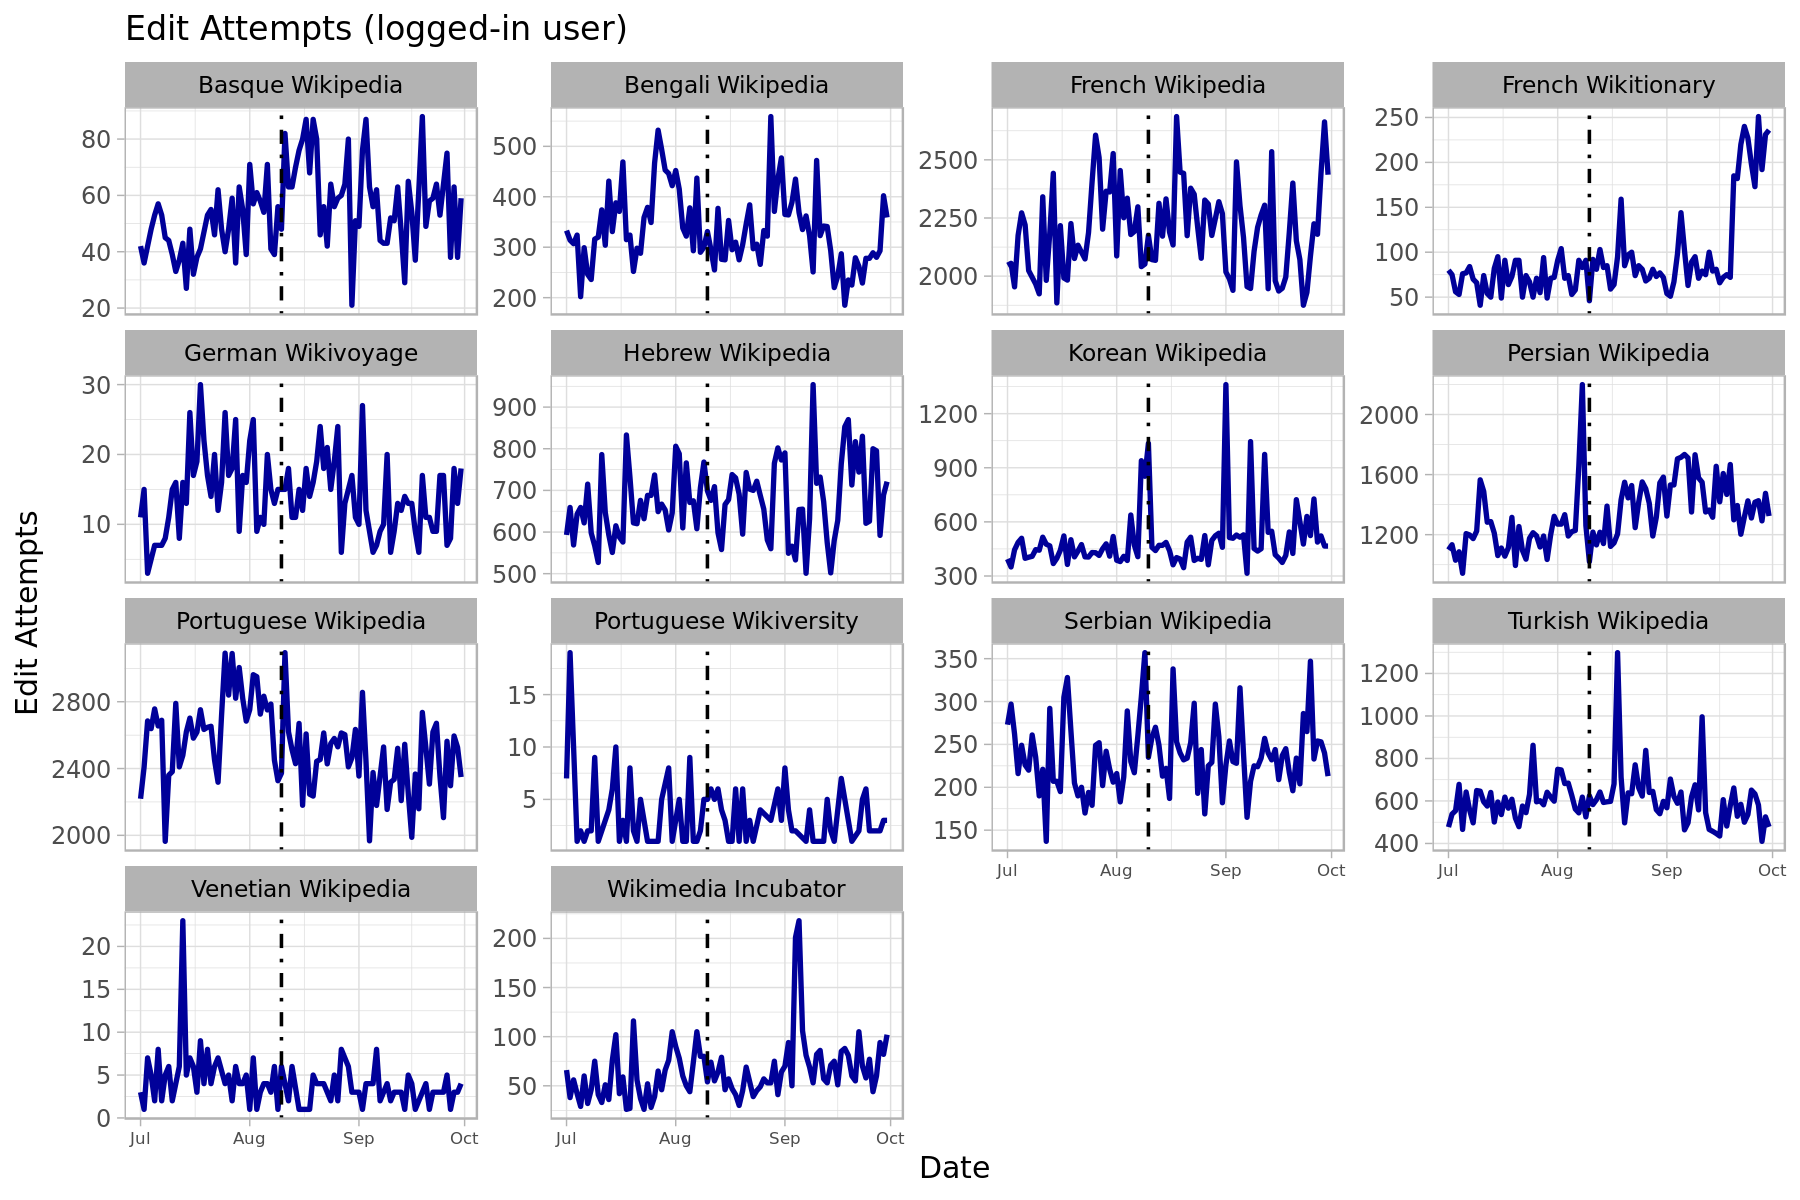

In [67]:
edit_attempt_g <- ggplot(data=df_edit_attempt, 
                                mapping=aes(x=date_time)) +
geom_line(aes(y=n_events ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'Edit Attempts (logged-in user) ',
     x = 'Date',
     y = 'Edit Attempts') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
edit_attempt_g

In [147]:
# add column classifying pre and post deployment dates
df_edit_attempt_prepost <- df_edit_attempt %>%
    mutate(deployment = case_when(
        date_time >= '2021-07-13' & date_time <= '2021-08-09'  ~ 'pre',
        date_time >= '2021-08-10' & date_time <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
       filter(deployment!='NA') %>%
    group_by(wiki_name, deployment) %>%
    summarize(sum_events = sum(n_events),  .groups = 'drop')

In [148]:
df_edit_attempt_prepost

wiki_name              deployment sum_events
1  Basque Wikipedia       post        1796     
2  Basque Wikipedia       pre         1388     
3  Bengali Wikipedia      post        9700     
4  Bengali Wikipedia      pre        10593     
5  French Wikipedia       post       62771     
6  French Wikipedia       pre        62367     
7  French Wikitionary     post        2347     
8  French Wikitionary     pre         2055     
9  German Wikivoyage      post         418     
10 German Wikivoyage      pre          490     
11 Hebrew Wikipedia       post       18777     
12 Hebrew Wikipedia       pre        18769     
13 Korean Wikipedia       post       14339     
14 Korean Wikipedia       pre        13194     
15 Persian Wikipedia      post       38847     
16 Persian Wikipedia      pre        34608     
17 Portuguese Wikipedia   post       69465     
18 Portuguese Wikipedia   pre        76064     
19 Portuguese Wikiversity post          81     
20 Portuguese Wikiversity pre           82     
21 Serbian Wikipedia      post        6772     
22 Serbian Wikipedia      pre         6580     
23 Turkish Wikipedia      post       18163     
24 Turkish Wikipedia      pre        17050     
25 Venetian Wikipedia     post         101     
26 Venetian Wikipedia     pre          142     
27 Wikimedia Incubator    post        1930     
28 Wikimedia Incubator    pre         1741

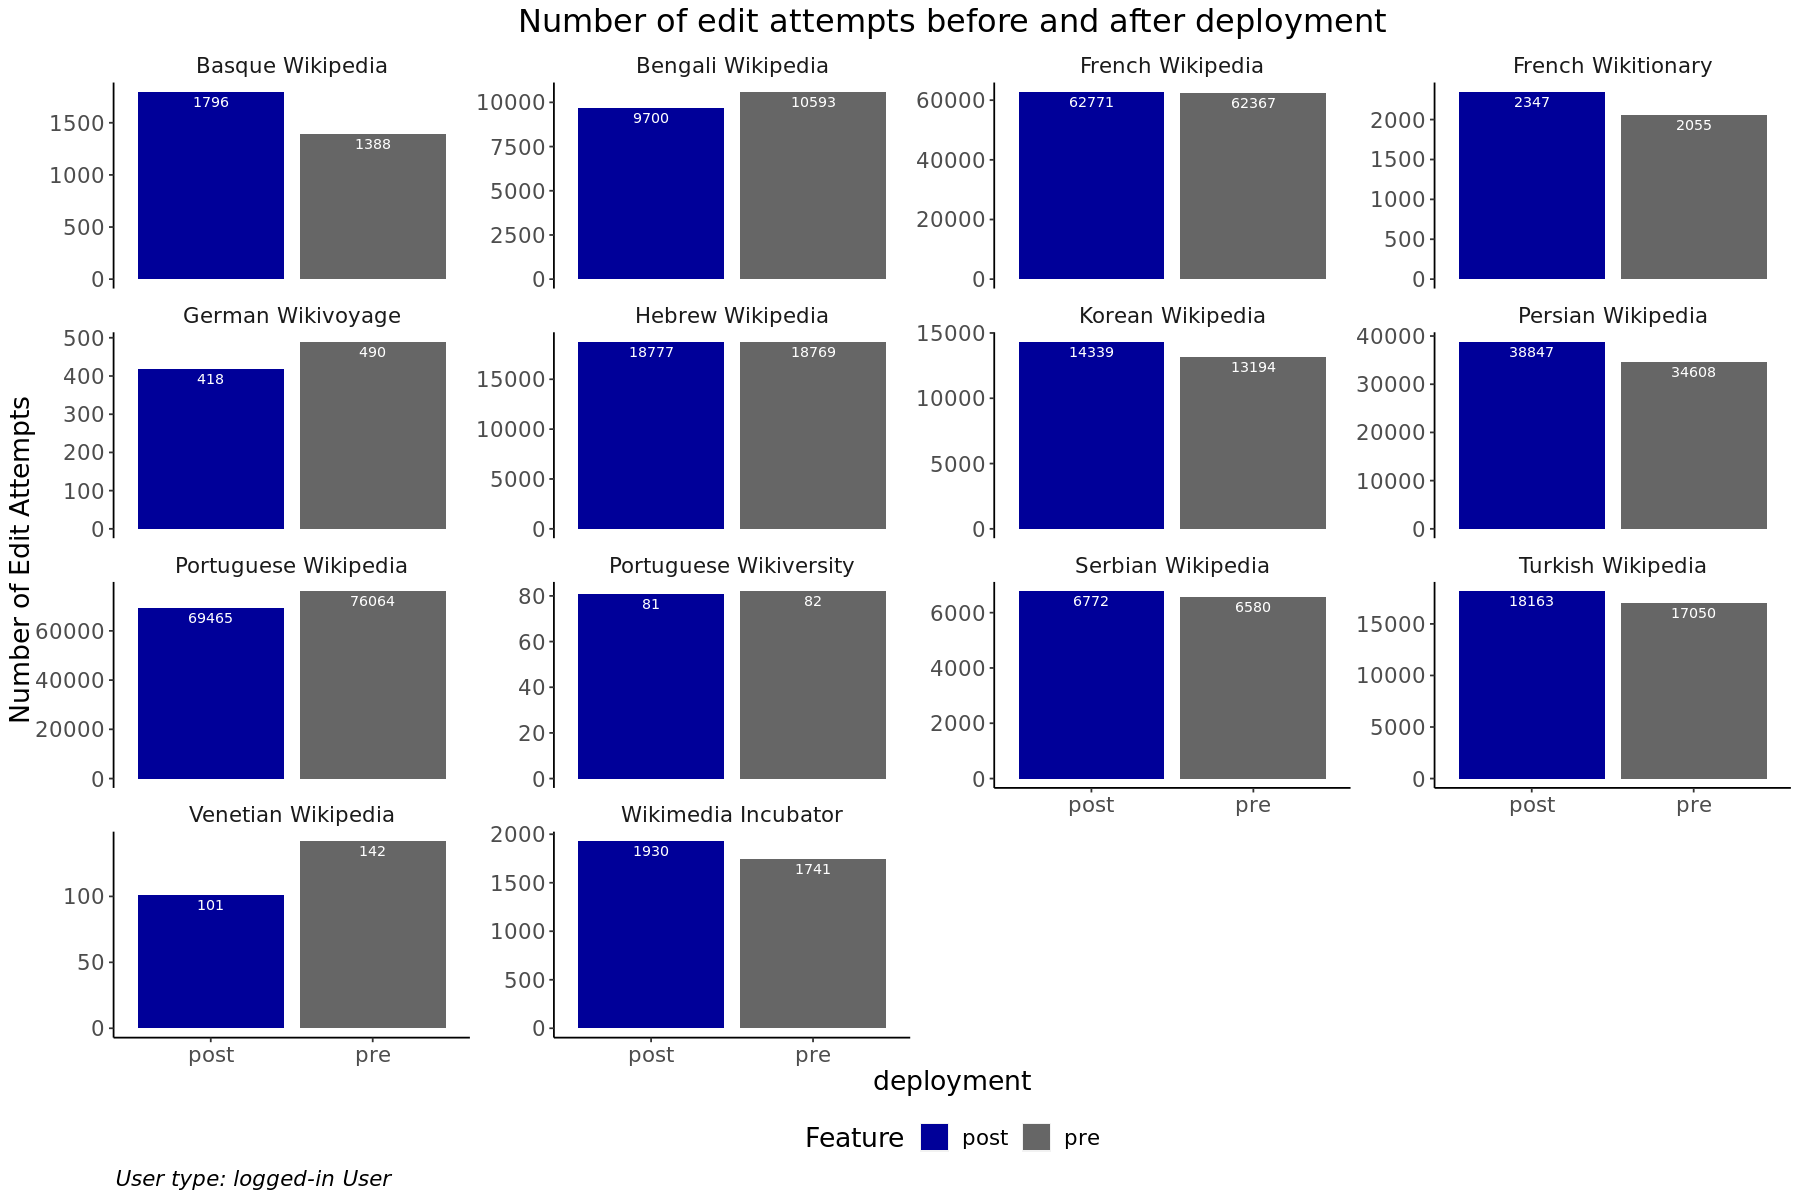

In [149]:
edit_attempt_barchart <- df_edit_attempt_prepost %>%
        ggplot(aes(x = deployment, y= sum_events, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_events)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of Edit Attempts",
             title = "Number of edit attempts before and after deployment",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

edit_attempt_barchart

__Determin the percentage of changes__

In [150]:

# determine percent change

df_edit_attempt_prepost_w <- df_edit_attempt_prepost %>%
  select(wiki_name, deployment,sum_events) %>%
  pivot_wider(names_from = deployment, values_from = sum_events) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_edit_attempt_prepost_w

wiki_name              post  pre   pct_change
1  Basque Wikipedia        1796  1388  29.39    
2  Bengali Wikipedia       9700 10593  -8.43    
3  French Wikipedia       62771 62367   0.65    
4  French Wikitionary      2347  2055  14.21    
5  German Wikivoyage        418   490 -14.69    
6  Hebrew Wikipedia       18777 18769   0.04    
7  Korean Wikipedia       14339 13194   8.68    
8  Persian Wikipedia      38847 34608  12.25    
9  Portuguese Wikipedia   69465 76064  -8.68    
10 Portuguese Wikiversity    81    82  -1.22    
11 Serbian Wikipedia       6772  6580   2.92    
12 Turkish Wikipedia      18163 17050   6.53    
13 Venetian Wikipedia       101   142 -28.87    
14 Wikimedia Incubator     1930  1741  10.86

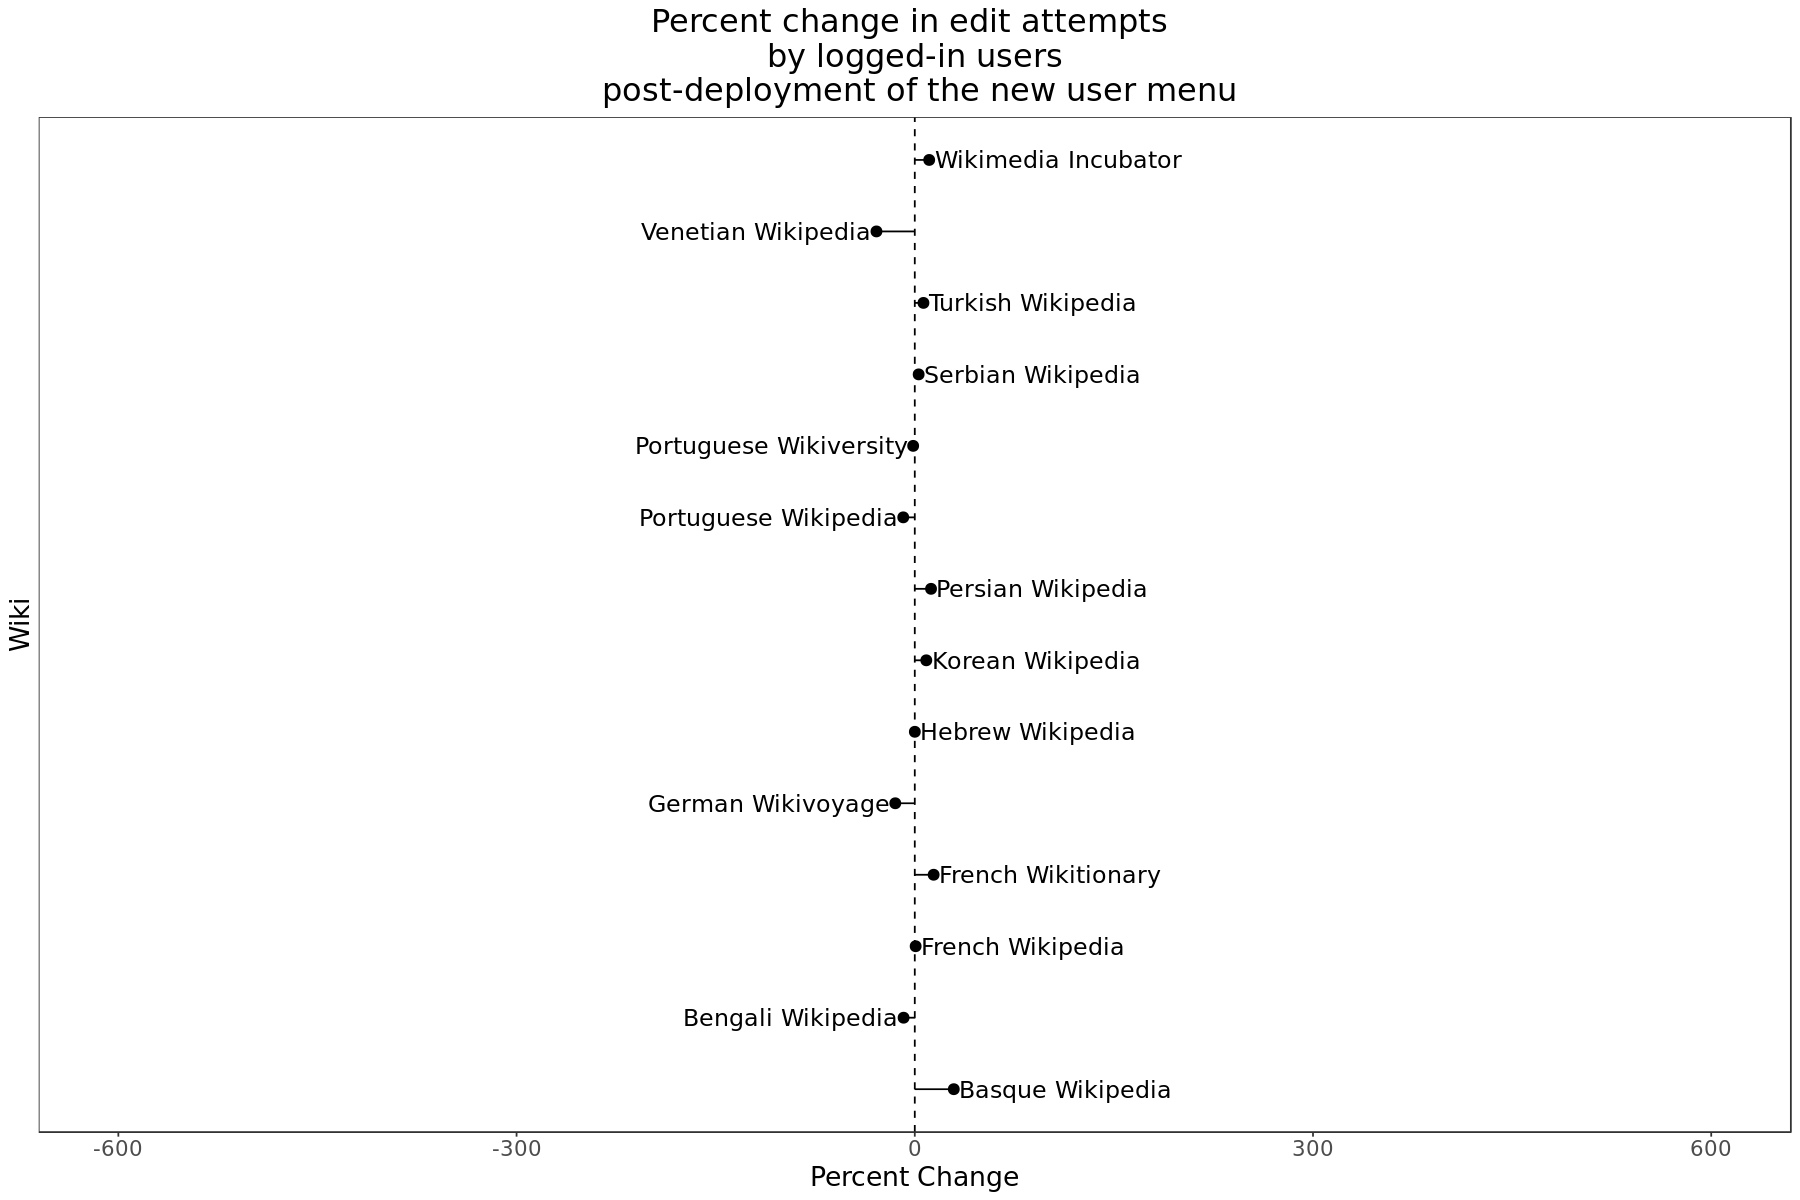

In [151]:








# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_ea_g <- df_edit_attempt_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in edit attempts \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_ea_g 





__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [152]:

mean((filter(df_edit_attempt_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] 1.688571

__Edit Attempts by init types: page or section__

In [163]:
query_edit_attempt_type <- "
SELECT CONCAT(year , '-', LPAD(month, 2, '0'), '-', LPAD(day , 2, '0')) AS date_time,
          wiki, event.init_type AS init_type,
          COUNT(1) AS n_events
FROM event_sanitized.editattemptstep
WHERE YEAR = 2021
     AND Month in (7,8,9)
    -- logged in user
     AND event.user_id != 0 AND event.user_class IS NULL
     AND event.action = 'init' AND event.init_type IN ('page', 'section')
     AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY CONCAT(year , '-', LPAD(month, 2, '0'), '-', LPAD(day , 2, '0')) , wiki, event.init_type
ORDER BY date_time, wiki
LIMIT 100000
"

In [164]:
df_edit_attempt_type <-  wmfdata::query_hive(query_edit_attempt_type)

Don't forget to authenticate with Kerberos using kinit



In [165]:
df_edit_attempt_type

date_time  wiki          init_type n_events
1    2021-07-01 bnwiki        page        87    
2    2021-07-01 bnwiki        section    246    
3    2021-07-01 dewikivoyage  page         4    
4    2021-07-01 dewikivoyage  section      7    
5    2021-07-01 euwiki        page        31    
6    2021-07-01 euwiki        section     11    
7    2021-07-01 fawiki        section    876    
8    2021-07-01 fawiki        page       223    
9    2021-07-01 frwiki        page       931    
10   2021-07-01 frwiki        section   1116    
11   2021-07-01 frwiktionary  section     25    
12   2021-07-01 frwiktionary  page        55    
13   2021-07-01 hewiki        page       276    
14   2021-07-01 hewiki        section    317    
15   2021-07-01 incubatorwiki page        62    
16   2021-07-01 incubatorwiki section      4    
17   2021-07-01 kowiki        page       138    
18   2021-07-01 kowiki        section    256    
19   2021-07-01 ptwiki        page       315    
20   2021-07-01 ptwiki        section   1904    
21   2021-07-01 ptwikiversity section      4    
22   2021-07-01 ptwikiversity page         3    
23   2021-07-01 srwiki        page        91    
24   2021-07-01 srwiki        section    182    
25   2021-07-01 trwiki        page       195    
26   2021-07-01 trwiki        section    282    
27   2021-07-01 vecwiki       page         3    
28   2021-07-02 bnwiki        page        96    
29   2021-07-02 bnwiki        section    218    
30   2021-07-02 dewikivoyage  section     13    
⋮    ⋮          ⋮             ⋮         ⋮       
2405 2021-09-29 trwiki        section    337    
2406 2021-09-29 vecwiki       page         2    
2407 2021-09-29 vecwiki       section      1    
2408 2021-09-30 bnwiki        page        91    
2409 2021-09-30 bnwiki        section    268    
2410 2021-09-30 dewikivoyage  section     10    
2411 2021-09-30 dewikivoyage  page         8    
2412 2021-09-30 euwiki        section     27    
2413 2021-09-30 euwiki        page        32    
2414 2021-09-30 fawiki        page       256    
2415 2021-09-30 fawiki        section   1068    
2416 2021-09-30 frwiki        page      1377    
2417 2021-09-30 frwiki        section   1059    
2418 2021-09-30 frwiktionary  page       203    
2419 2021-09-30 frwiktionary  section     33    
2420 2021-09-30 hewiki        section    335    
2421 2021-09-30 hewiki        page       386    
2422 2021-09-30 incubatorwiki section     44    
2423 2021-09-30 incubatorwiki page        58    
2424 2021-09-30 kowiki        section    294    
2425 2021-09-30 kowiki        page       172    
2426 2021-09-30 ptwiki        page       420    
2427 2021-09-30 ptwiki        section   1929    
2428 2021-09-30 ptwikiversity section      1    
2429 2021-09-30 ptwikiversity page         2    
2430 2021-09-30 srwiki        section    140    
2431 2021-09-30 srwiki        page        73    
2432 2021-09-30 trwiki        section    288    
2433 2021-09-30 trwiki        page       190    
2434 2021-09-30 vecwiki       page         4

In [166]:
df_edit_attempt_type$date_time <- as.Date(df_edit_attempt_type$date_time)

In [167]:
df_edit_attempt_type <- df_edit_attempt_type %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)

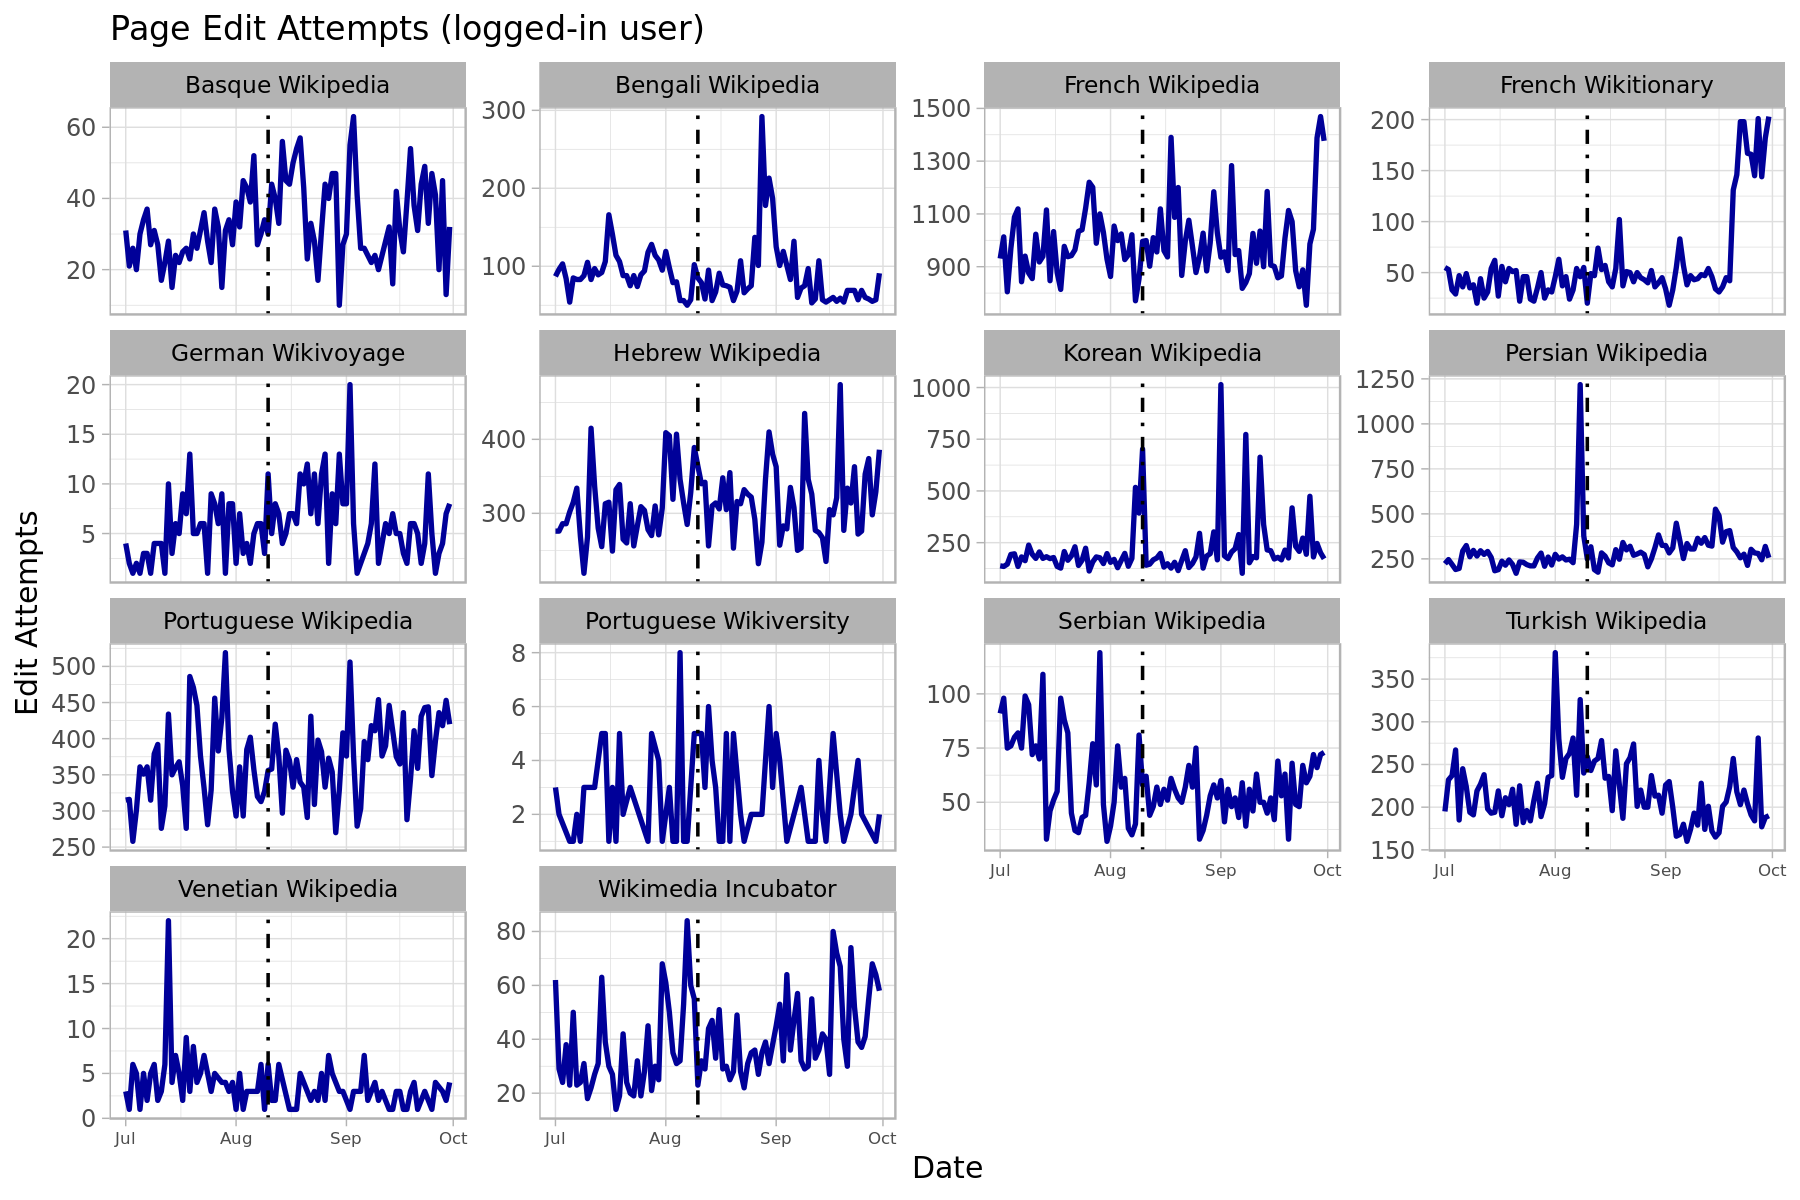

In [168]:
edit_attempt_page_g <- ggplot(data=filter(df_edit_attempt_type, init_type=='page'), 
                                mapping=aes(x=date_time)) +
geom_line(aes(y=n_events ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'Page Edit Attempts (logged-in user) ',
     x = 'Date',
     y = 'Edit Attempts') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
edit_attempt_page_g

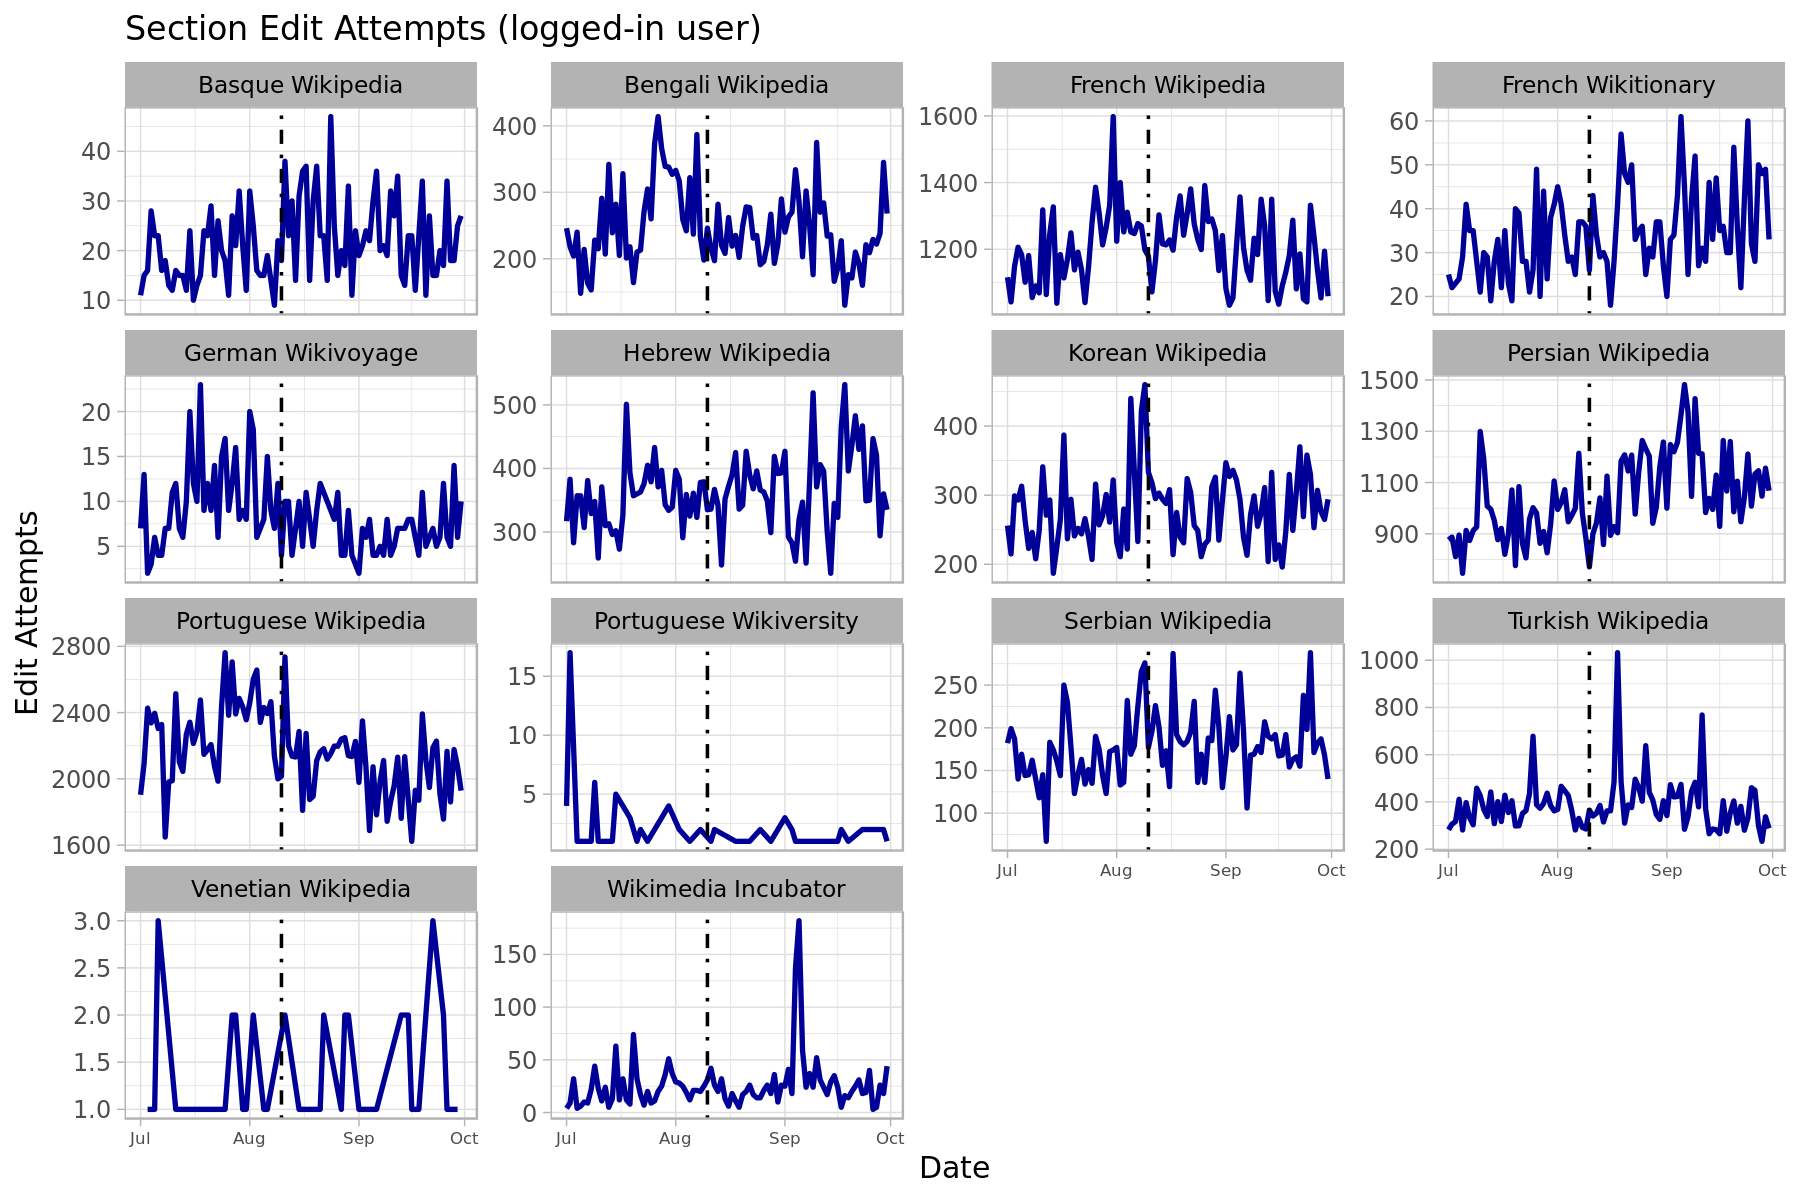

In [169]:
edit_attempt_section_g <- ggplot(data=filter(df_edit_attempt_type, init_type=='section'), 
                                mapping=aes(x=date_time)) +
geom_line(aes(y=n_events ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'Section Edit Attempts (logged-in user) ',
     x = 'Date',
     y = 'Edit Attempts') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
edit_attempt_section_g

In [171]:
# add column classifying pre and post deployment dates
df_edit_attempt_type_prepost <- df_edit_attempt_type %>%
    mutate(deployment = case_when(
        date_time >= '2021-07-13' & date_time <= '2021-08-09'  ~ 'pre',
        date_time >= '2021-08-10' & date_time <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
       filter(deployment!='NA') %>%
    group_by(wiki_name, deployment, init_type) %>%
    summarize(sum_events = sum(n_events),  .groups = 'drop')

df_edit_attempt_type_prepost

wiki_name              deployment init_type sum_events
1  Basque Wikipedia       post       page       1084     
2  Basque Wikipedia       post       section     712     
3  Basque Wikipedia       pre        page        853     
4  Basque Wikipedia       pre        section     535     
5  Bengali Wikipedia      post       page       2967     
6  Bengali Wikipedia      post       section    6733     
7  Bengali Wikipedia      pre        page       2670     
8  Bengali Wikipedia      pre        section    7923     
9  French Wikipedia       post       page      28370     
10 French Wikipedia       post       section   34401     
11 French Wikipedia       pre        page      27570     
12 French Wikipedia       pre        section   34797     
13 French Wikitionary     post       page       1343     
14 French Wikitionary     post       section    1004     
15 French Wikitionary     pre        page       1166     
16 French Wikitionary     pre        section     889     
17 German Wikivoyage      post       page        219     
18 German Wikivoyage      post       section     199     
19 German Wikivoyage      pre        page        163     
20 German Wikivoyage      pre        section     327     
21 Hebrew Wikipedia       post       page       8848     
22 Hebrew Wikipedia       post       section    9929     
23 Hebrew Wikipedia       pre        page       8711     
24 Hebrew Wikipedia       pre        section   10058     
25 Korean Wikipedia       post       page       6403     
26 Korean Wikipedia       post       section    7936     
27 Korean Wikipedia       pre        page       5294     
28 Korean Wikipedia       pre        section    7900     
29 Persian Wikipedia      post       page       7990     
30 Persian Wikipedia      post       section   30857     
31 Persian Wikipedia      pre        page       7878     
32 Persian Wikipedia      pre        section   26730     
33 Portuguese Wikipedia   post       page      10052     
34 Portuguese Wikipedia   post       section   59413     
35 Portuguese Wikipedia   pre        page      10395     
36 Portuguese Wikipedia   pre        section   65669     
37 Portuguese Wikiversity post       page         65     
38 Portuguese Wikiversity post       section      16     
39 Portuguese Wikiversity pre        page         60     
40 Portuguese Wikiversity pre        section      22     
41 Serbian Wikipedia      post       page       1477     
42 Serbian Wikipedia      post       section    5295     
43 Serbian Wikipedia      pre        page       1638     
44 Serbian Wikipedia      pre        section    4942     
45 Turkish Wikipedia      post       page       6267     
46 Turkish Wikipedia      post       section   11896     
47 Turkish Wikipedia      pre        page       6374     
48 Turkish Wikipedia      pre        section   10676     
49 Venetian Wikipedia     post       page         85     
50 Venetian Wikipedia     post       section      16     
51 Venetian Wikipedia     pre        page        125     
52 Venetian Wikipedia     pre        section      17     
53 Wikimedia Incubator    post       page       1019     
54 Wikimedia Incubator    post       section     911     
55 Wikimedia Incubator    pre        page       1057     
56 Wikimedia Incubator    pre        section     684

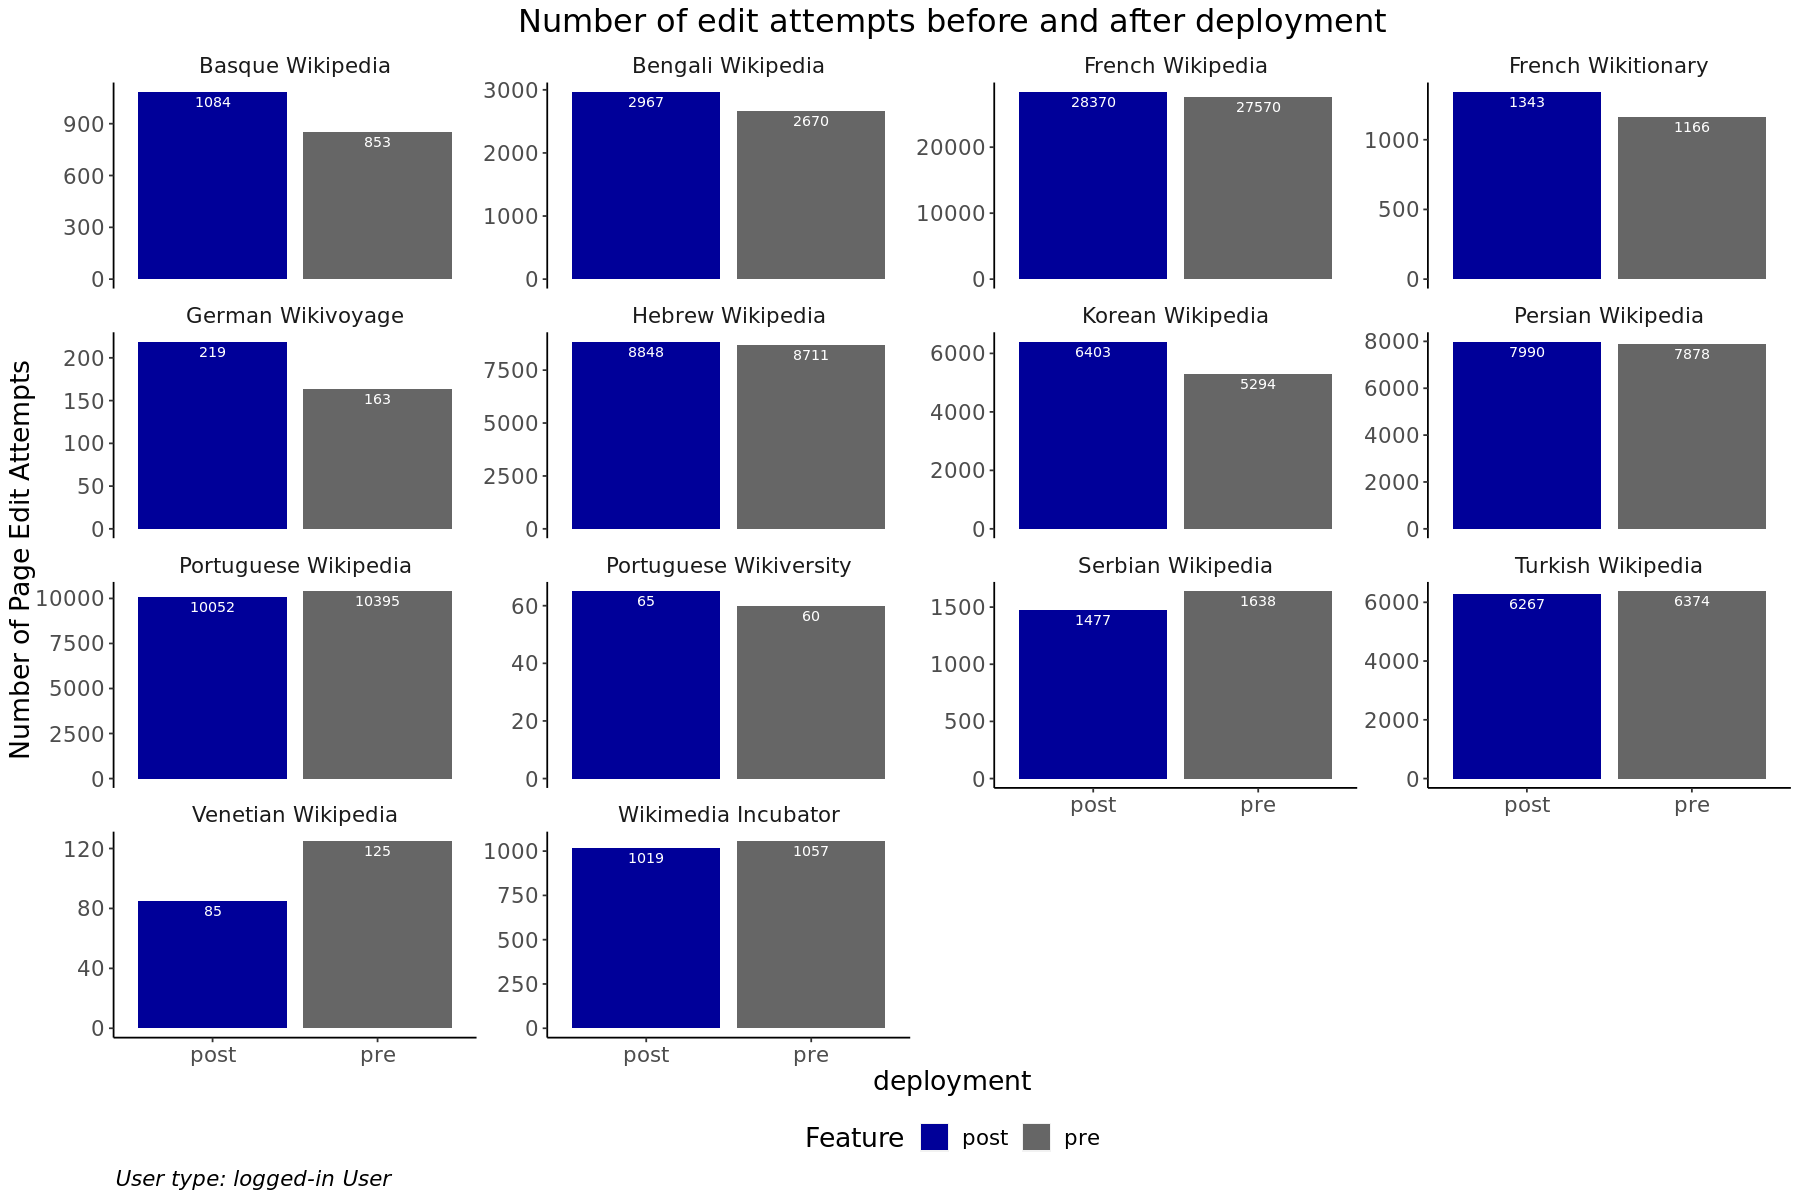

In [172]:






edit_attempt_page_barchart <- df_edit_attempt_type_prepost %>%
        filter(init_type=='page') %>% 
        ggplot(aes(x = deployment, y= sum_events, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_events)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of Page Edit Attempts",
             title = "Number of edit attempts before and after deployment",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

edit_attempt_page_barchart

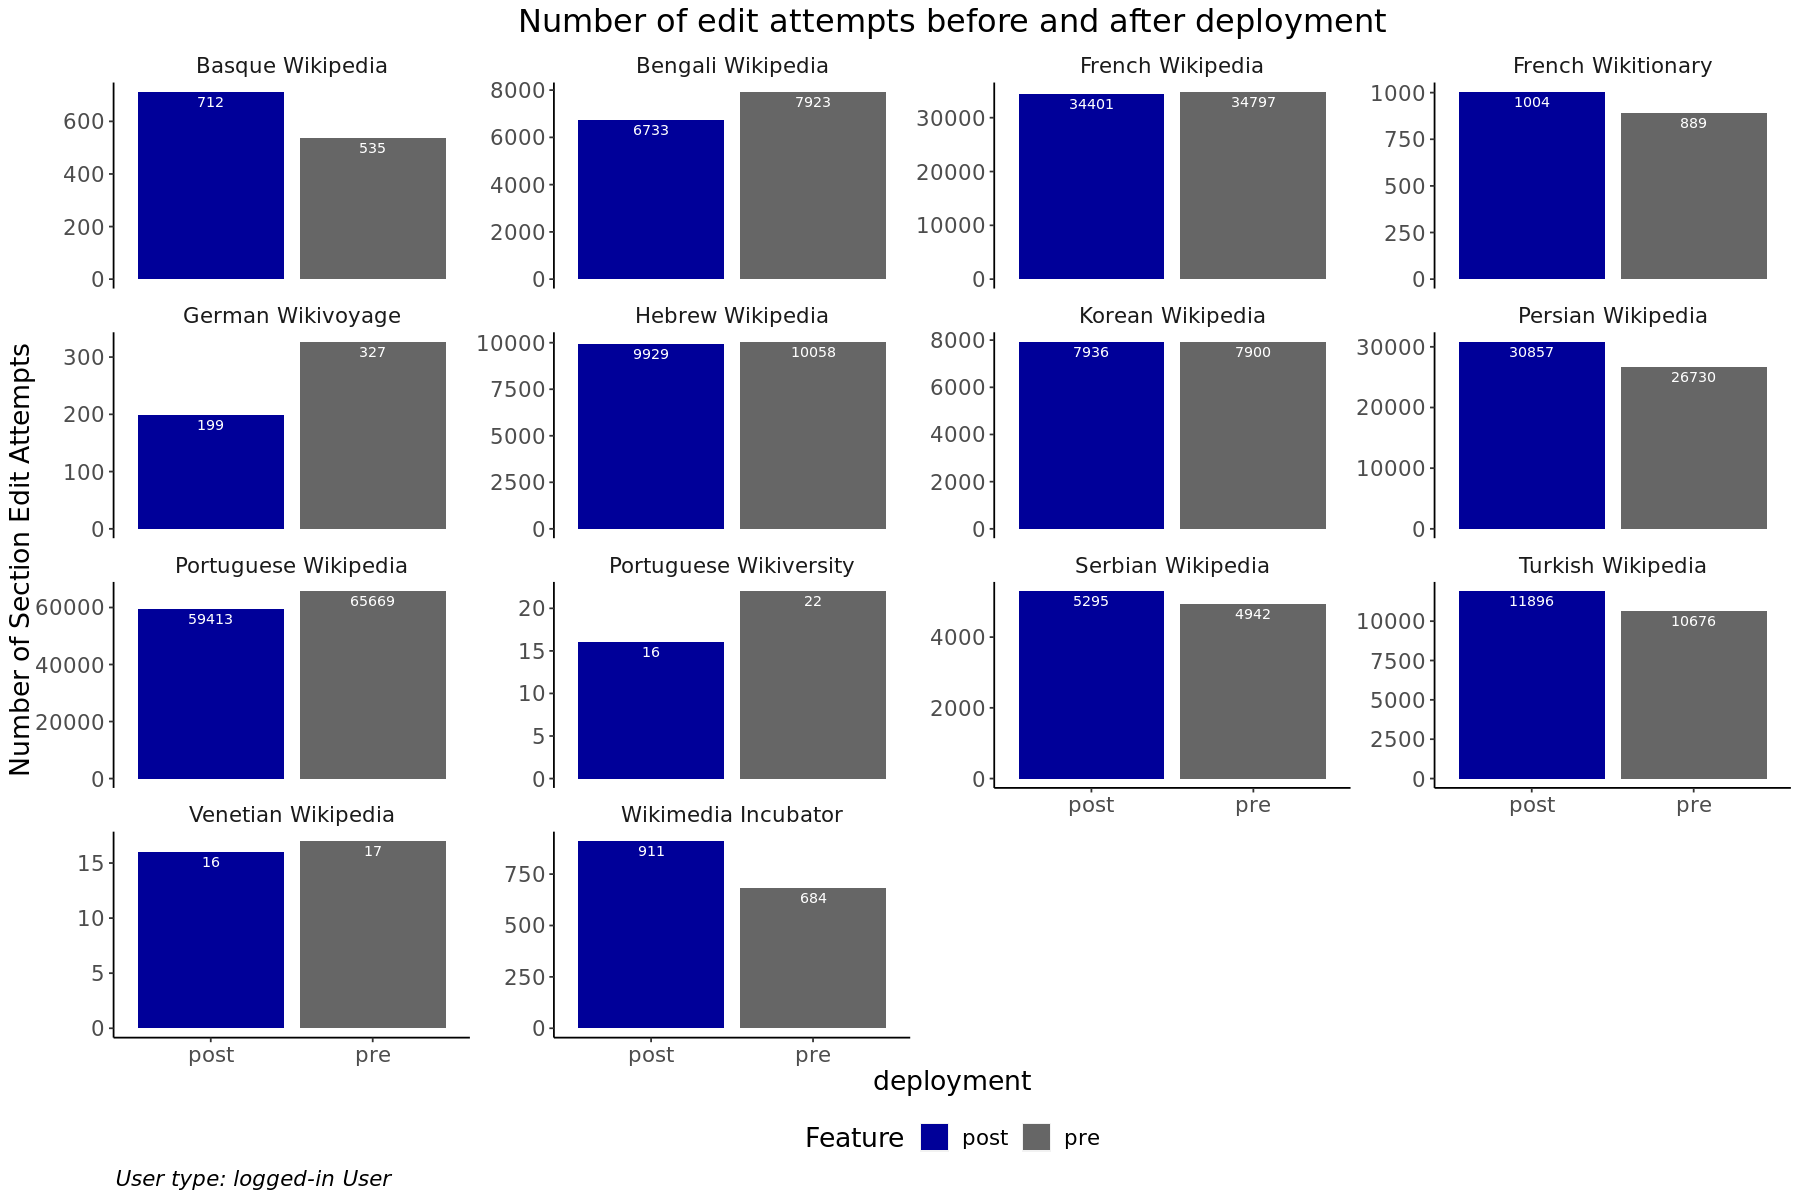

In [173]:
edit_attempt_section_barchart <- df_edit_attempt_type_prepost %>%
        filter(init_type=='section') %>% 
        ggplot(aes(x = deployment, y= sum_events, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_events)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of Section Edit Attempts",
             title = "Number of edit attempts before and after deployment",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

edit_attempt_section_barchart

__Edits__

In [76]:
query_edits_nonbot <- "
SELECT
       DATE(event_timestamp) AS date_time, wiki_db, COUNT(revision_id) AS edits
FROM wmf.mediawiki_history
WHERE
        event_entity = 'revision' AND
        event_type = 'create' AND
        DATE(event_timestamp) BETWEEN '2021-07-01' AND  '2021-09-30' AND
        event_user_is_anonymous = false AND 
        size(event_user_is_bot_by_historical) = 0 AND size(event_user_is_bot_by) = 0  
        AND event_user_text not regexp '^.*bot([^a-z].*$|$)' 
        AND snapshot = '2021-12'
        AND  wiki_db IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY DATE(event_timestamp), wiki_db
ORDER BY date_time, wiki_db
LIMIT 100000
"


In [77]:
df_edits_nonbot  <-  wmfdata::query_hive(query_edits_nonbot )

Don't forget to authenticate with Kerberos using kinit



In [78]:
df_edits_nonbot$date_time <- as.Date(df_edits_nonbot$date_time)

In [80]:
df_edits_nonbot <- df_edits_nonbot %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki_db == 'frwiktionary' ~ "French Wikitionary",
        wiki_db == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki_db == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki_db == 'frwiki'~ "French Wikipedia",
        wiki_db == 'euwiki' ~ "Basque Wikipedia",
        wiki_db == 'fawiki' ~ 'Persian Wikipedia',
        wiki_db == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki_db == 'kowiki' ~ 'Korean Wikipedia',
        wiki_db == 'trwiki' ~ 'Turkish Wikipedia',
        wiki_db == 'srwiki' ~ 'Serbian Wikipedia',
        wiki_db == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki_db == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki_db == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki_db == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)



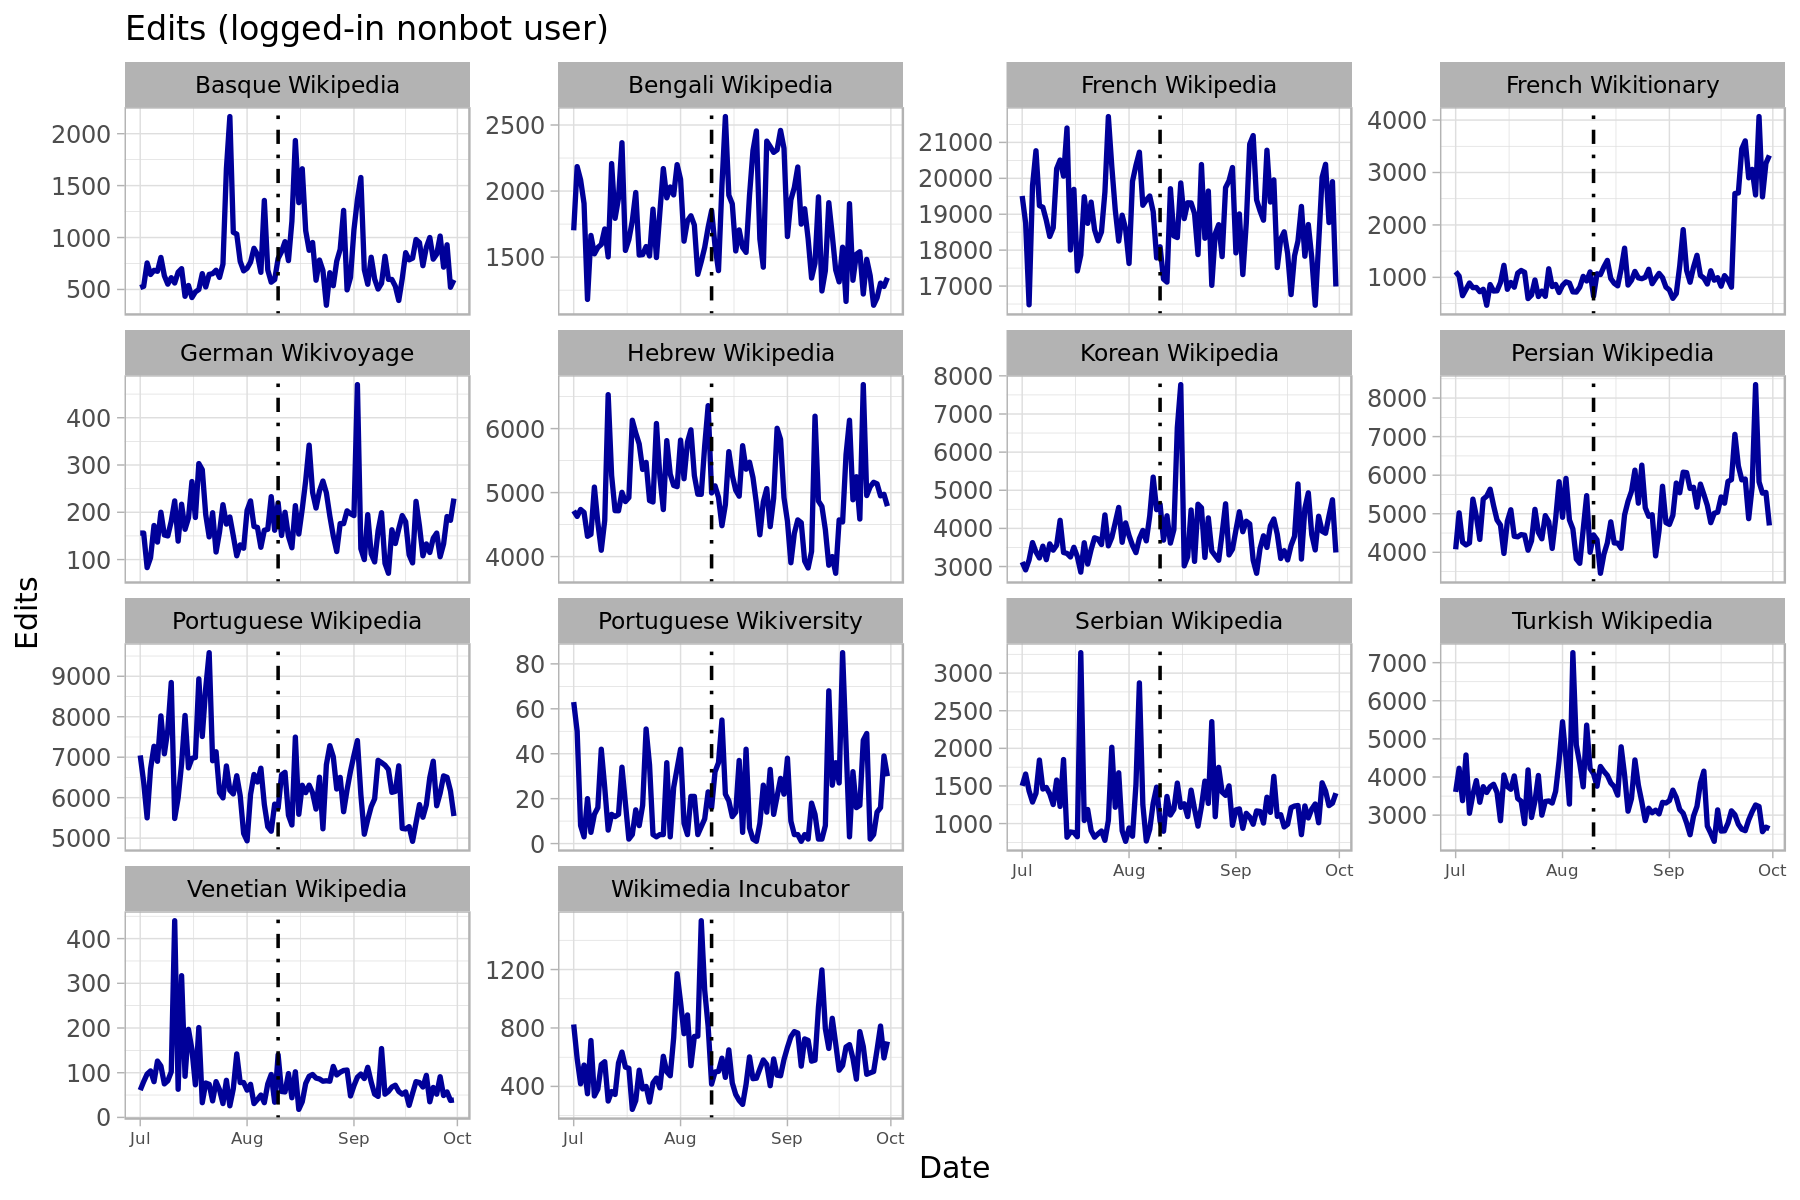

In [81]:
edits_g <- ggplot(data=df_edits_nonbot, 
                                mapping=aes(x=date_time)) +
geom_line(aes(y=edits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'Edits (logged-in nonbot user) ',
     x = 'Date',
     y = 'Edits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
edits_g

In [153]:
# add column classifying pre and post deployment dates
df_edits_nonbot_prepost <- df_edits_nonbot %>%
    mutate(deployment = case_when(
        date_time >= '2021-07-13' & date_time <= '2021-08-09'  ~ 'pre',
        date_time >= '2021-08-10' & date_time <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
       filter(deployment!='NA') %>%
    group_by(wiki_name, deployment) %>%
    summarize(sum_events = sum(edits),  .groups = 'drop')

df_edits_nonbot_prepost

wiki_name              deployment sum_events
1  Basque Wikipedia       post        26083    
2  Basque Wikipedia       pre         22019    
3  Bengali Wikipedia      post        54979    
4  Bengali Wikipedia      pre         49878    
5  French Wikipedia       post       528617    
6  French Wikipedia       pre        537592    
7  French Wikitionary     post        28780    
8  French Wikitionary     pre         24400    
9  German Wikivoyage      post         5636    
10 German Wikivoyage      pre          5139    
11 Hebrew Wikipedia       post       138104    
12 Hebrew Wikipedia       pre        150086    
13 Korean Wikipedia       post       114121    
14 Korean Wikipedia       pre        105147    
15 Persian Wikipedia      post       138512    
16 Persian Wikipedia      pre        129897    
17 Portuguese Wikipedia   post       174417    
18 Portuguese Wikipedia   pre        186046    
19 Portuguese Wikiversity post          507    
20 Portuguese Wikiversity pre           405    
21 Serbian Wikipedia      post        35355    
22 Serbian Wikipedia      pre         34505    
23 Turkish Wikipedia      post        99789    
24 Turkish Wikipedia      pre        110163    
25 Venetian Wikipedia     post         2339    
26 Venetian Wikipedia     pre          2391    
27 Wikimedia Incubator    post        14787    
28 Wikimedia Incubator    pre         17540

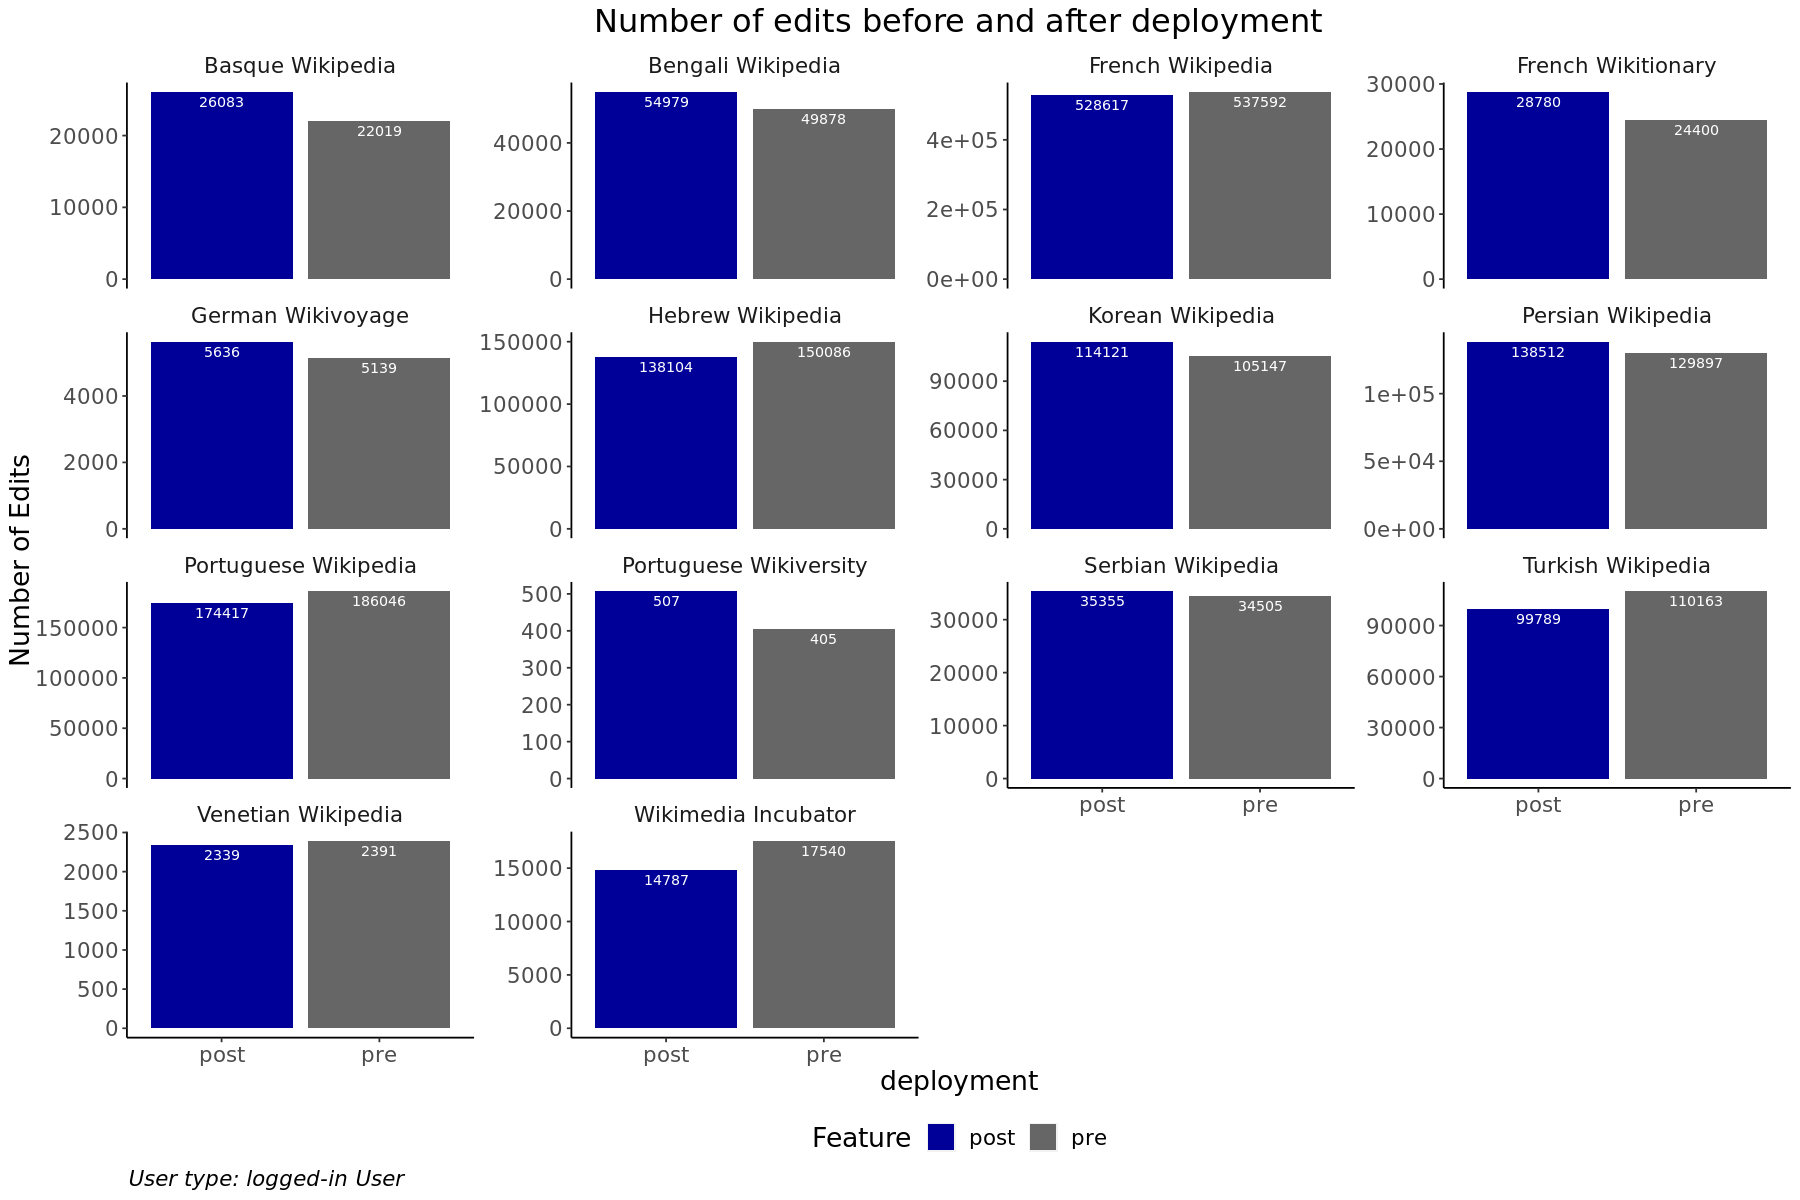

In [154]:
edits_barchart <- df_edits_nonbot_prepost %>%
        ggplot(aes(x = deployment, y= sum_events, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(sum_events)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "Number of Edits",
             title = "Number of edits before and after deployment",
             caption = "User type: logged-in User") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

edits_barchart

__Determin the percentage of changes__

In [155]:
# determine percent change

df_edits_nonbot_prepost_w <- df_edits_nonbot_prepost %>%
  select(wiki_name, deployment,sum_events) %>%
  pivot_wider(names_from = deployment, values_from = sum_events) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_edits_nonbot_prepost_w

wiki_name              post   pre    pct_change
1  Basque Wikipedia        26083  22019  18.46    
2  Bengali Wikipedia       54979  49878  10.23    
3  French Wikipedia       528617 537592  -1.67    
4  French Wikitionary      28780  24400  17.95    
5  German Wikivoyage        5636   5139   9.67    
6  Hebrew Wikipedia       138104 150086  -7.98    
7  Korean Wikipedia       114121 105147   8.53    
8  Persian Wikipedia      138512 129897   6.63    
9  Portuguese Wikipedia   174417 186046  -6.25    
10 Portuguese Wikiversity    507    405  25.19    
11 Serbian Wikipedia       35355  34505   2.46    
12 Turkish Wikipedia       99789 110163  -9.42    
13 Venetian Wikipedia       2339   2391  -2.17    
14 Wikimedia Incubator     14787  17540 -15.70

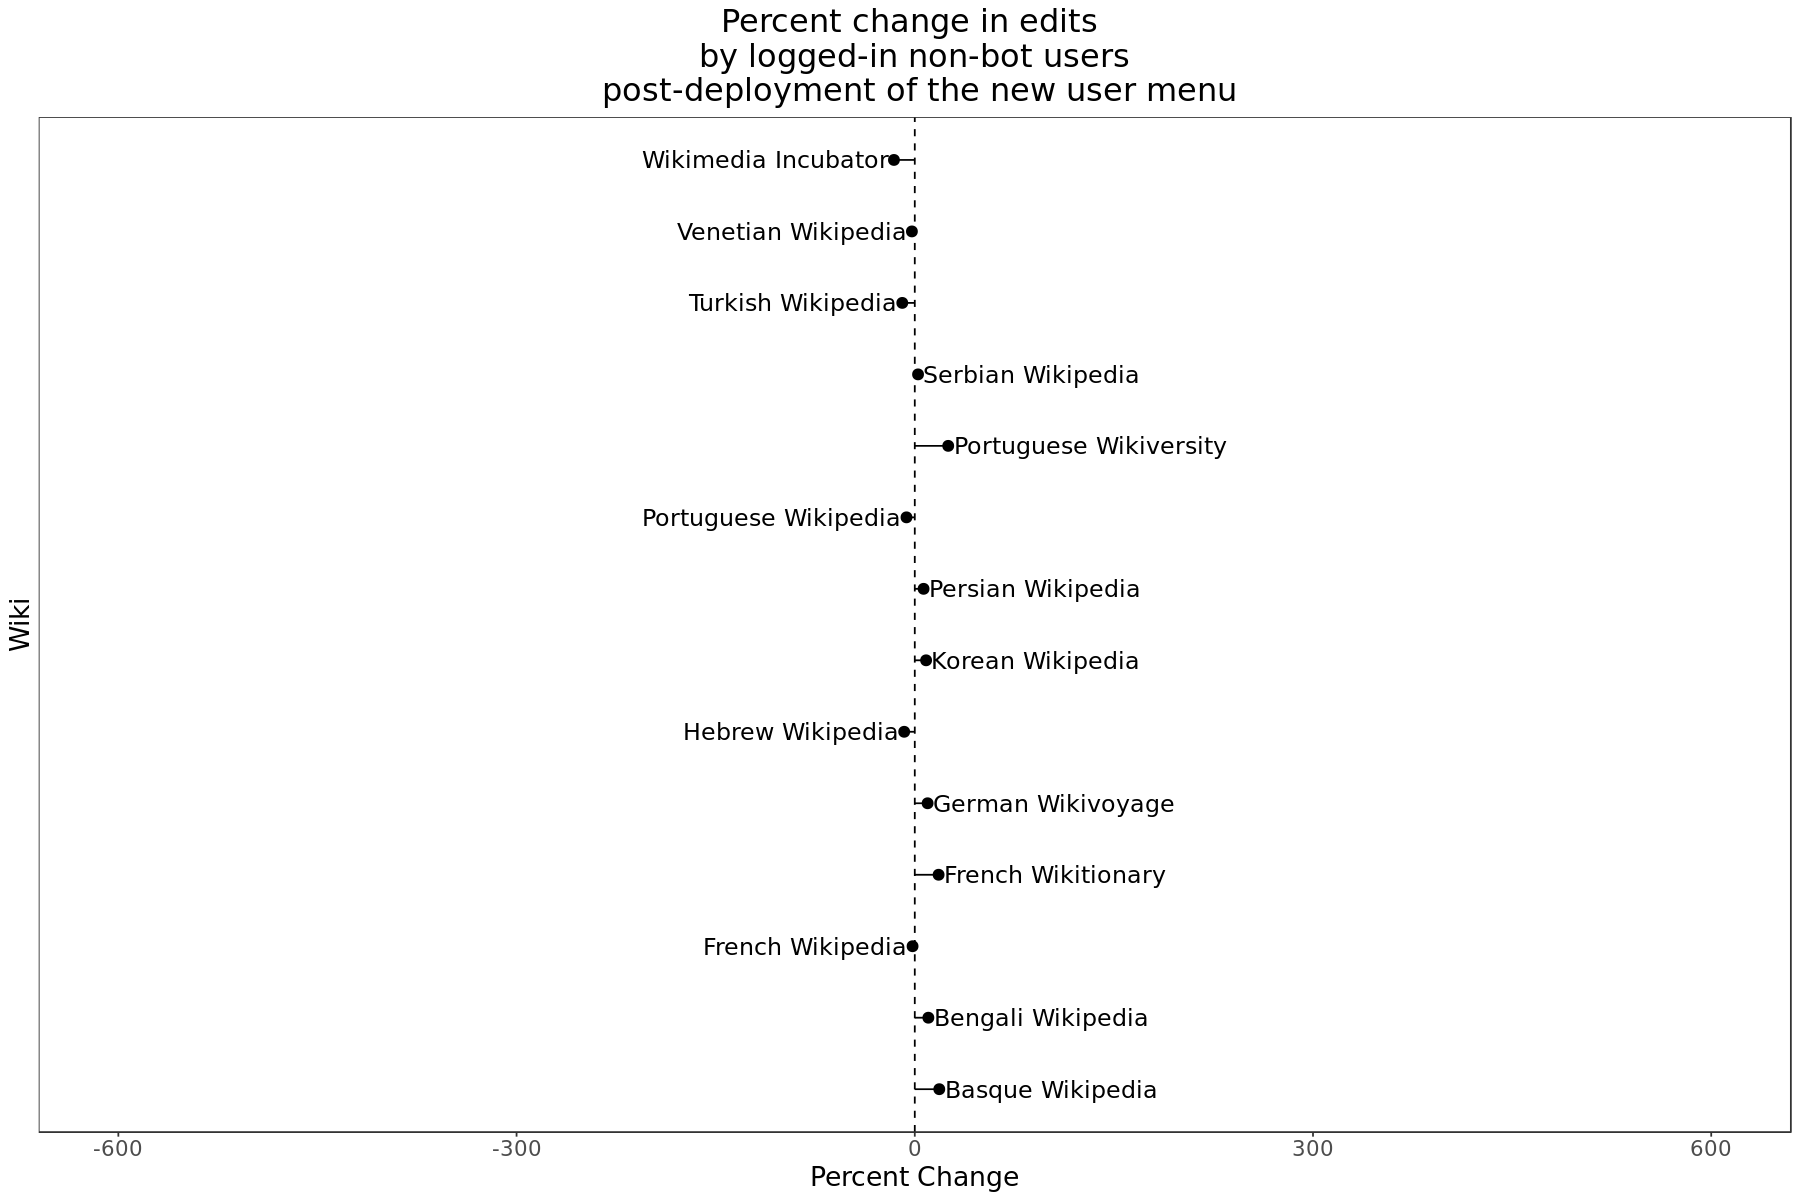

In [156]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_e_g <- df_edits_nonbot_prepost_w  %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in edits \n by logged-in non-bot users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_e_g 

__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [157]:
mean((filter(df_edits_nonbot_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] 3.995

__Summary__:



- Edit attempts by logged-in users do not have significant changes after  the deployment. 
- Edits by non-bot logged-in users do not have significant changes after the deployment.



# Pattern by edit buckets

In [60]:
query_user_link_clicks_2 <- 
"
SELECT TO_DATE(dt) AS event_date, 
    wiki, 
    event.name, 
    event.editCountBucket, 
    COUNT(1) AS clicks 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='click' 
-- only users with new skin version will see the new user menu
AND event.skinversion=2
-- only logged-in user
AND NOT event.isAnon 
AND event.name IN ('pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 'pt-mycontris', 'pt-logout') 
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) , wiki, event.name, event.editCountBucket
"

In [61]:
df_user_link_clicks_editbuckets  <-  wmfdata::query_hive(query_user_link_clicks_2 )

Don't forget to authenticate with Kerberos using kinit



In [62]:
df_user_link_clicks_editbuckets$event_date <- as.Date(df_user_link_clicks_editbuckets$event_date)

In [63]:
df_user_link_clicks_editbuckets  <- df_user_link_clicks_editbuckets  %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)

In [64]:
df_clicks_eb <- df_user_link_clicks_editbuckets   %>%
    group_by(editcountbucket, event_date) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop')


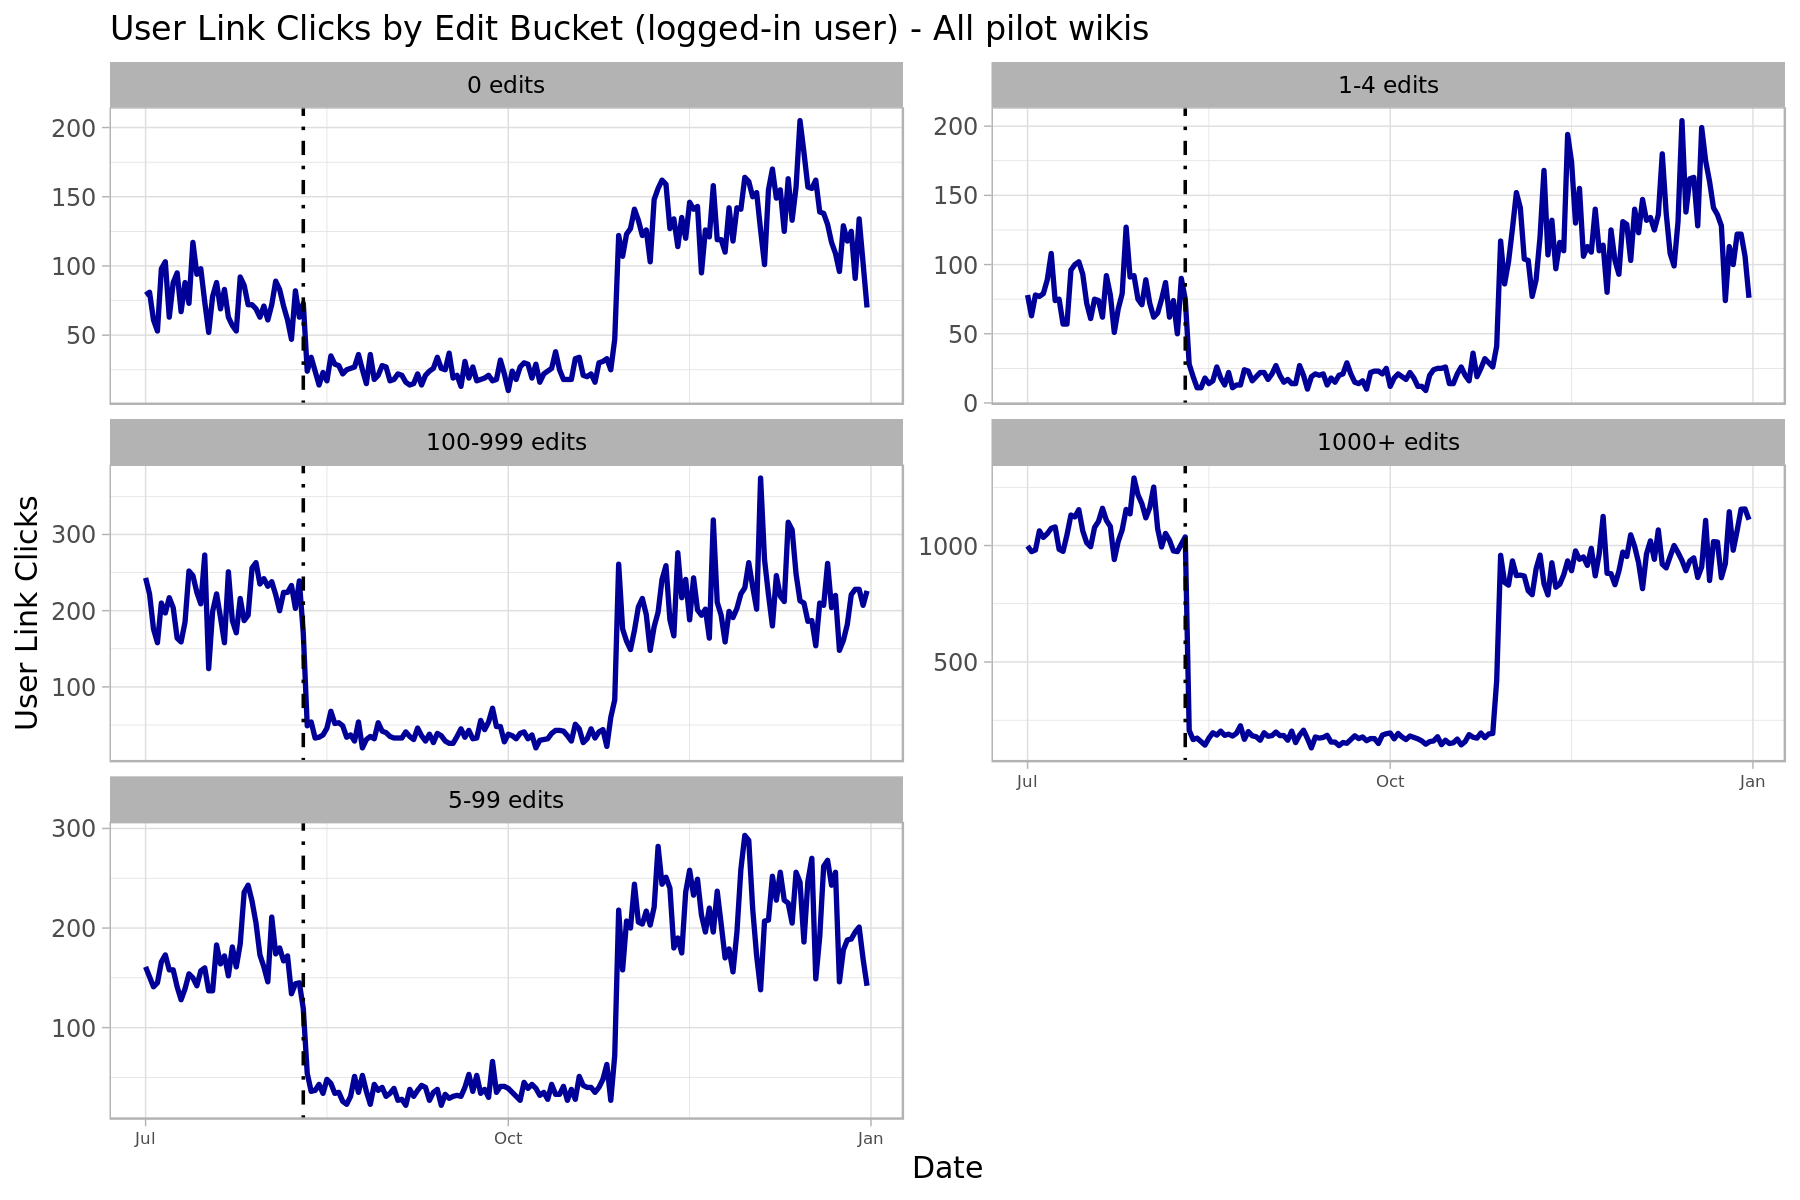

In [65]:
click_eb_g <- ggplot(data=df_clicks_eb , mapping=aes(x=event_date)) +
geom_line(aes(y=user_link_clicks ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~editcountbucket ,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks by Edit Bucket (logged-in user) - All pilot wikis ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
click_eb_g 

__Summary__:

- The user link clicks dropped since the user menu was deployed. The pattern is consistent across edits bucket groups. It is inline with our expectations. 
- Most of the clicks are from the 1000+ edits groups. Experienced users used this feature more often.
- The jump in Oct 28, 2021 is due to the change of sampling rate. https://phabricator.wikimedia.org/T292588


# QA impact of accidently turning on vector22 on polit wikis

Engineers discovered a bug that users accidentally set to Vector 22 skin since 4th May 2020. https://phabricator.wikimedia.org/T300901  

New user menu is only visible for logged-in users with the new skin version (skinversion=latest or skinversion=2). Potential impact of this bug on user menu analysis is that users might change their skin version to legacy version and they won't see the new feature, resulting in a low adoption rate of the new feature.  

__Goal:__ Following QA is to check whether the user skin version has a lot of changes during our pre and post period.  

Ideally we can check the number of users in the new/old skin version every day during the pre and post stage. So far, I have not found a schema to record the current skin version of all users.


In [67]:
query_opt_out <- "SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date_time,
    concat( normalized_host.project, '.',normalized_host.project_family) AS wiki,
    final_state AS final_state,
    COUNT(DISTINCT user_hash) AS n_user
FROM event_sanitized.mediawiki_skin_diff
WHERE 
    YEAR = 2021 AND month >=7
-- only users that opt'd out of modern vector
    AND initial_state = 'vector2'
    AND concat( normalized_host.project, '.',normalized_host.project_family,'.org')
 IN ('fr.wiktionary.org', 'he.wikipedia.org', 'pt.wikiversity.org', 'fr.wikipedia.org', 
    'eu.wikipedia.org', 'fa.wikipedia.org', 'pt.wikipedia.org', 'ko.wikipedia.org', 'tr.wikipedia.org', 
                       'sr.wikipedia.org', 'bn.wikipedia.org', 'de.wikivoyage.org', 'vec.wikipedia.org')
GROUP BY CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')), 
concat( normalized_host.project, '.',normalized_host.project_family),
final_state 
"

In [68]:
df_opt_out <-  wmfdata::query_hive(query_opt_out)

Don't forget to authenticate with Kerberos using kinit



In [69]:
df_opt_out$date_time <- as.Date(df_opt_out$date_time)
head(df_opt_out)

date_time  wiki         final_state n_user
1 2021-11-02 fa.wikipedia timeless    1     
2 2021-11-02 fa.wikipedia vector1     1     
3 2021-11-02 fr.wikipedia minerva     4     
4 2021-11-02 fr.wikipedia monobook    1     
5 2021-11-02 fr.wikipedia timeless    4     
6 2021-11-02 fr.wikipedia vector1     4

In [73]:
df_opt_out

date_time  wiki           final_state n_user
1   2021-11-02 fa.wikipedia   timeless    1     
2   2021-11-02 fa.wikipedia   vector1     1     
3   2021-11-02 fr.wikipedia   minerva     4     
4   2021-11-02 fr.wikipedia   monobook    1     
5   2021-11-02 fr.wikipedia   timeless    4     
6   2021-11-02 fr.wikipedia   vector1     4     
7   2021-11-02 pt.wikipedia   minerva     2     
8   2021-11-02 pt.wikipedia   monobook    1     
9   2021-11-02 pt.wikipedia   vector1     1     
10  2021-11-02 pt.wikiversity minerva     1     
11  2021-11-02 sr.wikipedia   minerva     1     
12  2021-11-02 tr.wikipedia   minerva     3     
13  2021-11-02 tr.wikipedia   timeless    1     
14  2021-11-02 tr.wikipedia   vector1     1     
15  2021-11-03 bn.wikipedia   monobook    1     
16  2021-11-03 de.wikivoyage  timeless    1     
17  2021-11-03 eu.wikipedia   vector1     1     
18  2021-11-03 fa.wikipedia   monobook    1     
19  2021-11-03 fr.wikipedia   minerva     2     
20  2021-11-03 fr.wikipedia   timeless    1     
21  2021-11-03 fr.wikipedia   vector1     3     
22  2021-11-03 he.wikipedia   vector1     2     
23  2021-11-03 ko.wikipedia   vector1     2     
24  2021-11-03 pt.wikipedia   minerva     1     
25  2021-11-03 pt.wikipedia   timeless    2     
26  2021-11-03 pt.wikipedia   vector1     3     
27  2021-11-03 tr.wikipedia   minerva     1     
28  2021-11-03 tr.wikipedia   timeless    1     
29  2021-11-03 tr.wikipedia   vector1     3     
30  2021-11-04 bn.wikipedia   vector1     1     
⋮   ⋮          ⋮              ⋮           ⋮     
813 2021-12-29 tr.wikipedia   minerva     1     
814 2021-12-29 tr.wikipedia   timeless    2     
815 2021-12-29 tr.wikipedia   vector1     1     
816 2021-12-30 fa.wikipedia   minerva     1     
817 2021-12-30 fa.wikipedia   vector1     1     
818 2021-12-30 fr.wikipedia   minerva     3     
819 2021-12-30 fr.wikipedia   monobook    2     
820 2021-12-30 fr.wikipedia   vector1     7     
821 2021-12-30 fr.wiktionary              1     
822 2021-12-30 ko.wikipedia               1     
823 2021-12-30 ko.wikipedia   minerva     1     
824 2021-12-30 pt.wikipedia   vector1     3     
825 2021-12-30 tr.wikipedia               2     
826 2021-12-30 tr.wikipedia   minerva     1     
827 2021-12-30 tr.wikipedia   timeless    1     
828 2021-12-31 bn.wikipedia   vector1     1     
829 2021-12-31 fa.wikipedia   minerva     2     
830 2021-12-31 fa.wikipedia   vector1     1     
831 2021-12-31 fr.wikipedia   minerva     1     
832 2021-12-31 fr.wikipedia   timeless    2     
833 2021-12-31 fr.wikipedia   vector      1     
834 2021-12-31 fr.wikipedia   vector1     8     
835 2021-12-31 fr.wiktionary  vector      1     
836 2021-12-31 he.wikipedia   minerva     1     
837 2021-12-31 he.wikipedia   monobook    1     
838 2021-12-31 he.wikipedia   vector1     1     
839 2021-12-31 ko.wikipedia               1     
840 2021-12-31 ko.wikipedia   vector1     1     
841 2021-12-31 pt.wikipedia   timeless    1     
842 2021-12-31 tr.wikipedia               1

Note: we only have data since 2021-11-02. We do not have data during pre and post stage.

In [75]:

df_opt_out_overall <- df_opt_out %>%
    group_by(date_time, wiki) %>%
    summarize(sum_optout_user = sum(n_user),  .groups = 'drop')

In [76]:
df_opt_out_overall

date_time  wiki           sum_optout_user
1   2021-11-02 fa.wikipedia    2             
2   2021-11-02 fr.wikipedia   13             
3   2021-11-02 pt.wikipedia    4             
4   2021-11-02 pt.wikiversity  1             
5   2021-11-02 sr.wikipedia    1             
6   2021-11-02 tr.wikipedia    5             
7   2021-11-03 bn.wikipedia    1             
8   2021-11-03 de.wikivoyage   1             
9   2021-11-03 eu.wikipedia    1             
10  2021-11-03 fa.wikipedia    1             
11  2021-11-03 fr.wikipedia    6             
12  2021-11-03 he.wikipedia    2             
13  2021-11-03 ko.wikipedia    2             
14  2021-11-03 pt.wikipedia    6             
15  2021-11-03 tr.wikipedia    5             
16  2021-11-04 bn.wikipedia    1             
17  2021-11-04 fa.wikipedia    4             
18  2021-11-04 fr.wikipedia   21             
19  2021-11-04 he.wikipedia    3             
20  2021-11-04 ko.wikipedia    1             
21  2021-11-04 pt.wikipedia    6             
22  2021-11-04 sr.wikipedia    1             
23  2021-11-04 tr.wikipedia    6             
24  2021-11-05 de.wikivoyage   1             
25  2021-11-05 fa.wikipedia    1             
26  2021-11-05 fr.wikipedia   11             
27  2021-11-05 he.wikipedia    2             
28  2021-11-05 ko.wikipedia    1             
29  2021-11-05 pt.wikipedia    5             
30  2021-11-05 tr.wikipedia    3             
⋮   ⋮          ⋮              ⋮              
393 2021-12-27 pt.wikipedia    7             
394 2021-12-27 pt.wikiversity  1             
395 2021-12-27 tr.wikipedia    9             
396 2021-12-28 bn.wikipedia    1             
397 2021-12-28 fa.wikipedia    1             
398 2021-12-28 fr.wikipedia    7             
399 2021-12-28 fr.wiktionary   1             
400 2021-12-28 ko.wikipedia    3             
401 2021-12-28 pt.wikipedia    5             
402 2021-12-28 tr.wikipedia    2             
403 2021-12-29 fa.wikipedia    1             
404 2021-12-29 fr.wikipedia   12             
405 2021-12-29 ko.wikipedia    1             
406 2021-12-29 pt.wikipedia    5             
407 2021-12-29 sr.wikipedia    1             
408 2021-12-29 tr.wikipedia    6             
409 2021-12-30 fa.wikipedia    2             
410 2021-12-30 fr.wikipedia   12             
411 2021-12-30 fr.wiktionary   1             
412 2021-12-30 ko.wikipedia    2             
413 2021-12-30 pt.wikipedia    3             
414 2021-12-30 tr.wikipedia    4             
415 2021-12-31 bn.wikipedia    1             
416 2021-12-31 fa.wikipedia    3             
417 2021-12-31 fr.wikipedia   12             
418 2021-12-31 fr.wiktionary   1             
419 2021-12-31 he.wikipedia    3             
420 2021-12-31 ko.wikipedia    2             
421 2021-12-31 pt.wikipedia    1             
422 2021-12-31 tr.wikipedia    1

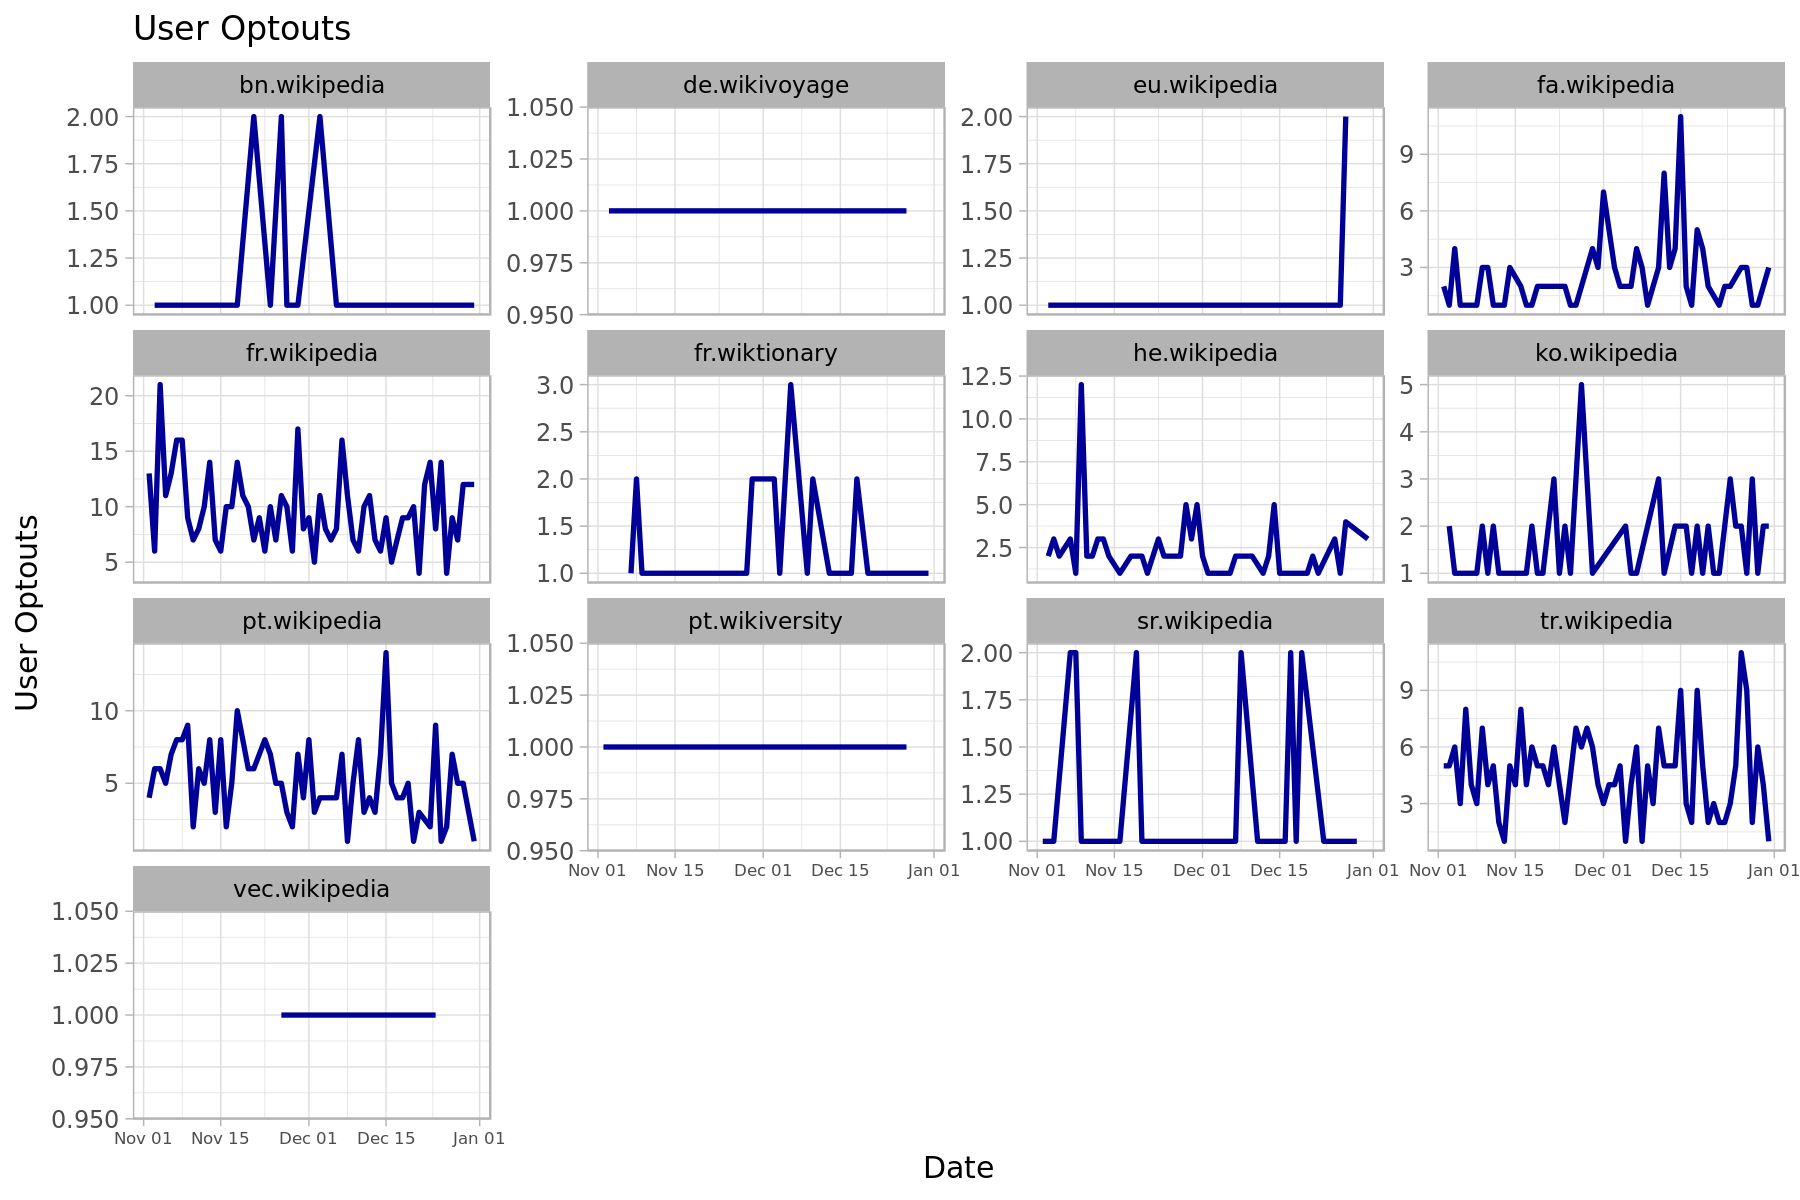

In [79]:

optouts_g <- ggplot(data=df_opt_out_overall, 
                                mapping=aes(x=date_time)) +
geom_line(aes(y=sum_optout_user ), color="#000099" , size = 1.5) +
facet_wrap(~wiki,nrow=4,scale = 'free_y')+
labs(title = 'User Optouts  ',
     x = 'Date',
     y = 'User Optouts') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
optouts_g

__Note__:

 
We cannot confirm how the issue T300901 impact our deployment analysis due to lack of data.  
The trend is flat. Did not show a surge in the data available data,  between Nov 11 2021 and Dec 31 2021.  